In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
sklearn 0.19.1
scipy 1.1.0
matplotlib 2.2.2
tensorflow 1.8.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.139518	최선의 손실: 0.139518	정확도: 95.62%
1	검증 세트 손실: 0.828389	최선의 손실: 0.139518	정확도: 68.45%
2	검증 세트 손실: 1.649469	최선의 손실: 0.139518	정확도: 20.91%
3	검증 세트 손실: 1.803031	최선의 손실: 0.139518	정확도: 19.08%
4	검증 세트 손실: 1.631349	최선의 손실: 0.139518	정확도: 22.01%
5	검증 세트 손실: 1.639141	최선의 손실: 0.139518	정확도: 22.01%
6	검증 세트 손실: 1.677314	최선의 손실: 0.139518	정확도: 18.73%
7	검증 세트 손실: 1.776537	최선의 손실: 0.139518	정확도: 22.01%
8	검증 세트 손실: 1.699600	최선의 손실: 0.139518	정확도: 19.27%
9	검증 세트 손실: 1.767772	최선의 손실: 0.139518	정확도: 20.91%
10	검증 세트 손실: 1.629337	최선의 손실: 0.139518	정확도: 22.01%
11	검증 세트 손실: 1.812662	최선의 손실: 0.139518	정확도: 22.01%
12	검증 세트 손실: 1.675932	최선의 손실: 0.139518	정확도: 18.73%
13	검증 세트 손실: 1.633258	최선의 손실: 0.139518	정확도: 20.91%
14	검증 세트 손실: 1.652906	최선의 손실: 0.139518	정확도: 20.91%
15	검증 세트 손실: 1.635939	최선의 손실: 0.139518	정확도: 20.91%
16	검증 세트 손실: 1.718920	최선의 손실: 0.139518	정확도: 19.08%
17	검증 세트 손실: 1.682459	최선의 손실: 0.139518	정확도: 19.27%
18	검증 세트 손실: 1.675367	최선의 손실: 0.139518	정확도: 18.73%
19	검증 세트 손실: 1.645803	최선의 손실: 0.139518	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.143031	최선의 손실: 0.143031	정확도: 95.82%
1	검증 세트 손실: 0.120918	최선의 손실: 0.120918	정확도: 97.30%
2	검증 세트 손실: 0.257154	최선의 손실: 0.120918	정확도: 95.00%
3	검증 세트 손실: 0.324577	최선의 손실: 0.120918	정확도: 91.09%
4	검증 세트 손실: 0.198269	최선의 손실: 0.120918	정확도: 95.66%
5	검증 세트 손실: 0.303321	최선의 손실: 0.120918	정확도: 96.36%
6	검증 세트 손실: 0.165810	최선의 손실: 0.120918	정확도: 97.58%
7	검증 세트 손실: 0.176505	최선의 손실: 0.120918	정확도: 98.36%
8	검증 세트 손실: 0.377566	최선의 손실: 0.120918	정확도: 92.92%
9	검증 세트 손실: 0.257152	최선의 손실: 0.120918	정확도: 95.07%
10	검증 세트 손실: 0.209042	최선의 손실: 0.120918	정확도: 98.12%
11	검증 세트 손실: 0.173772	최선의 손실: 0.120918	정확도: 98.20%
12	검증 세트 손실: 0.307521	최선의 손실: 0.120918	정확도: 95.74%
13	검증 세트 손실: 0.156727	최선의 손실: 0.120918	정확도: 98.05%
14	검증 세트 손실: 0.171871	최선의 손실: 0.120918	정확도: 98.12%
15	검증 세트 손실: 0.160136	최선의 손실: 0.120918	정확도: 98.16%
16	검증 세트 손실: 0.235736	최선의 손실: 0.120918	정확도: 98.24%
17	검증 세트 손실: 0.198371	최선의 손실: 0.120918	정확도: 98.20%
18	검증 세트 손실: 0.225569	최선의 손실: 0.120918	정확도: 98.36%
19	검증 세트 손실: 0.161978	최선의 손실: 0.120918	정확

DNNClassifier(activation=<function elu at 0x7fc28719fb70>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9807355516637478

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.158368	최선의 손실: 0.158368	정확도: 95.93%
1	검증 세트 손실: 0.140635	최선의 손실: 0.140635	정확도: 96.05%
2	검증 세트 손실: 0.119741	최선의 손실: 0.119741	정확도: 97.11%
3	검증 세트 손실: 0.126138	최선의 손실: 0.119741	정확도: 96.91%
4	검증 세트 손실: 0.134933	최선의 손실: 0.119741	정확도: 97.22%
5	검증 세트 손실: 0.157912	최선의 손실: 0.119741	정확도: 95.58%
6	검증 세트 손실: 1.251026	최선의 손실: 0.119741	정확도: 45.07%
7	검증 세트 손실: 1.612513	최선의 손실: 0.119741	정확도: 22.01%
8	검증 세트 손실: 1.614821	최선의 손실: 0.119741	정확도: 19.74%
9	검증 세트 손실: 1.615436	최선의 손실: 0.119741	정확도: 22.01%
10	검증 세트 손실: 1.611276	최선의 손실: 0.119741	정확도: 22.01%
11	검증 세트 손실: 1.609443	최선의 손실: 0.119741	정확도: 22.01%
12	검증 세트 손실: 1.617342	최선의 손실: 0.119741	정확도: 22.01%
13	검증 세트 손실: 1.637030	최선의 손실: 0.119741	정확도: 18.73%
14	검증 세트 손실: 1.611280	최선의 손실: 0.119741	정확도: 22.01%
15	검증 세트 손실: 1.619393	최선의 손실: 0.119741	정확도: 22.01%
16	검증 세트 손실: 1.617316	최선의 손실: 0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


0	검증 세트 손실: 0.128785	최선의 손실: 0.128785	정확도: 96.60%
1	검증 세트 손실: 0.177104	최선의 손실: 0.128785	정확도: 95.86%
2	검증 세트 손실: 0.150355	최선의 손실: 0.128785	정확도: 95.70%
3	검증 세트 손실: 0.160620	최선의 손실: 0.128785	정확도: 96.13%
4	검증 세트 손실: 0.113291	최선의 손실: 0.113291	정확도: 96.76%
5	검증 세트 손실: 0.169935	최선의 손실: 0.113291	정확도: 96.21%
6	검증 세트 손실: 1.037454	최선의 손실: 0.113291	정확도: 68.73%
7	검증 세트 손실: 1.618414	최선의 손실: 0.113291	정확도: 19.08%
8	검증 세트 손실: 1.611315	최선의 손실: 0.113291	정확도: 19.27%
9	검증 세트 손실: 1.616881	최선의 손실: 0.113291	정확도: 22.01%
10	검증 세트 손실: 1.619859	최선의 손실: 0.113291	정확도: 19.27%
11	검증 세트 손실: 1.645674	최선의 손실: 0.113291	정확도: 19.08%
12	검증 세트 손실: 1.627130	최선의 손실: 0.113291	정확도: 19.08%
13	검증 세트 손실: 1.628483	최선의 손실: 0.113291	정확도: 19.27%
14	검증 세트 손실: 1.619846	최선의 손실: 0.113291	정확도: 22.01%
15	검증 세트 손실: 1.614326	최선의 손실: 0.113291	정확도: 22.01%
16	검증 세트 손실: 1.626661	최선의 손실: 0.113291	정확도: 22.01%
17	검증 세트 손실: 1.616785	최선의 손실: 0.113291	정확도: 20.91%
18	검증 세트 손실: 1.632607	최선의 손실: 0.113291	정확도: 22.01%
19	검증 세트 손실: 1.618984	최선의 손실: 0.113291	정확

0	검증 세트 손실: 3.554969	최선의 손실: 3.554969	정확도: 57.00%
1	검증 세트 손실: 0.808748	최선의 손실: 0.808748	정확도: 67.32%
2	검증 세트 손실: 0.435940	최선의 손실: 0.435940	정확도: 84.64%
3	검증 세트 손실: 0.393587	최선의 손실: 0.393587	정확도: 86.79%
4	검증 세트 손실: 0.638236	최선의 손실: 0.393587	정확도: 83.62%
5	검증 세트 손실: 0.241392	최선의 손실: 0.241392	정확도: 93.59%
6	검증 세트 손실: 0.333600	최선의 손실: 0.241392	정확도: 90.73%
7	검증 세트 손실: 36761.082031	최선의 손실: 0.241392	정확도: 20.91%
8	검증 세트 손실: 259.611481	최선의 손실: 0.241392	정확도: 57.62%
9	검증 세트 손실: 107.114136	최선의 손실: 0.241392	정확도: 58.72%
10	검증 세트 손실: 2226.710693	최선의 손실: 0.241392	정확도: 40.70%
11	검증 세트 손실: 351.238281	최선의 손실: 0.241392	정확도: 56.72%
12	검증 세트 손실: 466.597839	최선의 손실: 0.241392	정확도: 62.47%
13	검증 세트 손실: 101.401360	최선의 손실: 0.241392	정확도: 54.61%
14	검증 세트 손실: 88.317238	최선의 손실: 0.241392	정확도: 64.97%
15	검증 세트 손실: 131.904129	최선의 손실: 0.241392	정확도: 66.22%
16	검증 세트 손실: 59.773308	최선의 손실: 0.241392	정확도: 75.61%
17	검증 세트 손실: 56.153488	최선의 손실: 0.241392	정확도: 79.36%
18	검증 세트 손실: 40.750252	최선의 손실: 0.241392	정확도: 81.16%
19	검증 세트 손실: 36.26

26	검증 세트 손실: 86152.921875	최선의 손실: 36.326248	정확도: 93.55%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60>, total=  12.7s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60> 
0	검증 세트 손실: 135.442307	최선의 손실: 135.442307	정확도: 72.99%
1	검증 세트 손실: 16.184174	최선의 손실: 16.184174	정확도: 93.12%
2	검증 세트 손실: 10.843725	최선의 손실: 10.843725	정확도: 91.48%
3	검증 세트 손실: 11.876012	최선의 손실: 10.843725	정확도: 93.67%
4	검증 세트 손실: 56.979000	최선의 손실: 10.843725	정확도: 83.42%
5	검증 세트 손실: 6.325847	최선의 손실: 6.325847	정확도: 94.41%
6	검증 세트 손실: 148.266785	최선의 손실: 6.325847	정확도: 94.53%
7	검증 세트 손실: 18.674683	최선의 손실: 6.325847	정확도: 95.04%
8	검증 세트 손실: 14.487318	최선의 손실: 6.325847	정확도: 91.87%
9	검증 세트 손실: 22.501865	최선의 손실: 6.325847	정확도: 96.36%
10	검증 세트 손실: 8.147702	최선의 손실: 6.325847	정확도: 95.54%
11	검증 세트 손실: 3.698935	최선의 손실: 3.698935	정확도: 95.47%
12	검증 세트 손실: 1783866.500000

0	검증 세트 손실: 0.105183	최선의 손실: 0.105183	정확도: 96.68%
1	검증 세트 손실: 0.062150	최선의 손실: 0.062150	정확도: 98.20%
2	검증 세트 손실: 0.055508	최선의 손실: 0.055508	정확도: 98.36%
3	검증 세트 손실: 0.076759	최선의 손실: 0.055508	정확도: 98.12%
4	검증 세트 손실: 0.050423	최선의 손실: 0.050423	정확도: 98.32%
5	검증 세트 손실: 0.079935	최선의 손실: 0.050423	정확도: 98.24%
6	검증 세트 손실: 0.077785	최선의 손실: 0.050423	정확도: 97.85%
7	검증 세트 손실: 0.064588	최선의 손실: 0.050423	정확도: 98.44%
8	검증 세트 손실: 0.077657	최선의 손실: 0.050423	정확도: 98.91%
9	검증 세트 손실: 0.070755	최선의 손실: 0.050423	정확도: 98.48%
10	검증 세트 손실: 0.043284	최선의 손실: 0.043284	정확도: 99.06%
11	검증 세트 손실: 0.064598	최선의 손실: 0.043284	정확도: 98.79%
12	검증 세트 손실: 0.068901	최선의 손실: 0.043284	정확도: 98.94%
13	검증 세트 손실: 0.059892	최선의 손실: 0.043284	정확도: 98.67%
14	검증 세트 손실: 0.056418	최선의 손실: 0.043284	정확도: 98.48%
15	검증 세트 손실: 0.068464	최선의 손실: 0.043284	정확도: 98.71%
16	검증 세트 손실: 0.076347	최선의 손실: 0.043284	정확도: 98.51%
17	검증 세트 손실: 0.102947	최선의 손실: 0.043284	정확도: 98.40%
18	검증 세트 손실: 0.072885	최선의 손실: 0.043284	정확도: 98.79%
19	검증 세트 손실: 0.098539	최선의 손실: 0.043284	정확

12	검증 세트 손실: 0.044773	최선의 손실: 0.043158	정확도: 98.83%
13	검증 세트 손실: 0.047999	최선의 손실: 0.043158	정확도: 98.75%
14	검증 세트 손실: 0.053666	최선의 손실: 0.043158	정확도: 98.63%
15	검증 세트 손실: 0.046754	최선의 손실: 0.043158	정확도: 99.02%
16	검증 세트 손실: 0.056650	최선의 손실: 0.043158	정확도: 98.71%
17	검증 세트 손실: 0.055145	최선의 손실: 0.043158	정확도: 98.67%
18	검증 세트 손실: 0.056673	최선의 손실: 0.043158	정확도: 98.83%
19	검증 세트 손실: 0.047466	최선의 손실: 0.043158	정확도: 98.98%
20	검증 세트 손실: 0.061681	최선의 손실: 0.043158	정확도: 98.63%
21	검증 세트 손실: 0.066502	최선의 손실: 0.043158	정확도: 98.67%
22	검증 세트 손실: 0.059887	최선의 손실: 0.043158	정확도: 98.75%
23	검증 세트 손실: 0.063679	최선의 손실: 0.043158	정확도: 98.94%
24	검증 세트 손실: 0.076010	최선의 손실: 0.043158	정확도: 98.71%
25	검증 세트 손실: 0.057502	최선의 손실: 0.043158	정확도: 98.83%
26	검증 세트 손실: 0.065321	최선의 손실: 0.043158	정확도: 98.63%
27	검증 세트 손실: 0.054085	최선의 손실: 0.043158	정확도: 98.75%
28	검증 세트 손실: 0.063909	최선의 손실: 0.043158	정확도: 98.87%
29	검증 세트 손실: 0.072592	최선의 손실: 0.043158	정확도: 98.75%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, activation=<functi

60	검증 세트 손실: 1.635965	최선의 손실: 1.607884	정확도: 18.73%
61	검증 세트 손실: 1.627400	최선의 손실: 1.607884	정확도: 22.01%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=10, activation=<function relu at 0x7fc287152ea0>, total= 1.6min
[CV] n_neurons=50, learning_rate=0.1, batch_size=10, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 1.644700	최선의 손실: 1.644700	정확도: 19.27%
1	검증 세트 손실: 1.624599	최선의 손실: 1.624599	정확도: 19.27%
2	검증 세트 손실: 1.614161	최선의 손실: 1.614161	정확도: 19.27%
3	검증 세트 손실: 1.616997	최선의 손실: 1.614161	정확도: 19.27%
4	검증 세트 손실: 1.614504	최선의 손실: 1.614161	정확도: 22.01%
5	검증 세트 손실: 1.627702	최선의 손실: 1.614161	정확도: 22.01%
6	검증 세트 손실: 1.648679	최선의 손실: 1.614161	정확도: 19.27%
7	검증 세트 손실: 1.627600	최선의 손실: 1.614161	정확도: 18.73%
8	검증 세트 손실: 1.625684	최선의 손실: 1.614161	정확도: 22.01%
9	검증 세트 손실: 1.615555	최선의 손실: 1.614161	정확도: 20.91%
10	검증 세트 손실: 1.619122	최선의 손실: 1.614161	정확도: 22.01%
11	검증 세트 손실: 1.639598	최선의 손실: 1.614161	정확도: 22.01%
12	검증 세트 손실: 1.627612	최선의 손실: 1.614161	정확도: 19.08%
13	검증 세트 손실: 1.615013	최선의

16	검증 세트 손실: 0.114933	최선의 손실: 0.058988	정확도: 97.81%
17	검증 세트 손실: 0.118699	최선의 손실: 0.058988	정확도: 98.01%
18	검증 세트 손실: 0.082592	최선의 손실: 0.058988	정확도: 98.08%
19	검증 세트 손실: 0.107904	최선의 손실: 0.058988	정확도: 98.12%
20	검증 세트 손실: 0.109993	최선의 손실: 0.058988	정확도: 97.42%
21	검증 세트 손실: 0.100516	최선의 손실: 0.058988	정확도: 98.01%
22	검증 세트 손실: 0.106056	최선의 손실: 0.058988	정확도: 98.40%
23	검증 세트 손실: 0.086669	최선의 손실: 0.058988	정확도: 97.85%
24	검증 세트 손실: 0.107487	최선의 손실: 0.058988	정확도: 98.01%
25	검증 세트 손실: 0.119760	최선의 손실: 0.058988	정확도: 97.93%
26	검증 세트 손실: 0.086470	최선의 손실: 0.058988	정확도: 98.44%
27	검증 세트 손실: 0.091485	최선의 손실: 0.058988	정확도: 98.24%
28	검증 세트 손실: 0.318420	최선의 손실: 0.058988	정확도: 93.35%
29	검증 세트 손실: 0.282315	최선의 손실: 0.058988	정확도: 96.13%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7fc287152ea0>, total=   5.6s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc2679b7268> 
0	검증 세트 손실: 0.221475	최선

15	검증 세트 손실: 0.548299	최선의 손실: 0.062228	정확도: 95.78%
16	검증 세트 손실: 0.157959	최선의 손실: 0.062228	정확도: 97.38%
17	검증 세트 손실: 0.115973	최선의 손실: 0.062228	정확도: 98.08%
18	검증 세트 손실: 0.158898	최선의 손실: 0.062228	정확도: 98.32%
19	검증 세트 손실: 0.091144	최선의 손실: 0.062228	정확도: 98.28%
20	검증 세트 손실: 0.124017	최선의 손실: 0.062228	정확도: 97.50%
21	검증 세트 손실: 0.142588	최선의 손실: 0.062228	정확도: 98.24%
22	검증 세트 손실: 0.100528	최선의 손실: 0.062228	정확도: 98.05%
23	검증 세트 손실: 0.168163	최선의 손실: 0.062228	정확도: 98.40%
24	검증 세트 손실: 2.412129	최선의 손실: 0.062228	정확도: 95.11%
25	검증 세트 손실: 0.138783	최선의 손실: 0.062228	정확도: 97.62%
26	검증 세트 손실: 0.084383	최선의 손실: 0.062228	정확도: 98.12%
27	검증 세트 손실: 0.088495	최선의 손실: 0.062228	정확도: 98.05%
28	검증 세트 손실: 0.170924	최선의 손실: 0.062228	정확도: 98.16%
29	검증 세트 손실: 0.132540	최선의 손실: 0.062228	정확도: 98.24%
30	검증 세트 손실: 0.446264	최선의 손실: 0.062228	정확도: 94.02%
31	검증 세트 손실: 0.120299	최선의 손실: 0.062228	정확도: 97.73%
32	검증 세트 손실: 0.095034	최선의 손실: 0.062228	정확도: 98.20%
33	검증 세트 손실: 0.085257	최선의 손실: 0.062228	정확도: 98.40%
34	검증 세트 손실: 0.095926	최선의 손실: 0

12	검증 세트 손실: 0.126588	최선의 손실: 0.126588	정확도: 96.72%
13	검증 세트 손실: 0.147774	최선의 손실: 0.126588	정확도: 96.60%
14	검증 세트 손실: 0.138966	최선의 손실: 0.126588	정확도: 96.60%
15	검증 세트 손실: 0.139981	최선의 손실: 0.126588	정확도: 96.95%
16	검증 세트 손실: 0.124748	최선의 손실: 0.124748	정확도: 97.03%
17	검증 세트 손실: 0.134454	최선의 손실: 0.124748	정확도: 97.11%
18	검증 세트 손실: 0.134459	최선의 손실: 0.124748	정확도: 97.19%
19	검증 세트 손실: 0.144621	최선의 손실: 0.124748	정확도: 96.76%
20	검증 세트 손실: 0.139736	최선의 손실: 0.124748	정확도: 96.87%
21	검증 세트 손실: 0.145177	최선의 손실: 0.124748	정확도: 96.68%
22	검증 세트 손실: 0.114993	최선의 손실: 0.114993	정확도: 97.34%
23	검증 세트 손실: 0.121165	최선의 손실: 0.114993	정확도: 97.03%
24	검증 세트 손실: 0.129509	최선의 손실: 0.114993	정확도: 97.26%
25	검증 세트 손실: 0.120026	최선의 손실: 0.114993	정확도: 97.38%
26	검증 세트 손실: 0.125088	최선의 손실: 0.114993	정확도: 97.30%
27	검증 세트 손실: 0.133975	최선의 손실: 0.114993	정확도: 97.54%
28	검증 세트 손실: 0.121667	최선의 손실: 0.114993	정확도: 97.19%
29	검증 세트 손실: 0.146491	최선의 손실: 0.114993	정확도: 97.15%
30	검증 세트 손실: 0.134108	최선의 손실: 0.114993	정확도: 97.26%
31	검증 세트 손실: 0.165341	최선의 손실: 0

18	검증 세트 손실: 24182.732422	최선의 손실: 0.813995	정확도: 93.67%
19	검증 세트 손실: 16177.547852	최선의 손실: 0.813995	정확도: 94.72%
20	검증 세트 손실: 19482.226562	최선의 손실: 0.813995	정확도: 95.23%
21	검증 세트 손실: 24120.117188	최선의 손실: 0.813995	정확도: 93.00%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc2679b7268>, total=  10.4s
[CV] n_neurons=100, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc2679b7268> 
0	검증 세트 손실: 5581.382324	최선의 손실: 5581.382324	정확도: 26.15%
1	검증 세트 손실: 42.626511	최선의 손실: 42.626511	정확도: 24.63%
2	검증 세트 손실: 20.493179	최선의 손실: 20.493179	정확도: 28.23%
3	검증 세트 손실: 11.571117	최선의 손실: 11.571117	정확도: 32.76%
4	검증 세트 손실: 109.862343	최선의 손실: 11.571117	정확도: 30.53%
5	검증 세트 손실: 21.474987	최선의 손실: 11.571117	정확도: 47.77%
6	검증 세트 손실: 23.930712	최선의 손실: 11.571117	정확도: 37.14%
7	검증 세트 손실: 16.683889	최선의 손실: 11.571117	정확도: 42.14%
8	검증 세트 손실: 21.667984	최선의 손실: 11.571117	정확도: 40.62%
9	검증 세트

10	검증 세트 손실: 0.134776	최선의 손실: 0.117176	정확도: 97.19%
11	검증 세트 손실: 0.111272	최선의 손실: 0.111272	정확도: 97.58%
12	검증 세트 손실: 0.119993	최선의 손실: 0.111272	정확도: 97.42%
13	검증 세트 손실: 0.101747	최선의 손실: 0.101747	정확도: 97.93%
14	검증 세트 손실: 0.115033	최선의 손실: 0.101747	정확도: 97.81%
15	검증 세트 손실: 0.114155	최선의 손실: 0.101747	정확도: 97.97%
16	검증 세트 손실: 0.151760	최선의 손실: 0.101747	정확도: 96.95%
17	검증 세트 손실: 114038688.000000	최선의 손실: 0.101747	정확도: 18.73%
18	검증 세트 손실: 24119.214844	최선의 손실: 0.101747	정확도: 87.80%
19	검증 세트 손실: 20886.140625	최선의 손실: 0.101747	정확도: 86.16%
20	검증 세트 손실: 15851.966797	최선의 손실: 0.101747	정확도: 88.15%
21	검증 세트 손실: 16214.166016	최선의 손실: 0.101747	정확도: 90.30%
22	검증 세트 손실: 6434.910645	최선의 손실: 0.101747	정확도: 92.14%
23	검증 세트 손실: 4669.493164	최선의 손실: 0.101747	정확도: 95.15%
24	검증 세트 손실: 6963.567871	최선의 손실: 0.101747	정확도: 92.34%
25	검증 세트 손실: 7147.170410	최선의 손실: 0.101747	정확도: 92.65%
26	검증 세트 손실: 4758.573730	최선의 손실: 0.101747	정확도: 95.04%
27	검증 세트 손실: 3946.893555	최선의 손실: 0.101747	정확도: 95.23%
28	검증 세트 손실: 3893.087158	최선의 손실: 0.10174

24	검증 세트 손실: 0.056701	최선의 손실: 0.051787	정확도: 98.91%
25	검증 세트 손실: 0.082195	최선의 손실: 0.051787	정확도: 98.79%
26	검증 세트 손실: 0.097880	최선의 손실: 0.051787	정확도: 98.44%
27	검증 세트 손실: 0.064273	최선의 손실: 0.051787	정확도: 98.83%
28	검증 세트 손실: 0.087324	최선의 손실: 0.051787	정확도: 98.28%
29	검증 세트 손실: 0.080798	최선의 손실: 0.051787	정확도: 98.40%
30	검증 세트 손실: 0.062006	최선의 손실: 0.051787	정확도: 98.71%
31	검증 세트 손실: 0.091805	최선의 손실: 0.051787	정확도: 98.24%
32	검증 세트 손실: 0.088153	최선의 손실: 0.051787	정확도: 98.55%
33	검증 세트 손실: 0.079292	최선의 손실: 0.051787	정확도: 98.71%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7fc28719fb70>, total=   2.4s
[CV] n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.132233	최선의 손실: 0.132233	정확도: 95.93%
1	검증 세트 손실: 0.079551	최선의 손실: 0.079551	정확도: 97.54%
2	검증 세트 손실: 0.062300	최선의 손실: 0.062300	정확도: 98.05%
3	검증 세트 손실: 0.055876	최선의 손실: 0.055876	정확도: 98.40%
4	검증 세트 손실: 0.061177	최선의 손실: 0.055876	정확도: 98.16%
5	검증 세트 손실: 0.0662

25	검증 세트 손실: 1.614432	최선의 손실: 0.308196	정확도: 22.01%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x7fc287152ea0>, total=   9.2s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60> 
0	검증 세트 손실: 0.218324	최선의 손실: 0.218324	정확도: 96.09%
1	검증 세트 손실: 147.053955	최선의 손실: 0.218324	정확도: 68.06%
2	검증 세트 손실: 1.401268	최선의 손실: 0.218324	정확도: 91.95%
3	검증 세트 손실: 1.593924	최선의 손실: 0.218324	정확도: 89.84%
4	검증 세트 손실: 0.765481	최선의 손실: 0.218324	정확도: 94.84%
5	검증 세트 손실: 3.340133	최선의 손실: 0.218324	정확도: 93.43%
6	검증 세트 손실: 1.033821	최선의 손실: 0.218324	정확도: 88.23%
7	검증 세트 손실: 1.173966	최선의 손실: 0.218324	정확도: 86.75%
8	검증 세트 손실: 0.647666	최선의 손실: 0.218324	정확도: 90.42%
9	검증 세트 손실: 0.414452	최선의 손실: 0.218324	정확도: 94.37%
10	검증 세트 손실: 0.291567	최선의 손실: 0.218324	정확도: 96.25%
11	검증 세트 손실: 0.400848	최선의 손실: 0.218324	정확도: 95.19%
12	검증 세트 손실: 0.456824	최선의 손실: 0.218324	정확도: 96.56%
13	검증 세트 손실: 0.531226	최선의 손실: 0.

6	검증 세트 손실: 0.140107	최선의 손실: 0.140107	정확도: 97.22%
7	검증 세트 손실: 0.380823	최선의 손실: 0.140107	정확도: 93.59%
8	검증 세트 손실: 0.134800	최선의 손실: 0.134800	정확도: 96.17%
9	검증 세트 손실: 0.157503	최선의 손실: 0.134800	정확도: 95.82%
10	검증 세트 손실: 0.149711	최선의 손실: 0.134800	정확도: 96.09%
11	검증 세트 손실: 0.186010	최선의 손실: 0.134800	정확도: 95.00%
12	검증 세트 손실: 0.170828	최선의 손실: 0.134800	정확도: 95.43%
13	검증 세트 손실: 0.463292	최선의 손실: 0.134800	정확도: 81.74%
14	검증 세트 손실: 0.268664	최선의 손실: 0.134800	정확도: 93.78%
15	검증 세트 손실: 0.201368	최선의 손실: 0.134800	정확도: 94.84%
16	검증 세트 손실: 0.444758	최선의 손실: 0.134800	정확도: 78.58%
17	검증 세트 손실: 0.486442	최선의 손실: 0.134800	정확도: 76.90%
18	검증 세트 손실: 0.410348	최선의 손실: 0.134800	정확도: 78.03%
19	검증 세트 손실: 0.472919	최선의 손실: 0.134800	정확도: 86.90%
20	검증 세트 손실: 0.265033	최선의 손실: 0.134800	정확도: 93.55%
21	검증 세트 손실: 0.479884	최선의 손실: 0.134800	정확도: 78.66%
22	검증 세트 손실: 0.658440	최선의 손실: 0.134800	정확도: 73.06%
23	검증 세트 손실: 0.705427	최선의 손실: 0.134800	정확도: 60.09%
24	검증 세트 손실: 0.753169	최선의 손실: 0.134800	정확도: 65.36%
25	검증 세트 손실: 0.717785	최선의 손실: 0.134

27	검증 세트 손실: 0.072981	최선의 손실: 0.067903	정확도: 98.20%
28	검증 세트 손실: 0.105617	최선의 손실: 0.067903	정확도: 98.24%
29	검증 세트 손실: 0.105267	최선의 손실: 0.067903	정확도: 98.36%
30	검증 세트 손실: 0.108825	최선의 손실: 0.067903	정확도: 98.40%
31	검증 세트 손실: 0.101278	최선의 손실: 0.067903	정확도: 98.48%
32	검증 세트 손실: 0.118406	최선의 손실: 0.067903	정확도: 98.08%
33	검증 세트 손실: 0.158437	최선의 손실: 0.067903	정확도: 97.81%
34	검증 세트 손실: 0.076050	최선의 손실: 0.067903	정확도: 98.24%
35	검증 세트 손실: 0.089169	최선의 손실: 0.067903	정확도: 98.40%
36	검증 세트 손실: 0.132084	최선의 손실: 0.067903	정확도: 98.28%
37	검증 세트 손실: 0.116144	최선의 손실: 0.067903	정확도: 98.05%
38	검증 세트 손실: 0.171451	최선의 손실: 0.067903	정확도: 98.12%
39	검증 세트 손실: 0.239491	최선의 손실: 0.067903	정확도: 95.74%
40	검증 세트 손실: 0.112158	최선의 손실: 0.067903	정확도: 97.81%
41	검증 세트 손실: 0.067027	최선의 손실: 0.067027	정확도: 98.44%
42	검증 세트 손실: 0.071225	최선의 손실: 0.067027	정확도: 98.44%
43	검증 세트 손실: 0.091031	최선의 손실: 0.067027	정확도: 98.51%
44	검증 세트 손실: 0.079668	최선의 손실: 0.067027	정확도: 98.63%
45	검증 세트 손실: 0.084095	최선의 손실: 0.067027	정확도: 98.51%
46	검증 세트 손실: 0.082197	최선의 손실: 0

25	검증 세트 손실: 0.090743	최선의 손실: 0.075205	정확도: 97.73%
26	검증 세트 손실: 0.080613	최선의 손실: 0.075205	정확도: 97.89%
27	검증 세트 손실: 0.085653	최선의 손실: 0.075205	정확도: 98.05%
28	검증 세트 손실: 0.115364	최선의 손실: 0.075205	정확도: 97.62%
29	검증 세트 손실: 0.095113	최선의 손실: 0.075205	정확도: 98.05%
30	검증 세트 손실: 0.105585	최선의 손실: 0.075205	정확도: 97.73%
31	검증 세트 손실: 0.098436	최선의 손실: 0.075205	정확도: 98.08%
32	검증 세트 손실: 0.117228	최선의 손실: 0.075205	정확도: 97.77%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc2679b7268>, total=   2.7s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc2679b7268> 
0	검증 세트 손실: 0.180241	최선의 손실: 0.180241	정확도: 94.76%
1	검증 세트 손실: 0.119239	최선의 손실: 0.119239	정확도: 96.72%
2	검증 세트 손실: 0.104731	최선의 손실: 0.104731	정확도: 96.99%
3	검증 세트 손실: 0.103245	최선의 손실: 0.103245	정확도: 97.03%
4	검증 세트 손실: 0.099223	최선의 손실: 0.099223	정확도: 97.26%
5	검증 세트 손실: 0.091124	최선의 손실: 0.091124	정확

10	검증 세트 손실: 0.339145	최선의 손실: 0.076830	정확도: 90.38%
11	검증 세트 손실: 0.184452	최선의 손실: 0.076830	정확도: 96.64%
12	검증 세트 손실: 0.241873	최선의 손실: 0.076830	정확도: 97.22%
13	검증 세트 손실: 0.138889	최선의 손실: 0.076830	정확도: 97.81%
14	검증 세트 손실: 1.782311	최선의 손실: 0.076830	정확도: 91.99%
15	검증 세트 손실: 1.306362	최선의 손실: 0.076830	정확도: 40.46%
16	검증 세트 손실: 1.249274	최선의 손실: 0.076830	정확도: 40.50%
17	검증 세트 손실: 1.197800	최선의 손실: 0.076830	정확도: 39.80%
18	검증 세트 손실: 1.170524	최선의 손실: 0.076830	정확도: 39.95%
19	검증 세트 손실: 1.220467	최선의 손실: 0.076830	정확도: 40.81%
20	검증 세트 손실: 11.920592	최선의 손실: 0.076830	정확도: 21.74%
21	검증 세트 손실: 1.635217	최선의 손실: 0.076830	정확도: 22.01%
22	검증 세트 손실: 1.620421	최선의 손실: 0.076830	정확도: 19.27%
23	검증 세트 손실: 1.622377	최선의 손실: 0.076830	정확도: 22.01%
24	검증 세트 손실: 1.612545	최선의 손실: 0.076830	정확도: 22.01%
25	검증 세트 손실: 1.611172	최선의 손실: 0.076830	정확도: 19.27%
26	검증 세트 손실: 1.617331	최선의 손실: 0.076830	정확도: 22.01%
27	검증 세트 손실: 1.631931	최선의 손실: 0.076830	정확도: 18.73%
28	검증 세트 손실: 1.627360	최선의 손실: 0.076830	정확도: 19.08%
조기 종료!
[CV]  n_neurons=70, lea

21	검증 세트 손실: 1.888340	최선의 손실: 1.888340	정확도: 20.91%
22	검증 세트 손실: 2.116916	최선의 손실: 1.888340	정확도: 18.73%
23	검증 세트 손실: 2.677225	최선의 손실: 1.888340	정확도: 20.91%
24	검증 세트 손실: 2.022904	최선의 손실: 1.888340	정확도: 20.91%
25	검증 세트 손실: 2.365452	최선의 손실: 1.888340	정확도: 20.91%
26	검증 세트 손실: 2.467832	최선의 손실: 1.888340	정확도: 20.91%
27	검증 세트 손실: 2.920141	최선의 손실: 1.888340	정확도: 22.01%
28	검증 세트 손실: 3.466130	최선의 손실: 1.888340	정확도: 18.73%
29	검증 세트 손실: 3.116055	최선의 손실: 1.888340	정확도: 20.91%
30	검증 세트 손실: 2.696852	최선의 손실: 1.888340	정확도: 20.91%
31	검증 세트 손실: 4.021483	최선의 손실: 1.888340	정확도: 20.91%
32	검증 세트 손실: 2.023797	최선의 손실: 1.888340	정확도: 22.01%
33	검증 세트 손실: 1.927966	최선의 손실: 1.888340	정확도: 19.27%
34	검증 세트 손실: 1.779144	최선의 손실: 1.779144	정확도: 18.73%
35	검증 세트 손실: 1.938990	최선의 손실: 1.779144	정확도: 19.27%
36	검증 세트 손실: 3.445485	최선의 손실: 1.779144	정확도: 22.01%
37	검증 세트 손실: 2.462154	최선의 손실: 1.779144	정확도: 18.73%
38	검증 세트 손실: 3.019720	최선의 손실: 1.779144	정확도: 19.08%
39	검증 세트 손실: 2.398113	최선의 손실: 1.779144	정확도: 19.08%
40	검증 세트 손실: 2.920436	최선의 손실: 1

31	검증 세트 손실: 1.699114	최선의 손실: 0.127328	정확도: 18.73%
32	검증 세트 손실: 1.714839	최선의 손실: 0.127328	정확도: 19.08%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x7fc28719fb70>, total=   6.4s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.799894	최선의 손실: 0.799894	정확도: 61.81%
1	검증 세트 손실: 0.568318	최선의 손실: 0.568318	정확도: 78.62%
2	검증 세트 손실: 0.545976	최선의 손실: 0.545976	정확도: 74.39%
3	검증 세트 손실: 0.408879	최선의 손실: 0.408879	정확도: 89.29%
4	검증 세트 손실: 0.367148	최선의 손실: 0.367148	정확도: 91.99%
5	검증 세트 손실: 0.442987	최선의 손실: 0.367148	정확도: 90.85%
6	검증 세트 손실: 0.592069	최선의 손실: 0.367148	정확도: 78.23%
7	검증 세트 손실: 57.694954	최선의 손실: 0.367148	정확도: 61.42%
8	검증 세트 손실: 1.633476	최선의 손실: 0.367148	정확도: 18.73%
9	검증 세트 손실: 1.693452	최선의 손실: 0.367148	정확도: 19.27%
10	검증 세트 손실: 1.618978	최선의 손실: 0.367148	정확도: 22.01%
11	검증 세트 손실: 1.701800	최선의 손실: 0.367148	정확도: 19.27%
12	검증 세트 손실: 1.643371	최선의 손실: 0.367148	정확도: 18.73%
13	검증 세트 손실: 1.642353	최선

7	검증 세트 손실: 0.066981	최선의 손실: 0.060142	정확도: 98.16%
8	검증 세트 손실: 0.057345	최선의 손실: 0.057345	정확도: 98.16%
9	검증 세트 손실: 0.056026	최선의 손실: 0.056026	정확도: 98.63%
10	검증 세트 손실: 0.062934	최선의 손실: 0.056026	정확도: 98.44%
11	검증 세트 손실: 0.062163	최선의 손실: 0.056026	정확도: 98.24%
12	검증 세트 손실: 0.054006	최선의 손실: 0.054006	정확도: 98.63%
13	검증 세트 손실: 0.064330	최선의 손실: 0.054006	정확도: 98.36%
14	검증 세트 손실: 0.073583	최선의 손실: 0.054006	정확도: 98.32%
15	검증 세트 손실: 0.063360	최선의 손실: 0.054006	정확도: 98.71%
16	검증 세트 손실: 0.081177	최선의 손실: 0.054006	정확도: 98.08%
17	검증 세트 손실: 0.074044	최선의 손실: 0.054006	정확도: 98.24%
18	검증 세트 손실: 0.063628	최선의 손실: 0.054006	정확도: 98.59%
19	검증 세트 손실: 0.068164	최선의 손실: 0.054006	정확도: 98.63%
20	검증 세트 손실: 0.068631	최선의 손실: 0.054006	정확도: 98.71%
21	검증 세트 손실: 0.072618	최선의 손실: 0.054006	정확도: 98.75%
22	검증 세트 손실: 0.064016	최선의 손실: 0.054006	정확도: 98.67%
23	검증 세트 손실: 0.058817	최선의 손실: 0.054006	정확도: 98.94%
24	검증 세트 손실: 0.088724	최선의 손실: 0.054006	정확도: 98.40%
25	검증 세트 손실: 0.078137	최선의 손실: 0.054006	정확도: 98.51%
26	검증 세트 손실: 0.059855	최선의 손실: 0.05

20	검증 세트 손실: 0.088357	최선의 손실: 0.060717	정확도: 98.40%
21	검증 세트 손실: 0.080768	최선의 손실: 0.060717	정확도: 98.63%
22	검증 세트 손실: 0.087830	최선의 손실: 0.060717	정확도: 98.28%
23	검증 세트 손실: 0.085311	최선의 손실: 0.060717	정확도: 98.08%
24	검증 세트 손실: 0.088354	최선의 손실: 0.060717	정확도: 98.67%
25	검증 세트 손실: 0.083553	최선의 손실: 0.060717	정확도: 98.48%
26	검증 세트 손실: 0.115659	최선의 손실: 0.060717	정확도: 98.28%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, batch_size=100, activation=<function relu at 0x7fc287152ea0>, total=   5.1s
[CV] n_neurons=30, learning_rate=0.01, batch_size=100, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.084926	최선의 손실: 0.084926	정확도: 97.50%
1	검증 세트 손실: 0.118245	최선의 손실: 0.084926	정확도: 96.36%
2	검증 세트 손실: 0.068262	최선의 손실: 0.068262	정확도: 97.77%
3	검증 세트 손실: 0.064606	최선의 손실: 0.064606	정확도: 98.55%
4	검증 세트 손실: 0.061203	최선의 손실: 0.061203	정확도: 98.20%
5	검증 세트 손실: 0.079950	최선의 손실: 0.061203	정확도: 98.01%
6	검증 세트 손실: 0.045502	최선의 손실: 0.045502	정확도: 98.55%
7	검증 세트 손실: 0.071773	최선의 손실: 0.045502	정확도: 98.12%
8	검증 세트 손실: 0.06139

39	검증 세트 손실: 40.036705	최선의 손실: 0.054329	정확도: 94.53%
40	검증 세트 손실: 38.206207	최선의 손실: 0.054329	정확도: 94.72%
41	검증 세트 손실: 39.729160	최선의 손실: 0.054329	정확도: 94.06%
42	검증 세트 손실: 33.300644	최선의 손실: 0.054329	정확도: 95.11%
43	검증 세트 손실: 44.390984	최선의 손실: 0.054329	정확도: 94.14%
44	검증 세트 손실: 43.630272	최선의 손실: 0.054329	정확도: 94.49%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60>, total=   3.6s
[CV] n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60> 
0	검증 세트 손실: 0.152656	최선의 손실: 0.152656	정확도: 95.50%
1	검증 세트 손실: 0.108145	최선의 손실: 0.108145	정확도: 97.11%
2	검증 세트 손실: 5.094493	최선의 손실: 0.108145	정확도: 94.45%
3	검증 세트 손실: 0.330644	최선의 손실: 0.108145	정확도: 95.54%
4	검증 세트 손실: 0.138828	최선의 손실: 0.108145	정확도: 96.68%
5	검증 세트 손실: 0.116429	최선의 손실: 0.108145	정확도: 97.07%
6	검증 세트 손실: 0.115078	최선의 손실: 0.108145	정확도: 96.72%
7	검증 세트 손실: 0.101065	최선의 손실: 0.10106

21	검증 세트 손실: 30.879698	최선의 손실: 0.311141	정확도: 95.23%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60>, total=  46.3s
[CV] n_neurons=90, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60> 
0	검증 세트 손실: 20.438316	최선의 손실: 20.438316	정확도: 62.55%
1	검증 세트 손실: 0.309216	최선의 손실: 0.309216	정확도: 95.78%
2	검증 세트 손실: 0.462828	최선의 손실: 0.309216	정확도: 96.25%
3	검증 세트 손실: 5.768636	최선의 손실: 0.309216	정확도: 94.80%
4	검증 세트 손실: 2.729961	최선의 손실: 0.309216	정확도: 95.97%
5	검증 세트 손실: 7.225504	최선의 손실: 0.309216	정확도: 94.37%
6	검증 세트 손실: 0.916185	최선의 손실: 0.309216	정확도: 95.50%
7	검증 세트 손실: 26.853041	최선의 손실: 0.309216	정확도: 95.86%
8	검증 세트 손실: 4.168268	최선의 손실: 0.309216	정확도: 91.91%
9	검증 세트 손실: 118.371239	최선의 손실: 0.309216	정확도: 89.13%
10	검증 세트 손실: 3.451346	최선의 손실: 0.309216	정확도: 97.15%
11	검증 세트 손실: 9.428258	최선의 손실: 0.309216	정확도: 96.48%
12	검증 세트 손실: 9.316323	최선의 손실: 0.309216	정확

10	검증 세트 손실: 0.186785	최선의 손실: 0.075610	정확도: 95.90%
11	검증 세트 손실: 0.187986	최선의 손실: 0.075610	정확도: 96.01%
12	검증 세트 손실: 0.208465	최선의 손실: 0.075610	정확도: 95.82%
13	검증 세트 손실: 0.211761	최선의 손실: 0.075610	정확도: 95.50%
14	검증 세트 손실: 0.210685	최선의 손실: 0.075610	정확도: 95.15%
15	검증 세트 손실: 0.120054	최선의 손실: 0.075610	정확도: 97.93%
16	검증 세트 손실: 0.261207	최선의 손실: 0.075610	정확도: 95.47%
17	검증 세트 손실: 0.243845	최선의 손실: 0.075610	정확도: 95.00%
18	검증 세트 손실: 0.171260	최선의 손실: 0.075610	정확도: 96.64%
19	검증 세트 손실: 0.159293	최선의 손실: 0.075610	정확도: 96.44%
20	검증 세트 손실: 0.119660	최선의 손실: 0.075610	정확도: 97.46%
21	검증 세트 손실: 0.148450	최선의 손실: 0.075610	정확도: 97.22%
22	검증 세트 손실: 0.146937	최선의 손실: 0.075610	정확도: 97.07%
23	검증 세트 손실: 0.127772	최선의 손실: 0.075610	정확도: 97.26%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7fc28719fb70>, total=   4.7s
[CV] n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.128416	최선의 손실: 0.128416	정확도: 97.03%
1	검증 세트 손실: 0.

14	검증 세트 손실: 0.126962	최선의 손실: 0.108286	정확도: 96.87%
15	검증 세트 손실: 0.136316	최선의 손실: 0.108286	정확도: 96.83%
16	검증 세트 손실: 0.147155	최선의 손실: 0.108286	정확도: 96.56%
17	검증 세트 손실: 0.123543	최선의 손실: 0.108286	정확도: 96.64%
18	검증 세트 손실: 0.131942	최선의 손실: 0.108286	정확도: 96.99%
19	검증 세트 손실: 0.131690	최선의 손실: 0.108286	정확도: 97.03%
20	검증 세트 손실: 0.138884	최선의 손실: 0.108286	정확도: 96.83%
21	검증 세트 손실: 0.132662	최선의 손실: 0.108286	정확도: 96.56%
22	검증 세트 손실: 0.122805	최선의 손실: 0.108286	정확도: 96.56%
23	검증 세트 손실: 0.148515	최선의 손실: 0.108286	정확도: 96.33%
24	검증 세트 손실: 0.143726	최선의 손실: 0.108286	정확도: 96.44%
25	검증 세트 손실: 0.123805	최선의 손실: 0.108286	정확도: 96.60%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7fc287152ea0>, total=   4.9s
[CV] n_neurons=10, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.190366	최선의 손실: 0.190366	정확도: 94.45%
1	검증 세트 손실: 0.136835	최선의 손실: 0.136835	정확도: 96.09%
2	검증 세트 손실: 0.106541	최선의 손실: 0.106541	정확도: 96.76%
3	검증 세트 손실: 0.

9	검증 세트 손실: 0.991896	최선의 손실: 0.165244	정확도: 55.36%
10	검증 세트 손실: 0.836560	최선의 손실: 0.165244	정확도: 57.39%
11	검증 세트 손실: 0.881894	최선의 손실: 0.165244	정확도: 50.55%
12	검증 세트 손실: 0.900768	최선의 손실: 0.165244	정확도: 54.93%
13	검증 세트 손실: 0.947222	최선의 손실: 0.165244	정확도: 53.91%
14	검증 세트 손실: 1.027584	최선의 손실: 0.165244	정확도: 50.39%
15	검증 세트 손실: 0.927135	최선의 손실: 0.165244	정확도: 55.43%
16	검증 세트 손실: 0.940547	최선의 손실: 0.165244	정확도: 55.43%
17	검증 세트 손실: 0.931365	최선의 손실: 0.165244	정확도: 53.40%
18	검증 세트 손실: 1.190264	최선의 손실: 0.165244	정확도: 48.75%
19	검증 세트 손실: 1.027366	최선의 손실: 0.165244	정확도: 51.84%
20	검증 세트 손실: 1.214872	최선의 손실: 0.165244	정확도: 48.83%
21	검증 세트 손실: 1.147274	최선의 손실: 0.165244	정확도: 52.50%
22	검증 세트 손실: 1.434737	최선의 손실: 0.165244	정확도: 32.96%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=10, activation=<function relu at 0x7fc287152ea0>, total=  36.1s
[CV] n_neurons=120, learning_rate=0.01, batch_size=100, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.135279	최선의 손실: 0.135279	정확도: 96.87%
1	검증 세트 손실: 0

18	검증 세트 손실: 1.038452	최선의 손실: 0.152546	정확도: 55.67%
19	검증 세트 손실: 1.306256	최선의 손실: 0.152546	정확도: 36.40%
20	검증 세트 손실: 1.226363	최선의 손실: 0.152546	정확도: 39.13%
21	검증 세트 손실: 1.156525	최선의 손실: 0.152546	정확도: 42.30%
22	검증 세트 손실: 1.191784	최선의 손실: 0.152546	정확도: 38.51%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x7fc287152ea0>, total=  36.1s
[CV] n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.273689	최선의 손실: 0.273689	정확도: 95.27%
1	검증 세트 손실: 0.251584	최선의 손실: 0.251584	정확도: 96.68%
2	검증 세트 손실: 0.165610	최선의 손실: 0.165610	정확도: 95.93%
3	검증 세트 손실: 0.202056	최선의 손실: 0.165610	정확도: 95.74%
4	검증 세트 손실: 0.293643	최선의 손실: 0.165610	정확도: 92.26%
5	검증 세트 손실: 0.132250	최선의 손실: 0.132250	정확도: 96.72%
6	검증 세트 손실: 0.097902	최선의 손실: 0.097902	정확도: 97.81%
7	검증 세트 손실: 0.828913	최선의 손실: 0.097902	정확도: 57.90%
8	검증 세트 손실: 0.419184	최선의 손실: 0.097902	정확도: 78.58%
9	검증 세트 손실: 0.200941	최선의 손실: 0.097902	정확도: 94.80%
10	검증 세트 손실: 0.172143

22	검증 세트 손실: 0.516046	최선의 손실: 0.333065	정확도: 97.11%
23	검증 세트 손실: 0.495316	최선의 손실: 0.333065	정확도: 96.33%
24	검증 세트 손실: 0.513905	최선의 손실: 0.333065	정확도: 97.26%
25	검증 세트 손실: 0.593826	최선의 손실: 0.333065	정확도: 96.36%
26	검증 세트 손실: 0.489706	최선의 손실: 0.333065	정확도: 96.48%
27	검증 세트 손실: 0.424149	최선의 손실: 0.333065	정확도: 97.38%
28	검증 세트 손실: 0.407555	최선의 손실: 0.333065	정확도: 97.50%
29	검증 세트 손실: 0.355127	최선의 손실: 0.333065	정확도: 96.05%
30	검증 세트 손실: 0.428396	최선의 손실: 0.333065	정확도: 97.07%
31	검증 세트 손실: 0.420116	최선의 손실: 0.333065	정확도: 97.46%
32	검증 세트 손실: 0.456794	최선의 손실: 0.333065	정확도: 97.26%
33	검증 세트 손실: 0.457091	최선의 손실: 0.333065	정확도: 97.34%
34	검증 세트 손실: 0.415193	최선의 손실: 0.333065	정확도: 97.46%
35	검증 세트 손실: 0.436543	최선의 손실: 0.333065	정확도: 97.69%
36	검증 세트 손실: 0.383798	최선의 손실: 0.333065	정확도: 97.73%
37	검증 세트 손실: 0.436733	최선의 손실: 0.333065	정확도: 97.34%
38	검증 세트 손실: 0.471337	최선의 손실: 0.333065	정확도: 96.64%
39	검증 세트 손실: 0.437038	최선의 손실: 0.333065	정확도: 97.65%
40	검증 세트 손실: 0.431589	최선의 손실: 0.333065	정확도: 97.50%
41	검증 세트 손실: 0.595367	최선의 손실: 0

6	검증 세트 손실: 0.048200	최선의 손실: 0.048200	정확도: 98.63%
7	검증 세트 손실: 0.044673	최선의 손실: 0.044673	정확도: 98.83%
8	검증 세트 손실: 0.040667	최선의 손실: 0.040667	정확도: 98.91%
9	검증 세트 손실: 0.064342	최선의 손실: 0.040667	정확도: 98.48%
10	검증 세트 손실: 0.071990	최선의 손실: 0.040667	정확도: 98.71%
11	검증 세트 손실: 0.055605	최선의 손실: 0.040667	정확도: 98.71%
12	검증 세트 손실: 0.063282	최선의 손실: 0.040667	정확도: 98.48%
13	검증 세트 손실: 0.092780	최선의 손실: 0.040667	정확도: 98.01%
14	검증 세트 손실: 0.102000	최선의 손실: 0.040667	정확도: 98.36%
15	검증 세트 손실: 0.070447	최선의 손실: 0.040667	정확도: 98.67%
16	검증 세트 손실: 0.074106	최선의 손실: 0.040667	정확도: 98.51%
17	검증 세트 손실: 0.067234	최선의 손실: 0.040667	정확도: 98.94%
18	검증 세트 손실: 0.090873	최선의 손실: 0.040667	정확도: 98.28%
19	검증 세트 손실: 0.080500	최선의 손실: 0.040667	정확도: 98.59%
20	검증 세트 손실: 0.055217	최선의 손실: 0.040667	정확도: 98.87%
21	검증 세트 손실: 0.061797	최선의 손실: 0.040667	정확도: 98.98%
22	검증 세트 손실: 0.077090	최선의 손실: 0.040667	정확도: 98.48%
23	검증 세트 손실: 0.094785	최선의 손실: 0.040667	정확도: 98.59%
24	검증 세트 손실: 0.066731	최선의 손실: 0.040667	정확도: 98.44%
25	검증 세트 손실: 0.086244	최선의 손실: 0.040

1	검증 세트 손실: 1.795203	최선의 손실: 0.736216	정확도: 57.08%
2	검증 세트 손실: 0.484661	최선의 손실: 0.484661	정확도: 85.03%
3	검증 세트 손실: 0.551013	최선의 손실: 0.484661	정확도: 85.30%
4	검증 세트 손실: 0.447316	최선의 손실: 0.447316	정확도: 87.33%
5	검증 세트 손실: 0.497457	최선의 손실: 0.447316	정확도: 85.30%
6	검증 세트 손실: 0.336644	최선의 손실: 0.336644	정확도: 89.72%
7	검증 세트 손실: 0.237606	최선의 손실: 0.237606	정확도: 92.65%
8	검증 세트 손실: 0.263663	최선의 손실: 0.237606	정확도: 92.34%
9	검증 세트 손실: 0.310954	최선의 손실: 0.237606	정확도: 92.14%
10	검증 세트 손실: 0.197692	최선의 손실: 0.197692	정확도: 94.49%
11	검증 세트 손실: 0.317426	최선의 손실: 0.197692	정확도: 91.79%
12	검증 세트 손실: 0.204455	최선의 손실: 0.197692	정확도: 94.10%
13	검증 세트 손실: 0.530201	최선의 손실: 0.197692	정확도: 86.20%
14	검증 세트 손실: 0.281296	최선의 손실: 0.197692	정확도: 92.85%
15	검증 세트 손실: 0.172222	최선의 손실: 0.172222	정확도: 94.96%
16	검증 세트 손실: 0.148283	최선의 손실: 0.148283	정확도: 96.05%
17	검증 세트 손실: 0.188700	최선의 손실: 0.148283	정확도: 95.19%
18	검증 세트 손실: 5709.195312	최선의 손실: 0.148283	정확도: 20.29%
19	검증 세트 손실: 1048.434082	최선의 손실: 0.148283	정확도: 17.87%
20	검증 세트 손실: 2461.666992	최선의 손실: 0

0	검증 세트 손실: 0.190898	최선의 손실: 0.190898	정확도: 96.36%
1	검증 세트 손실: 0.099625	최선의 손실: 0.099625	정확도: 97.15%
2	검증 세트 손실: 0.274991	최선의 손실: 0.099625	정확도: 92.92%
3	검증 세트 손실: 0.142872	최선의 손실: 0.099625	정확도: 95.58%
4	검증 세트 손실: 0.119596	최선의 손실: 0.099625	정확도: 96.48%
5	검증 세트 손실: 3.557519	최선의 손실: 0.099625	정확도: 69.82%
6	검증 세트 손실: 9.254396	최선의 손실: 0.099625	정확도: 87.41%
7	검증 세트 손실: 6.780456	최선의 손실: 0.099625	정확도: 87.53%
8	검증 세트 손실: 2.760458	최선의 손실: 0.099625	정확도: 93.39%
9	검증 세트 손실: 3.125135	최선의 손실: 0.099625	정확도: 92.65%
10	검증 세트 손실: 1.742777	최선의 손실: 0.099625	정확도: 95.11%
11	검증 세트 손실: 1.539224	최선의 손실: 0.099625	정확도: 93.08%
12	검증 세트 손실: 1.269566	최선의 손실: 0.099625	정확도: 95.39%
13	검증 세트 손실: 0.953761	최선의 손실: 0.099625	정확도: 95.97%
14	검증 세트 손실: 0.737872	최선의 손실: 0.099625	정확도: 93.90%
15	검증 세트 손실: 0.572744	최선의 손실: 0.099625	정확도: 95.19%
16	검증 세트 손실: 1.680696	최선의 손실: 0.099625	정확도: 90.50%
17	검증 세트 손실: 0.419233	최선의 손실: 0.099625	정확도: 96.56%
18	검증 세트 손실: 3.323727	최선의 손실: 0.099625	정확도: 94.41%
19	검증 세트 손실: 4.941061	최선의 손실: 0.099625	정확

59	검증 세트 손실: 1.998513	최선의 손실: 1.645940	정확도: 19.27%
60	검증 세트 손실: 1.969455	최선의 손실: 1.645940	정확도: 19.08%
61	검증 세트 손실: 2.026058	최선의 손실: 1.645940	정확도: 19.27%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fc28719fb70>, total= 1.6min
[CV] n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.098175	최선의 손실: 0.098175	정확도: 96.72%
1	검증 세트 손실: 0.064267	최선의 손실: 0.064267	정확도: 97.69%
2	검증 세트 손실: 0.064094	최선의 손실: 0.064094	정확도: 98.28%
3	검증 세트 손실: 0.067624	최선의 손실: 0.064094	정확도: 97.97%
4	검증 세트 손실: 0.051970	최선의 손실: 0.051970	정확도: 98.32%
5	검증 세트 손실: 0.057521	최선의 손실: 0.051970	정확도: 98.32%
6	검증 세트 손실: 0.058701	최선의 손실: 0.051970	정확도: 98.28%
7	검증 세트 손실: 0.052749	최선의 손실: 0.051970	정확도: 98.55%
8	검증 세트 손실: 0.052611	최선의 손실: 0.051970	정확도: 98.63%
9	검증 세트 손실: 0.066888	최선의 손실: 0.051970	정확도: 98.16%
10	검증 세트 손실: 0.056273	최선의 손실: 0.051970	정확도: 98.83%
11	검증 세트 손실: 0.069621	최선의 손실: 0.051970	정확도: 98.59%
12	검증 세트 손실: 0.064085	최

19	검증 세트 손실: 1.753946	최선의 손실: 1.642583	정확도: 20.91%
20	검증 세트 손실: 1.761017	최선의 손실: 1.642583	정확도: 20.91%
21	검증 세트 손실: 1.873331	최선의 손실: 1.642583	정확도: 22.01%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x7fc28719fb70>, total=   8.0s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 1.674721	최선의 손실: 1.674721	정확도: 20.91%
1	검증 세트 손실: 1.654235	최선의 손실: 1.654235	정확도: 19.27%
2	검증 세트 손실: 1.757412	최선의 손실: 1.654235	정확도: 20.91%
3	검증 세트 손실: 1.687394	최선의 손실: 1.654235	정확도: 22.01%
4	검증 세트 손실: 1.650279	최선의 손실: 1.650279	정확도: 20.91%
5	검증 세트 손실: 2.024146	최선의 손실: 1.650279	정확도: 20.91%
6	검증 세트 손실: 1.862580	최선의 손실: 1.650279	정확도: 19.27%
7	검증 세트 손실: 1.767951	최선의 손실: 1.650279	정확도: 18.73%
8	검증 세트 손실: 1.837152	최선의 손실: 1.650279	정확도: 18.73%
9	검증 세트 손실: 1.876593	최선의 손실: 1.650279	정확도: 22.01%
10	검증 세트 손실: 1.675865	최선의 손실: 1.650279	정확도: 18.73%
11	검증 세트 손실: 2.131588	최선의 손실: 1.650279	정확도: 20.91%
12	검증 세트 손실: 2.007620	최선의 손

2	검증 세트 손실: 1.609629	최선의 손실: 1.609629	정확도: 22.01%
3	검증 세트 손실: 1.618909	최선의 손실: 1.609629	정확도: 18.73%
4	검증 세트 손실: 1.624171	최선의 손실: 1.609629	정확도: 19.08%
5	검증 세트 손실: 1.619944	최선의 손실: 1.609629	정확도: 22.01%
6	검증 세트 손실: 1.639524	최선의 손실: 1.609629	정확도: 19.08%
7	검증 세트 손실: 1.622833	최선의 손실: 1.609629	정확도: 18.73%
8	검증 세트 손실: 1.613168	최선의 손실: 1.609629	정확도: 22.01%
9	검증 세트 손실: 1.611221	최선의 손실: 1.609629	정확도: 22.01%
10	검증 세트 손실: 1.610287	최선의 손실: 1.609629	정확도: 22.01%
11	검증 세트 손실: 1.611952	최선의 손실: 1.609629	정확도: 22.01%
12	검증 세트 손실: 1.615653	최선의 손실: 1.609629	정확도: 19.27%
13	검증 세트 손실: 1.617277	최선의 손실: 1.609629	정확도: 19.08%
14	검증 세트 손실: 1.610552	최선의 손실: 1.609629	정확도: 22.01%
15	검증 세트 손실: 1.612047	최선의 손실: 1.609629	정확도: 22.01%
16	검증 세트 손실: 1.619840	최선의 손실: 1.609629	정확도: 22.01%
17	검증 세트 손실: 1.614761	최선의 손실: 1.609629	정확도: 19.08%
18	검증 세트 손실: 1.611526	최선의 손실: 1.609629	정확도: 22.01%
19	검증 세트 손실: 1.609967	최선의 손실: 1.609629	정확도: 22.01%
20	검증 세트 손실: 1.608914	최선의 손실: 1.608914	정확도: 22.01%
21	검증 세트 손실: 1.629893	최선의 손실: 1.608914	

29	검증 세트 손실: 579.040466	최선의 손실: 26.782698	정확도: 92.96%
30	검증 세트 손실: 309.638824	최선의 손실: 26.782698	정확도: 94.80%
31	검증 세트 손실: 318.058289	최선의 손실: 26.782698	정확도: 93.55%
32	검증 세트 손실: 398.647491	최선의 손실: 26.782698	정확도: 89.80%
33	검증 세트 손실: 354.988281	최선의 손실: 26.782698	정확도: 93.08%
34	검증 세트 손실: 189.593781	최선의 손실: 26.782698	정확도: 95.78%
35	검증 세트 손실: 180.941818	최선의 손실: 26.782698	정확도: 95.23%
36	검증 세트 손실: 163.025970	최선의 손실: 26.782698	정확도: 95.54%
37	검증 세트 손실: 127.959938	최선의 손실: 26.782698	정확도: 95.54%
38	검증 세트 손실: 125.040535	최선의 손실: 26.782698	정확도: 95.39%
39	검증 세트 손실: 131.003723	최선의 손실: 26.782698	정확도: 93.35%
40	검증 세트 손실: 247.261978	최선의 손실: 26.782698	정확도: 94.68%
41	검증 세트 손실: 171.262009	최선의 손실: 26.782698	정확도: 95.15%
42	검증 세트 손실: 128.851303	최선의 손실: 26.782698	정확도: 95.04%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60>, total=   3.4s
[CV] n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_re

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 37.9min finished


0	검증 세트 손실: 0.079674	최선의 손실: 0.079674	정확도: 97.65%
1	검증 세트 손실: 0.050692	최선의 손실: 0.050692	정확도: 98.36%
2	검증 세트 손실: 0.046181	최선의 손실: 0.046181	정확도: 98.59%
3	검증 세트 손실: 0.056624	최선의 손실: 0.046181	정확도: 98.32%
4	검증 세트 손실: 0.033207	최선의 손실: 0.033207	정확도: 98.94%
5	검증 세트 손실: 0.043384	최선의 손실: 0.033207	정확도: 98.71%
6	검증 세트 손실: 0.031938	최선의 손실: 0.031938	정확도: 99.02%
7	검증 세트 손실: 0.036985	최선의 손실: 0.031938	정확도: 99.02%
8	검증 세트 손실: 0.033357	최선의 손실: 0.031938	정확도: 99.06%
9	검증 세트 손실: 0.041145	최선의 손실: 0.031938	정확도: 98.83%
10	검증 세트 손실: 0.041290	최선의 손실: 0.031938	정확도: 99.18%
11	검증 세트 손실: 0.035958	최선의 손실: 0.031938	정확도: 99.02%
12	검증 세트 손실: 0.052235	최선의 손실: 0.031938	정확도: 99.10%
13	검증 세트 손실: 0.072607	최선의 손실: 0.031938	정확도: 98.71%
14	검증 세트 손실: 0.066216	최선의 손실: 0.031938	정확도: 98.75%
15	검증 세트 손실: 0.062328	최선의 손실: 0.031938	정확도: 98.79%
16	검증 세트 손실: 0.063644	최선의 손실: 0.031938	정확도: 98.67%
17	검증 세트 손실: 0.049681	최선의 손실: 0.031938	정확도: 98.91%
18	검증 세트 손실: 0.092481	최선의 손실: 0.031938	정확도: 98.63%
19	검증 세트 손실: 0.072723	최선의 손실: 0.031938	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fc28719fb70>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fc287152ea0>, <function elu at 0x7fc28719fb70>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc2679b7268>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc26793ca60>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_scor

In [14]:
rnd_search.best_params_

{'n_neurons': 140,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9906596614127262

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.062653	최선의 손실: 0.062653	정확도: 98.28%
1	검증 세트 손실: 0.052099	최선의 손실: 0.052099	정확도: 98.12%
2	검증 세트 손실: 0.043214	최선의 손실: 0.043214	정확도: 98.67%
3	검증 세트 손실: 0.053977	최선의 손실: 0.043214	정확도: 98.55%
4	검증 세트 손실: 0.049614	최선의 손실: 0.043214	정확도: 98.28%
5	검증 세트 손실: 0.036652	최선의 손실: 0.036652	정확도: 98.91%
6	검증 세트 손실: 0.035339	최선의 손실: 0.035339	정확도: 99.14%
7	검증 세트 손실: 0.041973	최선의 손실: 0.035339	정확도: 98.91%
8	검증 세트 손실: 0.041088	최선의 손실: 0.035339	정확도: 99.02%
9	검증 세트 손실: 0.053724	최선의 손실: 0.035339	정확도: 98.91%
10	검증 세트 손실: 0.066856	최선의 손실: 0.035339	정확도: 98.51%
11	검증 세트 손실: 0.039639	최선의 손실: 0.035339	정확도: 98.79%
12	검증 세트 손실: 0.049237	최선의 손실: 0.035339	정확도: 99.02%
13	검증 세트 손실: 0.048033	최선의 손실: 0.035339	정확도: 99.14%
14	검증 세트 손실: 0.058770	최선의 손실: 0.035339	정확도: 98.91%
15	검증 세트 손실: 0.087431	최선의 손실: 0.035339	정확도: 98.67%
16	검증 세트 손실: 0.060971	최선의 손실: 0.035339	정확도: 99.02%
17	검증 세트 손실: 0.299523	최선의 손실: 0.035339	정확도: 97.54%
18	검증 세트 손실: 0.879952	최선의 손실: 0.035339	정확도: 94.72%
19	검증 세트 손실: 0.152262	최선의 손실: 0.035339	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0d069f730>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9885191671531426

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.045280	최선의 손실: 0.045280	정확도: 98.67%
1	검증 세트 손실: 0.048121	최선의 손실: 0.045280	정확도: 98.48%
2	검증 세트 손실: 0.039111	최선의 손실: 0.039111	정확도: 98.79%
3	검증 세트 손실: 0.054545	최선의 손실: 0.039111	정확도: 98.71%
4	검증 세트 손실: 0.042841	최선의 손실: 0.039111	정확도: 98.75%
5	검증 세트 손실: 0.035590	최선의 손실: 0.035590	정확도: 99.06%
6	검증 세트 손실: 0.041090	최선의 손실: 0.035590	정확도: 98.79%
7	검증 세트 손실: 0.038669	최선의 손실: 0.035590	정확도: 99.10%
8	검증 세트 손실: 0.034593	최선의 손실: 0.034593	정확도: 99.02%
9	검증 세트 손실: 0.040407	최선의 손실: 0.034593	정확도: 98.75%
10	검증 세트 손실: 0.043605	최선의 손실: 0.034593	정확도: 98.98%
11	검증 세트 손실: 0.064152	최선의 손실: 0.034593	정확도: 98.79%
12	검증 세트 손실: 0.043679	최선의 손실: 0.034593	정확도: 98.91%
13	검증 세트 손실: 0.038971	최선의 손실: 0.034593	정확도: 99.14%
14	검증 세트 손실: 0.055615	최선의 손실: 0.034593	정확도: 98.91%
15	검증 세트 손실: 0.050593	최선의 손실: 0.034593	정확도: 98.94%
16	검증 세트 손실: 0.033290	최선의 손실: 0.033290	정확도: 99.22%
17	검증 세트 손실: 0.034119	최선의 손실: 0.033290	정확도: 99.30%
18	검증 세트 손실: 0.047325	최선의 손실: 0.033290	정확도: 99.06%
19	검증 세트 손실: 0.038772	최선의 손실: 0.033290	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0d069f0d0>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9951352403191283

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.106844	최선의 손실: 0.106844	정확도: 97.50%
1	검증 세트 손실: 0.061945	최선의 손실: 0.061945	정확도: 98.08%
2	검증 세트 손실: 0.085608	최선의 손실: 0.061945	정확도: 97.73%
3	검증 세트 손실: 0.068944	최선의 손실: 0.061945	정확도: 98.16%
4	검증 세트 손실: 0.047377	최선의 손실: 0.047377	정확도: 98.79%
5	검증 세트 손실: 0.073735	최선의 손실: 0.047377	정확도: 98.48%
6	검증 세트 손실: 0.037952	최선의 손실: 0.037952	정확도: 98.75%
7	검증 세트 손실: 0.049018	최선의 손실: 0.037952	정확도: 98.79%
8	검증 세트 손실: 0.051098	최선의 손실: 0.037952	정확도: 98.59%
9	검증 세트 손실: 0.055973	최선의 손실: 0.037952	정확도: 98.48%
10	검증 세트 손실: 0.045870	최선의 손실: 0.037952	정확도: 98.87%
11	검증 세트 손실: 0.041163	최선의 손실: 0.037952	정확도: 98.94%
12	검증 세트 손실: 0.036445	최선의 손실: 0.036445	정확도: 99.02%
13	검증 세트 손실: 0.053667	최선의 손실: 0.036445	정확도: 98.91%
14	검증 세트 손실: 0.060793	최선의 손실: 0.036445	정확도: 98.79%
15	검증 세트 손실: 0.033429	최선의 손실: 0.033429	정확도: 99.14%
16	검증 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.2s remaining:    0.0s


0	검증 세트 손실: 0.131159	최선의 손실: 0.131159	정확도: 96.68%
1	검증 세트 손실: 0.054019	최선의 손실: 0.054019	정확도: 98.20%
2	검증 세트 손실: 0.063083	최선의 손실: 0.054019	정확도: 98.36%
3	검증 세트 손실: 0.041442	최선의 손실: 0.041442	정확도: 98.71%
4	검증 세트 손실: 0.061379	최선의 손실: 0.041442	정확도: 98.48%
5	검증 세트 손실: 0.050648	최선의 손실: 0.041442	정확도: 98.59%
6	검증 세트 손실: 0.062866	최선의 손실: 0.041442	정확도: 98.40%
7	검증 세트 손실: 0.046801	최선의 손실: 0.041442	정확도: 98.71%
8	검증 세트 손실: 0.033381	최선의 손실: 0.033381	정확도: 98.94%
9	검증 세트 손실: 0.049186	최선의 손실: 0.033381	정확도: 98.71%
10	검증 세트 손실: 0.044348	최선의 손실: 0.033381	정확도: 98.63%
11	검증 세트 손실: 0.043421	최선의 손실: 0.033381	정확도: 98.94%
12	검증 세트 손실: 0.067967	최선의 손실: 0.033381	정확도: 98.20%
13	검증 세트 손실: 0.056070	최선의 손실: 0.033381	정확도: 98.32%
14	검증 세트 손실: 0.051256	최선의 손실: 0.033381	정확도: 98.71%
15	검증 세트 손실: 0.046337	최선의 손실: 0.033381	정확도: 98.94%
16	검증 세트 손실: 0.050505	최선의 손실: 0.033381	정확도: 98.79%
17	검증 세트 손실: 0.053079	최선의 손실: 0.033381	정확도: 98.59%
18	검증 세트 손실: 0.029341	최선의 손실: 0.029341	정확도: 99.06%
19	검증 세트 손실: 0.053198	최선의 손실: 0.029341	정확

0	검증 세트 손실: 0.107103	최선의 손실: 0.107103	정확도: 96.48%
1	검증 세트 손실: 0.082445	최선의 손실: 0.082445	정확도: 98.01%
2	검증 세트 손실: 0.082347	최선의 손실: 0.082347	정확도: 97.73%
3	검증 세트 손실: 0.070700	최선의 손실: 0.070700	정확도: 97.65%
4	검증 세트 손실: 0.049487	최선의 손실: 0.049487	정확도: 98.48%
5	검증 세트 손실: 0.052549	최선의 손실: 0.049487	정확도: 98.44%
6	검증 세트 손실: 0.055550	최선의 손실: 0.049487	정확도: 98.40%
7	검증 세트 손실: 0.042707	최선의 손실: 0.042707	정확도: 98.67%
8	검증 세트 손실: 0.046843	최선의 손실: 0.042707	정확도: 98.79%
9	검증 세트 손실: 0.045358	최선의 손실: 0.042707	정확도: 98.51%
10	검증 세트 손실: 0.056270	최선의 손실: 0.042707	정확도: 98.05%
11	검증 세트 손실: 0.042983	최선의 손실: 0.042707	정확도: 98.71%
12	검증 세트 손실: 0.043643	최선의 손실: 0.042707	정확도: 98.59%
13	검증 세트 손실: 0.056435	최선의 손실: 0.042707	정확도: 98.44%
14	검증 세트 손실: 0.045701	최선의 손실: 0.042707	정확도: 98.67%
15	검증 세트 손실: 0.046558	최선의 손실: 0.042707	정확도: 98.63%
16	검증 세트 손실: 0.052486	최선의 손실: 0.042707	정확도: 98.44%
17	검증 세트 손실: 0.049639	최선의 손실: 0.042707	정확도: 98.75%
18	검증 세트 손실: 0.037425	최선의 손실: 0.037425	정확도: 98.87%
19	검증 세트 손실: 0.047132	최선의 손실: 0.037425	정확

1	검증 세트 손실: 0.062287	최선의 손실: 0.062287	정확도: 98.16%
2	검증 세트 손실: 0.047936	최선의 손실: 0.047936	정확도: 98.71%
3	검증 세트 손실: 0.057273	최선의 손실: 0.047936	정확도: 98.20%
4	검증 세트 손실: 0.066880	최선의 손실: 0.047936	정확도: 98.12%
5	검증 세트 손실: 0.046591	최선의 손실: 0.046591	정확도: 98.67%
6	검증 세트 손실: 0.068572	최선의 손실: 0.046591	정확도: 98.05%
7	검증 세트 손실: 0.061913	최선의 손실: 0.046591	정확도: 98.12%
8	검증 세트 손실: 0.051830	최선의 손실: 0.046591	정확도: 98.59%
9	검증 세트 손실: 0.072012	최선의 손실: 0.046591	정확도: 98.05%
10	검증 세트 손실: 0.061889	최선의 손실: 0.046591	정확도: 98.59%
11	검증 세트 손실: 0.049570	최선의 손실: 0.046591	정확도: 98.48%
12	검증 세트 손실: 0.056306	최선의 손실: 0.046591	정확도: 98.40%
13	검증 세트 손실: 0.043386	최선의 손실: 0.043386	정확도: 98.71%
14	검증 세트 손실: 0.056731	최선의 손실: 0.043386	정확도: 98.63%
15	검증 세트 손실: 0.050710	최선의 손실: 0.043386	정확도: 98.87%
16	검증 세트 손실: 0.061469	최선의 손실: 0.043386	정확도: 98.59%
17	검증 세트 손실: 0.053191	최선의 손실: 0.043386	정확도: 98.55%
18	검증 세트 손실: 0.056472	최선의 손실: 0.043386	정확도: 98.79%
19	검증 세트 손실: 0.054583	최선의 손실: 0.043386	정확도: 98.87%
20	검증 세트 손실: 0.044221	최선의 손실: 0.043386	정

2	검증 세트 손실: 0.065580	최선의 손실: 0.065580	정확도: 98.32%
3	검증 세트 손실: 0.048136	최선의 손실: 0.048136	정확도: 98.59%
4	검증 세트 손실: 0.051005	최선의 손실: 0.048136	정확도: 98.44%
5	검증 세트 손실: 0.052605	최선의 손실: 0.048136	정확도: 98.48%
6	검증 세트 손실: 0.040513	최선의 손실: 0.040513	정확도: 98.79%
7	검증 세트 손실: 0.054507	최선의 손실: 0.040513	정확도: 98.44%
8	검증 세트 손실: 0.053384	최선의 손실: 0.040513	정확도: 98.51%
9	검증 세트 손실: 0.049312	최선의 손실: 0.040513	정확도: 98.44%
10	검증 세트 손실: 0.047828	최선의 손실: 0.040513	정확도: 98.48%
11	검증 세트 손실: 0.034902	최선의 손실: 0.034902	정확도: 98.91%
12	검증 세트 손실: 0.046034	최선의 손실: 0.034902	정확도: 98.75%
13	검증 세트 손실: 0.036676	최선의 손실: 0.034902	정확도: 98.83%
14	검증 세트 손실: 0.043431	최선의 손실: 0.034902	정확도: 98.67%
15	검증 세트 손실: 0.040547	최선의 손실: 0.034902	정확도: 98.83%
16	검증 세트 손실: 0.056941	최선의 손실: 0.034902	정확도: 98.40%
17	검증 세트 손실: 0.040412	최선의 손실: 0.034902	정확도: 98.79%
18	검증 세트 손실: 0.038565	최선의 손실: 0.034902	정확도: 98.71%
19	검증 세트 손실: 0.030799	최선의 손실: 0.030799	정확도: 98.98%
20	검증 세트 손실: 0.032722	최선의 손실: 0.030799	정확도: 98.98%
21	검증 세트 손실: 0.033648	최선의 손실: 0.030799	

10	검증 세트 손실: 0.049781	최선의 손실: 0.049781	정확도: 98.98%
11	검증 세트 손실: 0.050083	최선의 손실: 0.049781	정확도: 98.71%
12	검증 세트 손실: 0.075505	최선의 손실: 0.049781	정확도: 98.01%
13	검증 세트 손실: 0.048269	최선의 손실: 0.048269	정확도: 98.71%
14	검증 세트 손실: 0.038083	최선의 손실: 0.038083	정확도: 99.10%
15	검증 세트 손실: 0.045719	최선의 손실: 0.038083	정확도: 98.87%
16	검증 세트 손실: 0.042981	최선의 손실: 0.038083	정확도: 99.10%
17	검증 세트 손실: 0.055567	최선의 손실: 0.038083	정확도: 98.79%
18	검증 세트 손실: 0.064374	최선의 손실: 0.038083	정확도: 98.44%
19	검증 세트 손실: 0.054456	최선의 손실: 0.038083	정확도: 98.87%
20	검증 세트 손실: 0.049124	최선의 손실: 0.038083	정확도: 98.87%
21	검증 세트 손실: 0.043380	최선의 손실: 0.038083	정확도: 99.10%
22	검증 세트 손실: 0.050797	최선의 손실: 0.038083	정확도: 98.87%
23	검증 세트 손실: 0.058516	최선의 손실: 0.038083	정확도: 98.83%
24	검증 세트 손실: 0.074536	최선의 손실: 0.038083	정확도: 98.44%
25	검증 세트 손실: 0.046521	최선의 손실: 0.038083	정확도: 98.94%
26	검증 세트 손실: 0.063803	최선의 손실: 0.038083	정확도: 98.51%
27	검증 세트 손실: 0.059631	최선의 손실: 0.038083	정확도: 98.67%
28	검증 세트 손실: 0.048298	최선의 손실: 0.038083	정확도: 98.79%
29	검증 세트 손실: 0.058515	최선의 손실: 0

27	검증 세트 손실: 0.145960	최선의 손실: 0.043952	정확도: 98.67%
28	검증 세트 손실: 0.149905	최선의 손실: 0.043952	정확도: 98.75%
29	검증 세트 손실: 0.124822	최선의 손실: 0.043952	정확도: 98.71%
30	검증 세트 손실: 0.096038	최선의 손실: 0.043952	정확도: 98.94%
31	검증 세트 손실: 0.090019	최선의 손실: 0.043952	정확도: 99.06%
32	검증 세트 손실: 0.102176	최선의 손실: 0.043952	정확도: 98.98%
33	검증 세트 손실: 0.139488	최선의 손실: 0.043952	정확도: 98.87%
34	검증 세트 손실: 0.115925	최선의 손실: 0.043952	정확도: 98.91%
35	검증 세트 손실: 0.092093	최선의 손실: 0.043952	정확도: 98.75%
36	검증 세트 손실: 0.088349	최선의 손실: 0.043952	정확도: 99.02%
37	검증 세트 손실: 0.100188	최선의 손실: 0.043952	정확도: 98.98%
38	검증 세트 손실: 0.116443	최선의 손실: 0.043952	정확도: 98.87%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7fc28719fb70>, total=  28.2s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.111865	최선의 손실: 0.111865	정확도: 97.50%
1	검증 세트 손실: 0.096789	최선의 손실: 0.096789	정확도: 97.65%
2	검증 세트 손실: 0.06

0	검증 세트 손실: 0.227248	최선의 손실: 0.227248	정확도: 96.01%
1	검증 세트 손실: 0.085886	최선의 손실: 0.085886	정확도: 97.81%
2	검증 세트 손실: 0.073879	최선의 손실: 0.073879	정확도: 97.73%
3	검증 세트 손실: 0.070158	최선의 손실: 0.070158	정확도: 97.81%
4	검증 세트 손실: 0.056699	최선의 손실: 0.056699	정확도: 98.71%
5	검증 세트 손실: 0.090155	최선의 손실: 0.056699	정확도: 97.62%
6	검증 세트 손실: 0.057210	최선의 손실: 0.056699	정확도: 98.48%
7	검증 세트 손실: 0.053541	최선의 손실: 0.053541	정확도: 98.40%
8	검증 세트 손실: 0.069805	최선의 손실: 0.053541	정확도: 98.12%
9	검증 세트 손실: 0.056859	최선의 손실: 0.053541	정확도: 98.75%
10	검증 세트 손실: 0.056071	최선의 손실: 0.053541	정확도: 98.44%
11	검증 세트 손실: 0.060052	최선의 손실: 0.053541	정확도: 98.71%
12	검증 세트 손실: 0.045910	최선의 손실: 0.045910	정확도: 98.94%
13	검증 세트 손실: 0.063225	최선의 손실: 0.045910	정확도: 98.59%
14	검증 세트 손실: 0.081309	최선의 손실: 0.045910	정확도: 98.40%
15	검증 세트 손실: 0.046713	최선의 손실: 0.045910	정확도: 98.83%
16	검증 세트 손실: 0.063751	최선의 손실: 0.045910	정확도: 98.79%
17	검증 세트 손실: 0.064650	최선의 손실: 0.045910	정확도: 98.75%
18	검증 세트 손실: 0.070897	최선의 손실: 0.045910	정확도: 98.59%
19	검증 세트 손실: 0.082132	최선의 손실: 0.045910	정확

3	검증 세트 손실: 0.073214	최선의 손실: 0.073214	정확도: 97.93%
4	검증 세트 손실: 0.084918	최선의 손실: 0.073214	정확도: 97.19%
5	검증 세트 손실: 0.097953	최선의 손실: 0.073214	정확도: 97.03%
6	검증 세트 손실: 0.066744	최선의 손실: 0.066744	정확도: 98.16%
7	검증 세트 손실: 0.070567	최선의 손실: 0.066744	정확도: 97.81%
8	검증 세트 손실: 0.108538	최선의 손실: 0.066744	정확도: 97.07%
9	검증 세트 손실: 0.077844	최선의 손실: 0.066744	정확도: 97.93%
10	검증 세트 손실: 0.071097	최선의 손실: 0.066744	정확도: 97.85%
11	검증 세트 손실: 0.050903	최선의 손실: 0.050903	정확도: 98.48%
12	검증 세트 손실: 0.059457	최선의 손실: 0.050903	정확도: 98.32%
13	검증 세트 손실: 0.058603	최선의 손실: 0.050903	정확도: 98.48%
14	검증 세트 손실: 0.065571	최선의 손실: 0.050903	정확도: 98.16%
15	검증 세트 손실: 0.060769	최선의 손실: 0.050903	정확도: 98.28%
16	검증 세트 손실: 0.060627	최선의 손실: 0.050903	정확도: 98.44%
17	검증 세트 손실: 0.056886	최선의 손실: 0.050903	정확도: 98.12%
18	검증 세트 손실: 0.064039	최선의 손실: 0.050903	정확도: 98.24%
19	검증 세트 손실: 0.061207	최선의 손실: 0.050903	정확도: 98.44%
20	검증 세트 손실: 0.069224	최선의 손실: 0.050903	정확도: 98.40%
21	검증 세트 손실: 0.062136	최선의 손실: 0.050903	정확도: 98.28%
22	검증 세트 손실: 0.062662	최선의 손실: 0.050903

1	검증 세트 손실: 0.105834	최선의 손실: 0.105834	정확도: 97.19%
2	검증 세트 손실: 0.068219	최선의 손실: 0.068219	정확도: 97.85%
3	검증 세트 손실: 0.082441	최선의 손실: 0.068219	정확도: 97.62%
4	검증 세트 손실: 0.078286	최선의 손실: 0.068219	정확도: 97.73%
5	검증 세트 손실: 0.067210	최선의 손실: 0.067210	정확도: 98.08%
6	검증 세트 손실: 0.070425	최선의 손실: 0.067210	정확도: 98.16%
7	검증 세트 손실: 0.062470	최선의 손실: 0.062470	정확도: 98.16%
8	검증 세트 손실: 0.074093	최선의 손실: 0.062470	정확도: 98.05%
9	검증 세트 손실: 0.087017	최선의 손실: 0.062470	정확도: 97.73%
10	검증 세트 손실: 0.063255	최선의 손실: 0.062470	정확도: 97.85%
11	검증 세트 손실: 0.064736	최선의 손실: 0.062470	정확도: 98.36%
12	검증 세트 손실: 0.072836	최선의 손실: 0.062470	정확도: 98.24%
13	검증 세트 손실: 0.065670	최선의 손실: 0.062470	정확도: 98.16%
14	검증 세트 손실: 0.060034	최선의 손실: 0.060034	정확도: 98.20%
15	검증 세트 손실: 0.070418	최선의 손실: 0.060034	정확도: 98.05%
16	검증 세트 손실: 0.070697	최선의 손실: 0.060034	정확도: 98.16%
17	검증 세트 손실: 0.073300	최선의 손실: 0.060034	정확도: 98.05%
18	검증 세트 손실: 0.071558	최선의 손실: 0.060034	정확도: 98.08%
19	검증 세트 손실: 0.072332	최선의 손실: 0.060034	정확도: 98.05%
20	검증 세트 손실: 0.075862	최선의 손실: 0.060034	정

0	검증 세트 손실: 0.529955	최선의 손실: 0.529955	정확도: 96.72%
1	검증 세트 손실: 0.325445	최선의 손실: 0.325445	정확도: 97.38%
2	검증 세트 손실: 0.171796	최선의 손실: 0.171796	정확도: 98.51%
3	검증 세트 손실: 0.155612	최선의 손실: 0.155612	정확도: 98.16%
4	검증 세트 손실: 0.206055	최선의 손실: 0.155612	정확도: 97.77%
5	검증 세트 손실: 0.118323	최선의 손실: 0.118323	정확도: 98.32%
6	검증 세트 손실: 0.159991	최선의 손실: 0.118323	정확도: 97.97%
7	검증 세트 손실: 0.084688	최선의 손실: 0.084688	정확도: 98.40%
8	검증 세트 손실: 0.107784	최선의 손실: 0.084688	정확도: 98.36%
9	검증 세트 손실: 0.115551	최선의 손실: 0.084688	정확도: 98.24%
10	검증 세트 손실: 0.129218	최선의 손실: 0.084688	정확도: 97.97%
11	검증 세트 손실: 0.062578	최선의 손실: 0.062578	정확도: 98.91%
12	검증 세트 손실: 0.081938	최선의 손실: 0.062578	정확도: 98.71%
13	검증 세트 손실: 0.068485	최선의 손실: 0.062578	정확도: 98.75%
14	검증 세트 손실: 0.058244	최선의 손실: 0.058244	정확도: 98.91%
15	검증 세트 손실: 0.123057	최선의 손실: 0.058244	정확도: 98.28%
16	검증 세트 손실: 0.119177	최선의 손실: 0.058244	정확도: 98.48%
17	검증 세트 손실: 0.076189	최선의 손실: 0.058244	정확도: 98.79%
18	검증 세트 손실: 0.086070	최선의 손실: 0.058244	정확도: 98.71%
19	검증 세트 손실: 0.098772	최선의 손실: 0.058244	정확

18	검증 세트 손실: 0.180335	최선의 손실: 0.162919	정확도: 96.29%
19	검증 세트 손실: 0.166449	최선의 손실: 0.162919	정확도: 97.26%
20	검증 세트 손실: 0.147885	최선의 손실: 0.147885	정확도: 97.34%
21	검증 세트 손실: 0.186534	최선의 손실: 0.147885	정확도: 96.36%
22	검증 세트 손실: 0.251659	최선의 손실: 0.147885	정확도: 96.13%
23	검증 세트 손실: 0.174358	최선의 손실: 0.147885	정확도: 96.68%
24	검증 세트 손실: 0.159547	최선의 손실: 0.147885	정확도: 97.22%
25	검증 세트 손실: 0.194197	최선의 손실: 0.147885	정확도: 96.48%
26	검증 세트 손실: 0.193939	최선의 손실: 0.147885	정확도: 96.40%
27	검증 세트 손실: 0.195437	최선의 손실: 0.147885	정확도: 96.01%
28	검증 세트 손실: 0.147866	최선의 손실: 0.147866	정확도: 96.91%
29	검증 세트 손실: 0.224547	최선의 손실: 0.147866	정확도: 95.82%
30	검증 세트 손실: 0.175519	최선의 손실: 0.147866	정확도: 96.72%
31	검증 세트 손실: 0.220515	최선의 손실: 0.147866	정확도: 95.74%
32	검증 세트 손실: 0.210716	최선의 손실: 0.147866	정확도: 96.64%
33	검증 세트 손실: 0.203290	최선의 손실: 0.147866	정확도: 96.25%
34	검증 세트 손실: 0.170904	최선의 손실: 0.147866	정확도: 96.72%
35	검증 세트 손실: 0.190572	최선의 손실: 0.147866	정확도: 96.87%
36	검증 세트 손실: 0.202329	최선의 손실: 0.147866	정확도: 96.87%
37	검증 세트 손실: 0.214944	최선의 손실: 0

[CV]  n_neurons=10, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff4488>, total=   9.9s
[CV] n_neurons=160, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.080080	최선의 손실: 0.080080	정확도: 97.89%
1	검증 세트 손실: 0.092514	최선의 손실: 0.080080	정확도: 97.73%
2	검증 세트 손실: 0.081410	최선의 손실: 0.080080	정확도: 97.97%
3	검증 세트 손실: 0.051614	최선의 손실: 0.051614	정확도: 98.67%
4	검증 세트 손실: 0.032424	최선의 손실: 0.032424	정확도: 98.98%
5	검증 세트 손실: 0.047585	최선의 손실: 0.032424	정확도: 98.98%
6	검증 세트 손실: 0.041167	최선의 손실: 0.032424	정확도: 98.94%
7	검증 세트 손실: 0.047764	최선의 손실: 0.032424	정확도: 98.98%
8	검증 세트 손실: 0.047762	최선의 손실: 0.032424	정확도: 98.87%
9	검증 세트 손실: 0.053901	최선의 손실: 0.032424	정확도: 98.87%
10	검증 세트 손실: 0.043745	최선의 손실: 0.032424	정확도: 99.10%
11	검증 세트 손실: 0.039792	최선의 손실: 0.032424	정확도: 99.06%
12	검증 세트 손실: 0.072943	최선의 손실: 0.032424	정확도: 98.44%
13	검증 세트 손실: 0.045442	최선의 손실: 0.032424	

42	검증 세트 손실: 0.094837	최선의 손실: 0.047299	정확도: 98.40%
43	검증 세트 손실: 0.052107	최선의 손실: 0.047299	정확도: 98.75%
44	검증 세트 손실: 0.043260	최선의 손실: 0.043260	정확도: 98.87%
45	검증 세트 손실: 0.083302	최선의 손실: 0.043260	정확도: 98.51%
46	검증 세트 손실: 0.076422	최선의 손실: 0.043260	정확도: 98.40%
47	검증 세트 손실: 0.079105	최선의 손실: 0.043260	정확도: 98.63%
48	검증 세트 손실: 0.049553	최선의 손실: 0.043260	정확도: 98.98%
49	검증 세트 손실: 0.061157	최선의 손실: 0.043260	정확도: 98.98%
50	검증 세트 손실: 0.108543	최선의 손실: 0.043260	정확도: 97.89%
51	검증 세트 손실: 0.161585	최선의 손실: 0.043260	정확도: 96.99%
52	검증 세트 손실: 0.068128	최선의 손실: 0.043260	정확도: 98.87%
53	검증 세트 손실: 0.064104	최선의 손실: 0.043260	정확도: 98.83%
54	검증 세트 손실: 0.058206	최선의 손실: 0.043260	정확도: 98.83%
55	검증 세트 손실: 0.066946	최선의 손실: 0.043260	정확도: 98.67%
56	검증 세트 손실: 0.078768	최선의 손실: 0.043260	정확도: 98.75%
57	검증 세트 손실: 0.113532	최선의 손실: 0.043260	정확도: 98.12%
58	검증 세트 손실: 0.059879	최선의 손실: 0.043260	정확도: 98.44%
59	검증 세트 손실: 0.081594	최선의 손실: 0.043260	정확도: 98.63%
60	검증 세트 손실: 0.059293	최선의 손실: 0.043260	정확도: 98.87%
61	검증 세트 손실: 0.082164	최선의 손실: 0

67	검증 세트 손실: 0.070216	최선의 손실: 0.043804	정확도: 98.98%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total= 7.7min
[CV] n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.113379	최선의 손실: 0.113379	정확도: 96.44%
1	검증 세트 손실: 0.077933	최선의 손실: 0.077933	정확도: 97.73%
2	검증 세트 손실: 0.060191	최선의 손실: 0.060191	정확도: 97.97%
3	검증 세트 손실: 0.044346	최선의 손실: 0.044346	정확도: 98.59%
4	검증 세트 손실: 0.081825	최선의 손실: 0.044346	정확도: 97.81%
5	검증 세트 손실: 0.064510	최선의 손실: 0.044346	정확도: 98.44%
6	검증 세트 손실: 0.051187	최선의 손실: 0.044346	정확도: 98.83%
7	검증 세트 손실: 0.040587	최선의 손실: 0.040587	정확도: 98.98%
8	검증 세트 손실: 0.045856	최선의 손실: 0.040587	정확도: 98.79%
9	검증 세트 손실: 0.061598	최선의 손실: 0.040587	정확도: 98.36%
10	검증 세트 손실: 0.067468	최선의 손실: 0.040587	정확도: 98.40%
11	검증 세트 손실: 0.054568	최선의 손실: 0.040587	정확도: 98.44%
12	검증 세트 손실: 0.057790	최선의 손실: 0.04

0	검증 세트 손실: 0.110283	최선의 손실: 0.110283	정확도: 96.64%
1	검증 세트 손실: 0.088689	최선의 손실: 0.088689	정확도: 97.30%
2	검증 세트 손실: 0.082828	최선의 손실: 0.082828	정확도: 97.77%
3	검증 세트 손실: 0.058139	최선의 손실: 0.058139	정확도: 98.05%
4	검증 세트 손실: 0.049922	최선의 손실: 0.049922	정확도: 98.36%
5	검증 세트 손실: 0.056116	최선의 손실: 0.049922	정확도: 98.63%
6	검증 세트 손실: 0.062227	최선의 손실: 0.049922	정확도: 98.36%
7	검증 세트 손실: 0.057246	최선의 손실: 0.049922	정확도: 98.51%
8	검증 세트 손실: 0.133806	최선의 손실: 0.049922	정확도: 97.42%
9	검증 세트 손실: 0.065678	최선의 손실: 0.049922	정확도: 98.63%
10	검증 세트 손실: 0.048292	최선의 손실: 0.048292	정확도: 98.79%
11	검증 세트 손실: 0.046533	최선의 손실: 0.046533	정확도: 98.91%
12	검증 세트 손실: 0.064625	최선의 손실: 0.046533	정확도: 98.71%
13	검증 세트 손실: 0.066719	최선의 손실: 0.046533	정확도: 98.55%
14	검증 세트 손실: 0.090277	최선의 손실: 0.046533	정확도: 98.40%
15	검증 세트 손실: 0.043682	최선의 손실: 0.043682	정확도: 98.94%
16	검증 세트 손실: 0.060384	최선의 손실: 0.043682	정확도: 98.75%
17	검증 세트 손실: 0.097800	최선의 손실: 0.043682	정확도: 98.24%
18	검증 세트 손실: 0.092889	최선의 손실: 0.043682	정확도: 98.75%
19	검증 세트 손실: 0.049688	최선의 손실: 0.043682	정확

13	검증 세트 손실: 0.079363	최선의 손실: 0.056312	정확도: 98.36%
14	검증 세트 손실: 0.069517	최선의 손실: 0.056312	정확도: 98.55%
15	검증 세트 손실: 0.067814	최선의 손실: 0.056312	정확도: 98.55%
16	검증 세트 손실: 0.064068	최선의 손실: 0.056312	정확도: 98.79%
17	검증 세트 손실: 0.091455	최선의 손실: 0.056312	정확도: 98.44%
18	검증 세트 손실: 12.102701	최선의 손실: 0.056312	정확도: 51.72%
19	검증 세트 손실: 0.055591	최선의 손실: 0.055591	정확도: 98.75%
20	검증 세트 손실: 0.082872	최선의 손실: 0.055591	정확도: 98.59%
21	검증 세트 손실: 0.055647	최선의 손실: 0.055591	정확도: 98.44%
22	검증 세트 손실: 0.064560	최선의 손실: 0.055591	정확도: 98.87%
23	검증 세트 손실: 0.071919	최선의 손실: 0.055591	정확도: 98.94%
24	검증 세트 손실: 0.063232	최선의 손실: 0.055591	정확도: 98.67%
25	검증 세트 손실: 0.071220	최선의 손실: 0.055591	정확도: 98.67%
26	검증 세트 손실: 0.057639	최선의 손실: 0.055591	정확도: 98.63%
27	검증 세트 손실: 0.155758	최선의 손실: 0.055591	정확도: 98.05%
28	검증 세트 손실: 0.074876	최선의 손실: 0.055591	정확도: 98.71%
29	검증 세트 손실: 0.072994	최선의 손실: 0.055591	정확도: 98.79%
30	검증 세트 손실: 0.058972	최선의 손실: 0.055591	정확도: 98.83%
31	검증 세트 손실: 0.097632	최선의 손실: 0.055591	정확도: 98.51%
32	검증 세트 손실: 0.139603	최선의 손실: 

35	검증 세트 손실: 0.066666	최선의 손실: 0.033217	정확도: 98.87%
36	검증 세트 손실: 0.062955	최선의 손실: 0.033217	정확도: 98.71%
37	검증 세트 손실: 0.054479	최선의 손실: 0.033217	정확도: 98.94%
38	검증 세트 손실: 0.066518	최선의 손실: 0.033217	정확도: 98.75%
39	검증 세트 손실: 0.054682	최선의 손실: 0.033217	정확도: 98.98%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.95, activation=<function relu at 0x7fc287152ea0>, total=  28.8s
[CV] n_neurons=100, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.95, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.096112	최선의 손실: 0.096112	정확도: 97.46%
1	검증 세트 손실: 0.055807	최선의 손실: 0.055807	정확도: 98.59%
2	검증 세트 손실: 0.049741	최선의 손실: 0.049741	정확도: 98.28%
3	검증 세트 손실: 0.049317	최선의 손실: 0.049317	정확도: 98.55%
4	검증 세트 손실: 0.053550	최선의 손실: 0.049317	정확도: 98.67%
5	검증 세트 손실: 0.054360	최선의 손실: 0.049317	정확도: 98.83%
6	검증 세트 손실: 0.066247	최선의 손실: 0.049317	정확도: 97.93%
7	검증 세트 손실: 0.054959	최선의 손실: 0.049317	정확도: 98.36%
8	검증 세트 손실: 0.067334	최선의 손실: 0.049317	정확도: 98.32%
9	검증 세트 손실: 0.036

5	검증 세트 손실: 0.032189	최선의 손실: 0.032189	정확도: 99.10%
6	검증 세트 손실: 0.035540	최선의 손실: 0.032189	정확도: 99.06%
7	검증 세트 손실: 0.046705	최선의 손실: 0.032189	정확도: 99.02%
8	검증 세트 손실: 0.046103	최선의 손실: 0.032189	정확도: 98.79%
9	검증 세트 손실: 0.040575	최선의 손실: 0.032189	정확도: 98.79%
10	검증 세트 손실: 0.038925	최선의 손실: 0.032189	정확도: 99.14%
11	검증 세트 손실: 0.027017	최선의 손실: 0.027017	정확도: 99.18%
12	검증 세트 손실: 0.053687	최선의 손실: 0.027017	정확도: 98.75%
13	검증 세트 손실: 0.035248	최선의 손실: 0.027017	정확도: 99.26%
14	검증 세트 손실: 0.049856	최선의 손실: 0.027017	정확도: 98.83%
15	검증 세트 손실: 0.043422	최선의 손실: 0.027017	정확도: 98.94%
16	검증 세트 손실: 0.033488	최선의 손실: 0.027017	정확도: 99.18%
17	검증 세트 손실: 0.033348	최선의 손실: 0.027017	정확도: 99.14%
18	검증 세트 손실: 0.037179	최선의 손실: 0.027017	정확도: 99.02%
19	검증 세트 손실: 0.041610	최선의 손실: 0.027017	정확도: 99.18%
20	검증 세트 손실: 0.038214	최선의 손실: 0.027017	정확도: 99.06%
21	검증 세트 손실: 0.038200	최선의 손실: 0.027017	정확도: 99.10%
22	검증 세트 손실: 0.044962	최선의 손실: 0.027017	정확도: 98.98%
23	검증 세트 손실: 0.033945	최선의 손실: 0.027017	정확도: 99.26%
24	검증 세트 손실: 0.038767	최선의 손실: 0.0270

0	검증 세트 손실: 0.103817	최선의 손실: 0.103817	정확도: 96.91%
1	검증 세트 손실: 0.086258	최선의 손실: 0.086258	정확도: 97.58%
2	검증 세트 손실: 0.065299	최선의 손실: 0.065299	정확도: 98.01%
3	검증 세트 손실: 0.049146	최선의 손실: 0.049146	정확도: 98.44%
4	검증 세트 손실: 0.054278	최선의 손실: 0.049146	정확도: 97.93%
5	검증 세트 손실: 0.048301	최선의 손실: 0.048301	정확도: 98.51%
6	검증 세트 손실: 0.048546	최선의 손실: 0.048301	정확도: 98.59%
7	검증 세트 손실: 0.048299	최선의 손실: 0.048299	정확도: 98.48%
8	검증 세트 손실: 0.061751	최선의 손실: 0.048299	정확도: 98.28%
9	검증 세트 손실: 0.064308	최선의 손실: 0.048299	정확도: 98.51%
10	검증 세트 손실: 0.047626	최선의 손실: 0.047626	정확도: 98.40%
11	검증 세트 손실: 0.041891	최선의 손실: 0.041891	정확도: 98.87%
12	검증 세트 손실: 0.043488	최선의 손실: 0.041891	정확도: 99.10%
13	검증 세트 손실: 0.041687	최선의 손실: 0.041687	정확도: 98.94%
14	검증 세트 손실: 0.054125	최선의 손실: 0.041687	정확도: 98.71%
15	검증 세트 손실: 0.085060	최선의 손실: 0.041687	정확도: 98.40%
16	검증 세트 손실: 0.058054	최선의 손실: 0.041687	정확도: 98.67%
17	검증 세트 손실: 0.077614	최선의 손실: 0.041687	정확도: 98.40%
18	검증 세트 손실: 0.038984	최선의 손실: 0.038984	정확도: 99.14%
19	검증 세트 손실: 0.064473	최선의 손실: 0.038984	정확

19	검증 세트 손실: 0.198465	최선의 손실: 0.054941	정확도: 98.71%
20	검증 세트 손실: 0.694948	최선의 손실: 0.054941	정확도: 97.22%
21	검증 세트 손실: 0.269670	최선의 손실: 0.054941	정확도: 97.93%
22	검증 세트 손실: 0.117565	최선의 손실: 0.054941	정확도: 98.51%
23	검증 세트 손실: 0.085263	최선의 손실: 0.054941	정확도: 98.63%
24	검증 세트 손실: 0.099163	최선의 손실: 0.054941	정확도: 98.75%
25	검증 세트 손실: 0.083543	최선의 손실: 0.054941	정확도: 98.67%
26	검증 세트 손실: 0.093358	최선의 손실: 0.054941	정확도: 98.83%
27	검증 세트 손실: 0.106070	최선의 손실: 0.054941	정확도: 98.75%
28	검증 세트 손실: 4.084363	최선의 손실: 0.054941	정확도: 95.39%
29	검증 세트 손실: 0.343195	최선의 손실: 0.054941	정확도: 98.83%
30	검증 세트 손실: 0.168023	최선의 손실: 0.054941	정확도: 98.94%
31	검증 세트 손실: 0.196809	최선의 손실: 0.054941	정확도: 98.98%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x7fc28719fb70>, total=  44.2s
[CV] n_neurons=120, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.167451	최선의 손실: 0.167451	정확도: 95.66%
1	검증 세트 손실: 0.0

22	검증 세트 손실: 0.092354	최선의 손실: 0.088703	정확도: 97.97%
23	검증 세트 손실: 0.113068	최선의 손실: 0.088703	정확도: 97.73%
24	검증 세트 손실: 0.110647	최선의 손실: 0.088703	정확도: 97.62%
25	검증 세트 손실: 0.106872	최선의 손실: 0.088703	정확도: 97.77%
26	검증 세트 손실: 0.098450	최선의 손실: 0.088703	정확도: 97.85%
27	검증 세트 손실: 0.110559	최선의 손실: 0.088703	정확도: 98.16%
28	검증 세트 손실: 0.101478	최선의 손실: 0.088703	정확도: 97.97%
29	검증 세트 손실: 0.094280	최선의 손실: 0.088703	정확도: 98.16%
30	검증 세트 손실: 0.131432	최선의 손실: 0.088703	정확도: 97.65%
31	검증 세트 손실: 0.115925	최선의 손실: 0.088703	정확도: 98.01%
32	검증 세트 손실: 0.114222	최선의 손실: 0.088703	정확도: 97.62%
33	검증 세트 손실: 0.190592	최선의 손실: 0.088703	정확도: 97.03%
34	검증 세트 손실: 0.144480	최선의 손실: 0.088703	정확도: 97.77%
35	검증 세트 손실: 0.099947	최선의 손실: 0.088703	정확도: 98.12%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7fc28719fb70>, total=   7.4s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 

0	검증 세트 손실: 0.159965	최선의 손실: 0.159965	정확도: 96.36%
1	검증 세트 손실: 0.129795	최선의 손실: 0.129795	정확도: 97.11%
2	검증 세트 손실: 0.067028	최선의 손실: 0.067028	정확도: 97.62%
3	검증 세트 손실: 0.083618	최선의 손실: 0.067028	정확도: 97.69%
4	검증 세트 손실: 0.088017	최선의 손실: 0.067028	정확도: 97.77%
5	검증 세트 손실: 0.059617	최선의 손실: 0.059617	정확도: 98.40%
6	검증 세트 손실: 0.137974	최선의 손실: 0.059617	정확도: 97.73%
7	검증 세트 손실: 0.094439	최선의 손실: 0.059617	정확도: 98.24%
8	검증 세트 손실: 0.048721	최선의 손실: 0.048721	정확도: 98.75%
9	검증 세트 손실: 0.063179	최선의 손실: 0.048721	정확도: 98.71%
10	검증 세트 손실: 0.164371	최선의 손실: 0.048721	정확도: 98.24%
11	검증 세트 손실: 0.187264	최선의 손실: 0.048721	정확도: 94.68%
12	검증 세트 손실: 0.057844	최선의 손실: 0.048721	정확도: 98.98%
13	검증 세트 손실: 0.068303	최선의 손실: 0.048721	정확도: 98.71%
14	검증 세트 손실: 0.074320	최선의 손실: 0.048721	정확도: 98.44%
15	검증 세트 손실: 0.121271	최선의 손실: 0.048721	정확도: 98.28%
16	검증 세트 손실: 0.055829	최선의 손실: 0.048721	정확도: 98.67%
17	검증 세트 손실: 0.096051	최선의 손실: 0.048721	정확도: 98.20%
18	검증 세트 손실: 0.093204	최선의 손실: 0.048721	정확도: 98.91%
19	검증 세트 손실: 0.100229	최선의 손실: 0.048721	정확

47	검증 세트 손실: 0.056294	최선의 손실: 0.031103	정확도: 99.02%
48	검증 세트 손실: 0.044674	최선의 손실: 0.031103	정확도: 99.22%
49	검증 세트 손실: 0.036796	최선의 손실: 0.031103	정확도: 99.06%
50	검증 세트 손실: 0.039334	최선의 손실: 0.031103	정확도: 99.14%
51	검증 세트 손실: 0.055284	최선의 손실: 0.031103	정확도: 99.06%
52	검증 세트 손실: 0.047601	최선의 손실: 0.031103	정확도: 99.18%
53	검증 세트 손실: 0.046573	최선의 손실: 0.031103	정확도: 99.22%
54	검증 세트 손실: 0.059152	최선의 손실: 0.031103	정확도: 99.02%
55	검증 세트 손실: 0.048867	최선의 손실: 0.031103	정확도: 99.18%
56	검증 세트 손실: 0.073182	최선의 손실: 0.031103	정확도: 98.91%
57	검증 세트 손실: 0.050886	최선의 손실: 0.031103	정확도: 98.98%
58	검증 세트 손실: 0.055589	최선의 손실: 0.031103	정확도: 99.14%
59	검증 세트 손실: 0.061167	최선의 손실: 0.031103	정확도: 99.18%
60	검증 세트 손실: 0.037026	최선의 손실: 0.031103	정확도: 99.14%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=50, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total= 1.5min
[CV] n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<funct

47	검증 세트 손실: 0.055659	최선의 손실: 0.019112	정확도: 98.94%
48	검증 세트 손실: 0.055146	최선의 손실: 0.019112	정확도: 98.94%
49	검증 세트 손실: 0.047232	최선의 손실: 0.019112	정확도: 99.02%
50	검증 세트 손실: 0.041984	최선의 손실: 0.019112	정확도: 99.02%
51	검증 세트 손실: 0.061248	최선의 손실: 0.019112	정확도: 98.87%
52	검증 세트 손실: 0.041612	최선의 손실: 0.019112	정확도: 99.22%
53	검증 세트 손실: 0.054194	최선의 손실: 0.019112	정확도: 98.79%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total=  41.2s
[CV] n_neurons=90, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8> 
0	검증 세트 손실: 2.663432	최선의 손실: 2.663432	정확도: 93.59%
1	검증 세트 손실: 0.339904	최선의 손실: 0.339904	정확도: 96.52%
2	검증 세트 손실: 0.202020	최선의 손실: 0.202020	정확도: 96.79%
3	검증 세트 손실: 0.112760	최선의 손실: 0.112760	정확도: 97.46%
4	검증 세트 손실: 0.122209	최선의 손실: 0.112760	정확도: 97.46%
5	검증 세트 손실: 0.097449	최선의 손실: 0.097449	정

30	검증 세트 손실: 0.045358	최선의 손실: 0.045358	정확도: 98.79%
31	검증 세트 손실: 0.056084	최선의 손실: 0.045358	정확도: 99.02%
32	검증 세트 손실: 0.042518	최선의 손실: 0.042518	정확도: 99.10%
33	검증 세트 손실: 0.061155	최선의 손실: 0.042518	정확도: 98.75%
34	검증 세트 손실: 0.062868	최선의 손실: 0.042518	정확도: 98.87%
35	검증 세트 손실: 0.048541	최선의 손실: 0.042518	정확도: 98.94%
36	검증 세트 손실: 0.047439	최선의 손실: 0.042518	정확도: 98.98%
37	검증 세트 손실: 0.065922	최선의 손실: 0.042518	정확도: 98.67%
38	검증 세트 손실: 0.044490	최선의 손실: 0.042518	정확도: 99.10%
39	검증 세트 손실: 0.074835	최선의 손실: 0.042518	정확도: 98.63%
40	검증 세트 손실: 0.069232	최선의 손실: 0.042518	정확도: 98.75%
41	검증 세트 손실: 0.048024	최선의 손실: 0.042518	정확도: 98.94%
42	검증 세트 손실: 0.063935	최선의 손실: 0.042518	정확도: 98.87%
43	검증 세트 손실: 0.070645	최선의 손실: 0.042518	정확도: 98.67%
44	검증 세트 손실: 0.064258	최선의 손실: 0.042518	정확도: 98.91%
45	검증 세트 손실: 0.060221	최선의 손실: 0.042518	정확도: 98.79%
46	검증 세트 손실: 0.092033	최선의 손실: 0.042518	정확도: 98.20%
47	검증 세트 손실: 0.068747	최선의 손실: 0.042518	정확도: 98.79%
48	검증 세트 손실: 0.056199	최선의 손실: 0.042518	정확도: 98.83%
49	검증 세트 손실: 0.104702	최선의 손실: 0

5	검증 세트 손실: 0.073082	최선의 손실: 0.056606	정확도: 97.69%
6	검증 세트 손실: 0.083123	최선의 손실: 0.056606	정확도: 97.38%
7	검증 세트 손실: 0.041677	최선의 손실: 0.041677	정확도: 98.67%
8	검증 세트 손실: 0.046600	최선의 손실: 0.041677	정확도: 98.40%
9	검증 세트 손실: 0.040880	최선의 손실: 0.040880	정확도: 98.67%
10	검증 세트 손실: 0.040307	최선의 손실: 0.040307	정확도: 98.63%
11	검증 세트 손실: 0.060858	최선의 손실: 0.040307	정확도: 98.01%
12	검증 세트 손실: 0.040616	최선의 손실: 0.040307	정확도: 98.67%
13	검증 세트 손실: 0.033132	최선의 손실: 0.033132	정확도: 98.71%
14	검증 세트 손실: 0.052517	최선의 손실: 0.033132	정확도: 98.51%
15	검증 세트 손실: 0.032230	최선의 손실: 0.032230	정확도: 99.06%
16	검증 세트 손실: 0.035850	최선의 손실: 0.032230	정확도: 98.79%
17	검증 세트 손실: 0.041623	최선의 손실: 0.032230	정확도: 98.79%
18	검증 세트 손실: 0.037278	최선의 손실: 0.032230	정확도: 98.98%
19	검증 세트 손실: 0.034297	최선의 손실: 0.032230	정확도: 98.87%
20	검증 세트 손실: 0.034902	최선의 손실: 0.032230	정확도: 99.14%
21	검증 세트 손실: 0.026927	최선의 손실: 0.026927	정확도: 99.22%
22	검증 세트 손실: 0.027719	최선의 손실: 0.026927	정확도: 99.06%
23	검증 세트 손실: 0.036363	최선의 손실: 0.026927	정확도: 98.98%
24	검증 세트 손실: 0.034072	최선의 손실: 0.0269

3	검증 세트 손실: 0.063251	최선의 손실: 0.063251	정확도: 98.24%
4	검증 세트 손실: 0.107213	최선의 손실: 0.063251	정확도: 96.68%
5	검증 세트 손실: 0.086360	최선의 손실: 0.063251	정확도: 97.07%
6	검증 세트 손실: 0.091452	최선의 손실: 0.063251	정확도: 97.65%
7	검증 세트 손실: 0.081460	최선의 손실: 0.063251	정확도: 97.69%
8	검증 세트 손실: 0.109914	최선의 손실: 0.063251	정확도: 97.30%
9	검증 세트 손실: 0.067611	최선의 손실: 0.063251	정확도: 97.65%
10	검증 세트 손실: 0.048732	최선의 손실: 0.048732	정확도: 98.44%
11	검증 세트 손실: 0.052366	최선의 손실: 0.048732	정확도: 98.16%
12	검증 세트 손실: 0.115009	최선의 손실: 0.048732	정확도: 97.22%
13	검증 세트 손실: 0.051103	최선의 손실: 0.048732	정확도: 98.67%
14	검증 세트 손실: 0.047300	최선의 손실: 0.047300	정확도: 98.59%
15	검증 세트 손실: 0.047444	최선의 손실: 0.047300	정확도: 98.59%
16	검증 세트 손실: 0.080735	최선의 손실: 0.047300	정확도: 98.40%
17	검증 세트 손실: 0.042238	최선의 손실: 0.042238	정확도: 98.83%
18	검증 세트 손실: 0.057427	최선의 손실: 0.042238	정확도: 98.24%
19	검증 세트 손실: 0.035819	최선의 손실: 0.035819	정확도: 98.98%
20	검증 세트 손실: 0.074460	최선의 손실: 0.035819	정확도: 98.12%
21	검증 세트 손실: 0.054371	최선의 손실: 0.035819	정확도: 98.67%
22	검증 세트 손실: 0.032609	최선의 손실: 0.032609

11	검증 세트 손실: 0.043873	최선의 손실: 0.040165	정확도: 98.55%
12	검증 세트 손실: 0.042601	최선의 손실: 0.040165	정확도: 98.83%
13	검증 세트 손실: 0.039731	최선의 손실: 0.039731	정확도: 98.83%
14	검증 세트 손실: 0.040009	최선의 손실: 0.039731	정확도: 98.98%
15	검증 세트 손실: 0.034969	최선의 손실: 0.034969	정확도: 99.18%
16	검증 세트 손실: 0.029781	최선의 손실: 0.029781	정확도: 99.10%
17	검증 세트 손실: 0.051950	최선의 손실: 0.029781	정확도: 98.83%
18	검증 세트 손실: 0.042619	최선의 손실: 0.029781	정확도: 98.91%
19	검증 세트 손실: 0.038592	최선의 손실: 0.029781	정확도: 99.06%
20	검증 세트 손실: 0.030513	최선의 손실: 0.029781	정확도: 99.10%
21	검증 세트 손실: 0.037588	최선의 손실: 0.029781	정확도: 98.98%
22	검증 세트 손실: 0.046527	최선의 손실: 0.029781	정확도: 98.94%
23	검증 세트 손실: 0.031647	최선의 손실: 0.029781	정확도: 99.10%
24	검증 세트 손실: 0.048648	최선의 손실: 0.029781	정확도: 98.79%
25	검증 세트 손실: 0.041194	최선의 손실: 0.029781	정확도: 98.98%
26	검증 세트 손실: 0.038867	최선의 손실: 0.029781	정확도: 99.06%
27	검증 세트 손실: 0.057491	최선의 손실: 0.029781	정확도: 98.63%
28	검증 세트 손실: 0.050238	최선의 손실: 0.029781	정확도: 98.94%
29	검증 세트 손실: 0.035993	최선의 손실: 0.029781	정확도: 99.06%
30	검증 세트 손실: 0.030169	최선의 손실: 0

14	검증 세트 손실: 0.893873	최선의 손실: 0.842744	정확도: 96.52%
15	검증 세트 손실: 0.715668	최선의 손실: 0.715668	정확도: 96.68%
16	검증 세트 손실: 0.651673	최선의 손실: 0.651673	정확도: 96.72%
17	검증 세트 손실: 0.677186	최선의 손실: 0.651673	정확도: 97.26%
18	검증 세트 손실: 0.574981	최선의 손실: 0.574981	정확도: 97.62%
19	검증 세트 손실: 0.586569	최선의 손실: 0.574981	정확도: 97.62%
20	검증 세트 손실: 0.409534	최선의 손실: 0.409534	정확도: 97.97%
21	검증 세트 손실: 0.441702	최선의 손실: 0.409534	정확도: 98.20%
22	검증 세트 손실: 0.570582	최선의 손실: 0.409534	정확도: 97.19%
23	검증 세트 손실: 0.466090	최선의 손실: 0.409534	정확도: 98.05%
24	검증 세트 손실: 0.540475	최선의 손실: 0.409534	정확도: 97.58%
25	검증 세트 손실: 0.700270	최선의 손실: 0.409534	정확도: 96.95%
26	검증 세트 손실: 0.392780	최선의 손실: 0.392780	정확도: 98.44%
27	검증 세트 손실: 0.501745	최선의 손실: 0.392780	정확도: 97.89%
28	검증 세트 손실: 0.355518	최선의 손실: 0.355518	정확도: 98.55%
29	검증 세트 손실: 0.384283	최선의 손실: 0.355518	정확도: 97.89%
30	검증 세트 손실: 0.463473	최선의 손실: 0.355518	정확도: 97.46%
31	검증 세트 손실: 0.272400	최선의 손실: 0.272400	정확도: 98.79%
32	검증 세트 손실: 0.438282	최선의 손실: 0.272400	정확도: 97.58%
33	검증 세트 손실: 0.290583	최선의 손실: 0

26	검증 세트 손실: 0.044622	최선의 손실: 0.036180	정확도: 98.91%
27	검증 세트 손실: 0.062339	최선의 손실: 0.036180	정확도: 98.75%
28	검증 세트 손실: 0.059170	최선의 손실: 0.036180	정확도: 98.63%
29	검증 세트 손실: 0.047573	최선의 손실: 0.036180	정확도: 98.98%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total=   6.9s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8> 
0	검증 세트 손실: 0.079436	최선의 손실: 0.079436	정확도: 97.50%
1	검증 세트 손실: 0.049245	최선의 손실: 0.049245	정확도: 98.36%
2	검증 세트 손실: 0.055525	최선의 손실: 0.049245	정확도: 98.24%
3	검증 세트 손실: 0.039232	최선의 손실: 0.039232	정확도: 98.79%
4	검증 세트 손실: 0.053244	최선의 손실: 0.039232	정확도: 98.44%
5	검증 세트 손실: 0.049806	최선의 손실: 0.039232	정확도: 98.71%
6	검증 세트 손실: 0.046665	최선의 손실: 0.039232	정확도: 98.87%
7	검증 세트 손실: 0.054202	최선의 손실: 0.039232	정확도: 98.79%
8	검증 세트 손실: 0.063648	최선의 손실: 0.039232	정확도:

0	검증 세트 손실: 0.175080	최선의 손실: 0.175080	정확도: 95.90%
1	검증 세트 손실: 0.103548	최선의 손실: 0.103548	정확도: 97.65%
2	검증 세트 손실: 0.081268	최선의 손실: 0.081268	정확도: 97.89%
3	검증 세트 손실: 0.089182	최선의 손실: 0.081268	정확도: 97.85%
4	검증 세트 손실: 0.058621	최선의 손실: 0.058621	정확도: 98.40%
5	검증 세트 손실: 0.079671	최선의 손실: 0.058621	정확도: 98.05%
6	검증 세트 손실: 0.112143	최선의 손실: 0.058621	정확도: 96.44%
7	검증 세트 손실: 0.071020	최선의 손실: 0.058621	정확도: 98.40%
8	검증 세트 손실: 0.086873	최선의 손실: 0.058621	정확도: 98.48%
9	검증 세트 손실: 0.151214	최선의 손실: 0.058621	정확도: 96.33%
10	검증 세트 손실: 0.069223	최선의 손실: 0.058621	정확도: 98.51%
11	검증 세트 손실: 0.047414	최선의 손실: 0.047414	정확도: 98.87%
12	검증 세트 손실: 0.207594	최선의 손실: 0.047414	정확도: 97.81%
13	검증 세트 손실: 0.057484	최선의 손실: 0.047414	정확도: 98.44%
14	검증 세트 손실: 0.063920	최선의 손실: 0.047414	정확도: 98.48%
15	검증 세트 손실: 0.059514	최선의 손실: 0.047414	정확도: 98.55%
16	검증 세트 손실: 0.057156	최선의 손실: 0.047414	정확도: 98.59%
17	검증 세트 손실: 0.077410	최선의 손실: 0.047414	정확도: 98.32%
18	검증 세트 손실: 0.066622	최선의 손실: 0.047414	정확도: 98.59%
19	검증 세트 손실: 0.074319	최선의 손실: 0.047414	정확

18	검증 세트 손실: 0.046305	최선의 손실: 0.042755	정확도: 98.87%
19	검증 세트 손실: 0.064976	최선의 손실: 0.042755	정확도: 98.55%
20	검증 세트 손실: 0.067832	최선의 손실: 0.042755	정확도: 98.63%
21	검증 세트 손실: 0.085064	최선의 손실: 0.042755	정확도: 98.08%
22	검증 세트 손실: 0.075416	최선의 손실: 0.042755	정확도: 98.44%
23	검증 세트 손실: 0.058795	최선의 손실: 0.042755	정확도: 98.83%
24	검증 세트 손실: 0.055471	최선의 손실: 0.042755	정확도: 99.14%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff4488>, total=   5.9s
[CV] n_neurons=160, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8> 
0	검증 세트 손실: 0.179029	최선의 손실: 0.179029	정확도: 96.79%
1	검증 세트 손실: 0.110821	최선의 손실: 0.110821	정확도: 97.73%
2	검증 세트 손실: 0.088153	최선의 손실: 0.088153	정확도: 98.20%
3	검증 세트 손실: 0.070197	최선의 손실: 0.070197	정확도: 98.12%
4	검증 세트 손실: 0.053119	최선의 손실: 0.053119	정확도: 98.48%
5	검증 세트 손실: 0.044531	최선의 손실: 0.044531	

12	검증 세트 손실: 0.055772	최선의 손실: 0.046584	정확도: 98.63%
13	검증 세트 손실: 0.056987	최선의 손실: 0.046584	정확도: 98.55%
14	검증 세트 손실: 0.051101	최선의 손실: 0.046584	정확도: 98.75%
15	검증 세트 손실: 0.070971	최선의 손실: 0.046584	정확도: 98.48%
16	검증 세트 손실: 0.071598	최선의 손실: 0.046584	정확도: 98.24%
17	검증 세트 손실: 0.095073	최선의 손실: 0.046584	정확도: 98.24%
18	검증 세트 손실: 0.081339	최선의 손실: 0.046584	정확도: 98.12%
19	검증 세트 손실: 0.072606	최선의 손실: 0.046584	정확도: 98.55%
20	검증 세트 손실: 0.063512	최선의 손실: 0.046584	정확도: 98.55%
21	검증 세트 손실: 0.076025	최선의 손실: 0.046584	정확도: 98.44%
22	검증 세트 손실: 0.082149	최선의 손실: 0.046584	정확도: 98.28%
23	검증 세트 손실: 0.085552	최선의 손실: 0.046584	정확도: 98.32%
24	검증 세트 손실: 0.073288	최선의 손실: 0.046584	정확도: 98.51%
25	검증 세트 손실: 0.083834	최선의 손실: 0.046584	정확도: 98.59%
26	검증 세트 손실: 0.101878	최선의 손실: 0.046584	정확도: 98.32%
27	검증 세트 손실: 0.109755	최선의 손실: 0.046584	정확도: 98.08%
28	검증 세트 손실: 0.076123	최선의 손실: 0.046584	정확도: 98.32%
29	검증 세트 손실: 0.086193	최선의 손실: 0.046584	정확도: 98.20%
30	검증 세트 손실: 0.080810	최선의 손실: 0.046584	정확도: 98.55%
조기 종료!
[CV]  n_neurons=50, lear

20	검증 세트 손실: 0.041092	최선의 손실: 0.041092	정확도: 98.71%
21	검증 세트 손실: 0.052433	최선의 손실: 0.041092	정확도: 98.71%
22	검증 세트 손실: 0.062612	최선의 손실: 0.041092	정확도: 98.75%
23	검증 세트 손실: 0.065578	최선의 손실: 0.041092	정확도: 98.79%
24	검증 세트 손실: 0.071526	최선의 손실: 0.041092	정확도: 98.55%
25	검증 세트 손실: 0.079373	최선의 손실: 0.041092	정확도: 98.32%
26	검증 세트 손실: 0.066161	최선의 손실: 0.041092	정확도: 98.55%
27	검증 세트 손실: 0.074814	최선의 손실: 0.041092	정확도: 98.63%
28	검증 세트 손실: 0.069726	최선의 손실: 0.041092	정확도: 98.59%
29	검증 세트 손실: 0.067366	최선의 손실: 0.041092	정확도: 98.55%
30	검증 세트 손실: 0.069879	최선의 손실: 0.041092	정확도: 98.51%
31	검증 세트 손실: 0.078175	최선의 손실: 0.041092	정확도: 98.36%
32	검증 세트 손실: 0.053646	최선의 손실: 0.041092	정확도: 98.87%
33	검증 세트 손실: 0.078667	최선의 손실: 0.041092	정확도: 98.28%
34	검증 세트 손실: 0.078336	최선의 손실: 0.041092	정확도: 98.59%
35	검증 세트 손실: 0.077813	최선의 손실: 0.041092	정확도: 98.87%
36	검증 세트 손실: 0.102202	최선의 손실: 0.041092	정확도: 98.44%
37	검증 세트 손실: 0.074936	최선의 손실: 0.041092	정확도: 98.75%
38	검증 세트 손실: 0.081709	최선의 손실: 0.041092	정확도: 98.55%
39	검증 세트 손실: 0.075282	최선의 손실: 0

12	검증 세트 손실: 0.035563	최선의 손실: 0.031764	정확도: 99.30%
13	검증 세트 손실: 0.041711	최선의 손실: 0.031764	정확도: 99.02%
14	검증 세트 손실: 0.049679	최선의 손실: 0.031764	정확도: 98.71%
15	검증 세트 손실: 0.037898	최선의 손실: 0.031764	정확도: 99.10%
16	검증 세트 손실: 0.031636	최선의 손실: 0.031636	정확도: 99.18%
17	검증 세트 손실: 0.045854	최선의 손실: 0.031636	정확도: 98.94%
18	검증 세트 손실: 0.046828	최선의 손실: 0.031636	정확도: 99.02%
19	검증 세트 손실: 0.039234	최선의 손실: 0.031636	정확도: 99.06%
20	검증 세트 손실: 0.043232	최선의 손실: 0.031636	정확도: 99.10%
21	검증 세트 손실: 0.045357	최선의 손실: 0.031636	정확도: 99.10%
22	검증 세트 손실: 0.043089	최선의 손실: 0.031636	정확도: 99.10%
23	검증 세트 손실: 0.043242	최선의 손실: 0.031636	정확도: 99.02%
24	검증 세트 손실: 0.047761	최선의 손실: 0.031636	정확도: 98.94%
25	검증 세트 손실: 0.044259	최선의 손실: 0.031636	정확도: 98.94%
26	검증 세트 손실: 0.062656	최선의 손실: 0.031636	정확도: 98.75%
27	검증 세트 손실: 0.026200	최선의 손실: 0.026200	정확도: 99.10%
28	검증 세트 손실: 0.045152	최선의 손실: 0.026200	정확도: 99.06%
29	검증 세트 손실: 0.067567	최선의 손실: 0.026200	정확도: 98.71%
30	검증 세트 손실: 0.041827	최선의 손실: 0.026200	정확도: 99.10%
31	검증 세트 손실: 0.043427	최선의 손실: 0

0	검증 세트 손실: 5.293644	최선의 손실: 5.293644	정확도: 91.91%
1	검증 세트 손실: 0.760886	최선의 손실: 0.760886	정확도: 95.27%
2	검증 세트 손실: 0.549825	최선의 손실: 0.549825	정확도: 96.05%
3	검증 세트 손실: 0.276733	최선의 손실: 0.276733	정확도: 96.64%
4	검증 세트 손실: 0.366967	최선의 손실: 0.276733	정확도: 97.07%
5	검증 세트 손실: 0.183328	최선의 손실: 0.183328	정확도: 98.12%
6	검증 세트 손실: 0.194199	최선의 손실: 0.183328	정확도: 97.58%
7	검증 세트 손실: 0.195892	최선의 손실: 0.183328	정확도: 97.54%
8	검증 세트 손실: 0.725971	최선의 손실: 0.183328	정확도: 94.84%
9	검증 세트 손실: 0.237860	최선의 손실: 0.183328	정확도: 97.50%
10	검증 세트 손실: 0.301694	최선의 손실: 0.183328	정확도: 97.07%
11	검증 세트 손실: 0.101018	최선의 손실: 0.101018	정확도: 98.40%
12	검증 세트 손실: 0.246957	최선의 손실: 0.101018	정확도: 97.42%
13	검증 세트 손실: 0.521978	최선의 손실: 0.101018	정확도: 97.38%
14	검증 세트 손실: 13.004383	최선의 손실: 0.101018	정확도: 83.78%
15	검증 세트 손실: 0.181261	최선의 손실: 0.101018	정확도: 98.05%
16	검증 세트 손실: 0.189076	최선의 손실: 0.101018	정확도: 97.73%
17	검증 세트 손실: 0.243115	최선의 손실: 0.101018	정확도: 96.21%
18	검증 세트 손실: 0.138385	최선의 손실: 0.101018	정확도: 98.51%
19	검증 세트 손실: 0.289413	최선의 손실: 0.101018	정

0	검증 세트 손실: 0.272100	최선의 손실: 0.272100	정확도: 94.57%
1	검증 세트 손실: 0.051546	최선의 손실: 0.051546	정확도: 98.55%
2	검증 세트 손실: 0.045908	최선의 손실: 0.045908	정확도: 98.59%
3	검증 세트 손실: 0.153084	최선의 손실: 0.045908	정확도: 96.72%
4	검증 세트 손실: 0.088362	최선의 손실: 0.045908	정확도: 97.89%
5	검증 세트 손실: 0.053511	최선의 손실: 0.045908	정확도: 98.59%
6	검증 세트 손실: 0.059033	최선의 손실: 0.045908	정확도: 98.48%
7	검증 세트 손실: 0.054591	최선의 손실: 0.045908	정확도: 98.63%
8	검증 세트 손실: 0.046543	최선의 손실: 0.045908	정확도: 98.75%
9	검증 세트 손실: 0.050414	최선의 손실: 0.045908	정확도: 98.83%
10	검증 세트 손실: 0.055755	최선의 손실: 0.045908	정확도: 98.71%
11	검증 세트 손실: 0.057842	최선의 손실: 0.045908	정확도: 98.51%
12	검증 세트 손실: 0.061497	최선의 손실: 0.045908	정확도: 98.75%
13	검증 세트 손실: 0.035807	최선의 손실: 0.035807	정확도: 99.02%
14	검증 세트 손실: 0.054453	최선의 손실: 0.035807	정확도: 98.67%
15	검증 세트 손실: 0.067873	최선의 손실: 0.035807	정확도: 98.36%
16	검증 세트 손실: 0.050379	최선의 손실: 0.035807	정확도: 98.63%
17	검증 세트 손실: 0.064931	최선의 손실: 0.035807	정확도: 98.59%
18	검증 세트 손실: 0.039518	최선의 손실: 0.035807	정확도: 99.10%
19	검증 세트 손실: 0.049253	최선의 손실: 0.035807	정확

52	검증 세트 손실: 0.115850	최선의 손실: 0.043696	정확도: 97.97%
53	검증 세트 손실: 0.084871	최선의 손실: 0.043696	정확도: 98.55%
54	검증 세트 손실: 0.105568	최선의 손실: 0.043696	정확도: 98.44%
55	검증 세트 손실: 0.130608	최선의 손실: 0.043696	정확도: 97.42%
56	검증 세트 손실: 0.066186	최선의 손실: 0.043696	정확도: 98.63%
57	검증 세트 손실: 0.078571	최선의 손실: 0.043696	정확도: 98.71%
58	검증 세트 손실: 0.084736	최선의 손실: 0.043696	정확도: 98.51%
59	검증 세트 손실: 0.101282	최선의 손실: 0.043696	정확도: 97.97%
60	검증 세트 손실: 0.066283	최선의 손실: 0.043696	정확도: 98.75%
61	검증 세트 손실: 0.069000	최선의 손실: 0.043696	정확도: 98.28%
62	검증 세트 손실: 0.095420	최선의 손실: 0.043696	정확도: 98.20%
63	검증 세트 손실: 0.067017	최선의 손실: 0.043696	정확도: 98.55%
64	검증 세트 손실: 0.072630	최선의 손실: 0.043696	정확도: 98.79%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total= 7.4min
[CV] n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f

0	검증 세트 손실: 0.483077	최선의 손실: 0.483077	정확도: 96.17%
1	검증 세트 손실: 0.505842	최선의 손실: 0.483077	정확도: 90.34%
2	검증 세트 손실: 0.594659	최선의 손실: 0.483077	정확도: 88.58%
3	검증 세트 손실: 0.213584	최선의 손실: 0.213584	정확도: 95.54%
4	검증 세트 손실: 1.151869	최선의 손실: 0.213584	정확도: 89.87%
5	검증 세트 손실: 0.407447	최선의 손실: 0.213584	정확도: 92.73%
6	검증 세트 손실: 0.234391	최선의 손실: 0.213584	정확도: 95.19%
7	검증 세트 손실: 0.513575	최선의 손실: 0.213584	정확도: 95.62%
8	검증 세트 손실: 0.166986	최선의 손실: 0.166986	정확도: 97.38%
9	검증 세트 손실: 1.007659	최선의 손실: 0.166986	정확도: 92.96%
10	검증 세트 손실: 0.108938	최선의 손실: 0.108938	정확도: 97.93%
11	검증 세트 손실: 0.100636	최선의 손실: 0.100636	정확도: 98.12%
12	검증 세트 손실: 0.165225	최선의 손실: 0.100636	정확도: 97.19%
13	검증 세트 손실: 0.131043	최선의 손실: 0.100636	정확도: 97.30%
14	검증 세트 손실: 0.219278	최선의 손실: 0.100636	정확도: 96.87%
15	검증 세트 손실: 0.134978	최선의 손실: 0.100636	정확도: 98.24%
16	검증 세트 손실: 0.073902	최선의 손실: 0.073902	정확도: 98.55%
17	검증 세트 손실: 0.181493	최선의 손실: 0.073902	정확도: 97.65%
18	검증 세트 손실: 0.127668	최선의 손실: 0.073902	정확도: 98.59%
19	검증 세트 손실: 0.113495	최선의 손실: 0.073902	정확

27	검증 세트 손실: 0.058335	최선의 손실: 0.046373	정확도: 98.63%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff4488>, total=  41.7s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff4488> 
0	검증 세트 손실: 0.086639	최선의 손실: 0.086639	정확도: 97.73%
1	검증 세트 손실: 0.085928	최선의 손실: 0.085928	정확도: 97.73%
2	검증 세트 손실: 0.099868	최선의 손실: 0.085928	정확도: 97.54%
3	검증 세트 손실: 0.076947	최선의 손실: 0.076947	정확도: 97.81%
4	검증 세트 손실: 0.067968	최선의 손실: 0.067968	정확도: 98.05%
5	검증 세트 손실: 0.074949	최선의 손실: 0.067968	정확도: 97.89%
6	검증 세트 손실: 0.060651	최선의 손실: 0.060651	정확도: 98.36%
7	검증 세트 손실: 0.066528	최선의 손실: 0.060651	정확도: 98.24%
8	검증 세트 손실: 0.065484	최선의 손실: 0.060651	정확도: 97.89%
9	검증 세트 손실: 0.072149	최선의 손실: 0.060651	정확도: 98.32%
10	검증 세트 손실: 0.067127	최선의 손실: 0.060651	정확도: 98.36%
11	검증 세트 손실: 0.073527	최선의 손실: 0.060651	정확도: 98.1

[CV]  n_neurons=30, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fc28719fb70>, total=   5.6s
[CV] n_neurons=30, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.592864	최선의 손실: 0.592864	정확도: 81.51%
1	검증 세트 손실: 0.156402	최선의 손실: 0.156402	정확도: 95.19%
2	검증 세트 손실: 0.187990	최선의 손실: 0.156402	정확도: 94.53%
3	검증 세트 손실: 0.134298	최선의 손실: 0.134298	정확도: 96.17%
4	검증 세트 손실: 0.125619	최선의 손실: 0.125619	정확도: 96.64%
5	검증 세트 손실: 0.142794	최선의 손실: 0.125619	정확도: 96.36%
6	검증 세트 손실: 0.111444	최선의 손실: 0.111444	정확도: 97.62%
7	검증 세트 손실: 0.141484	최선의 손실: 0.111444	정확도: 97.73%
8	검증 세트 손실: 0.150718	최선의 손실: 0.111444	정확도: 97.34%
9	검증 세트 손실: 0.119767	최선의 손실: 0.111444	정확도: 97.97%
10	검증 세트 손실: 0.205911	최선의 손실: 0.111444	정확도: 97.15%
11	검증 세트 손실: 0.186199	최선의 손실: 0.111444	정확도: 97.54%
12	검증 세트 손실: 0.146893	최선의 손실: 0.111444	정확도: 97.81%
13	검증 세트 손실: 0.114454	최선의 손실: 0.111444	정확도: 98.40%
14	검증 세트 손실: 0.127142	최선의 손

43	검증 세트 손실: 0.039247	최선의 손실: 0.031950	정확도: 98.98%
44	검증 세트 손실: 0.034105	최선의 손실: 0.031950	정확도: 99.22%
45	검증 세트 손실: 0.034982	최선의 손실: 0.031950	정확도: 99.06%
46	검증 세트 손실: 0.046459	최선의 손실: 0.031950	정확도: 98.91%
47	검증 세트 손실: 0.074517	최선의 손실: 0.031950	정확도: 98.63%
48	검증 세트 손실: 0.041028	최선의 손실: 0.031950	정확도: 98.91%
49	검증 세트 손실: 0.038842	최선의 손실: 0.031950	정확도: 98.83%
50	검증 세트 손실: 0.042878	최선의 손실: 0.031950	정확도: 99.02%
51	검증 세트 손실: 0.050619	최선의 손실: 0.031950	정확도: 98.83%
52	검증 세트 손실: 0.035218	최선의 손실: 0.031950	정확도: 99.10%
53	검증 세트 손실: 0.043632	최선의 손실: 0.031950	정확도: 98.91%
54	검증 세트 손실: 0.059285	최선의 손실: 0.031950	정확도: 98.59%
55	검증 세트 손실: 0.037149	최선의 손실: 0.031950	정확도: 98.83%
56	검증 세트 손실: 0.060045	최선의 손실: 0.031950	정확도: 98.51%
57	검증 세트 손실: 0.042023	최선의 손실: 0.031950	정확도: 98.83%
58	검증 세트 손실: 0.050744	최선의 손실: 0.031950	정확도: 98.94%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total= 6.7

23	검증 세트 손실: 0.042013	최선의 손실: 0.032753	정확도: 98.91%
24	검증 세트 손실: 0.039229	최선의 손실: 0.032753	정확도: 98.98%
25	검증 세트 손실: 0.050334	최선의 손실: 0.032753	정확도: 98.98%
26	검증 세트 손실: 0.052711	최선의 손실: 0.032753	정확도: 98.75%
27	검증 세트 손실: 0.035000	최선의 손실: 0.032753	정확도: 99.18%
28	검증 세트 손실: 0.050020	최선의 손실: 0.032753	정확도: 98.83%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, total=  23.0s
[CV] n_neurons=70, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8> 
0	검증 세트 손실: 0.087105	최선의 손실: 0.087105	정확도: 97.73%
1	검증 세트 손실: 0.064654	최선의 손실: 0.064654	정확도: 98.32%
2	검증 세트 손실: 0.044752	최선의 손실: 0.044752	정확도: 98.48%
3	검증 세트 손실: 0.046151	최선의 손실: 0.044752	정확도: 98.79%
4	검증 세트 손실: 0.041248	최선의 손실: 0.041248	정확도: 98.91%
5	검증 세트 손실: 0.039968	최선의 손실: 0.039968	정확도: 98.79%
6	검증 세트 손실: 0.044947	최선의 손실: 0.039968	정확

43	검증 세트 손실: 0.038137	최선의 손실: 0.024583	정확도: 98.83%
44	검증 세트 손실: 0.031340	최선의 손실: 0.024583	정확도: 99.26%
45	검증 세트 손실: 0.037016	최선의 손실: 0.024583	정확도: 99.06%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function relu at 0x7fc287152ea0>, total= 4.8min
[CV] n_neurons=160, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.118230	최선의 손실: 0.118230	정확도: 97.38%
1	검증 세트 손실: 0.055270	최선의 손실: 0.055270	정확도: 98.51%
2	검증 세트 손실: 0.065024	최선의 손실: 0.055270	정확도: 98.01%
3	검증 세트 손실: 0.044549	최선의 손실: 0.044549	정확도: 98.40%
4	검증 세트 손실: 0.050486	최선의 손실: 0.044549	정확도: 98.28%
5	검증 세트 손실: 0.045832	최선의 손실: 0.044549	정확도: 98.40%
6	검증 세트 손실: 0.056624	최선의 손실: 0.044549	정확도: 98.51%
7	검증 세트 손실: 0.032029	최선의 손실: 0.032029	정확도: 98.83%
8	검증 세트 손실: 0.033081	최선의 손실: 0.032029	정확도: 98.83%
9	검증 세트 손실: 0.061206	최선의 손실: 0.032029	정확도: 98.24%
10	검증 세트 손실: 0.040488	최선의 손실: 0.032029	정확도: 98.79%
11	검증 세트 손실: 0.03842

18	검증 세트 손실: 0.076637	최선의 손실: 0.053235	정확도: 98.79%
19	검증 세트 손실: 1.477542	최선의 손실: 0.053235	정확도: 77.52%
20	검증 세트 손실: 0.109070	최선의 손실: 0.053235	정확도: 98.24%
21	검증 세트 손실: 0.067411	최선의 손실: 0.053235	정확도: 98.59%
22	검증 세트 손실: 0.059827	최선의 손실: 0.053235	정확도: 98.91%
23	검증 세트 손실: 0.044714	최선의 손실: 0.044714	정확도: 99.10%
24	검증 세트 손실: 0.090258	최선의 손실: 0.044714	정확도: 98.59%
25	검증 세트 손실: 0.090580	최선의 손실: 0.044714	정확도: 98.40%
26	검증 세트 손실: 0.060757	최선의 손실: 0.044714	정확도: 98.71%
27	검증 세트 손실: 0.046372	최선의 손실: 0.044714	정확도: 99.02%
28	검증 세트 손실: 0.049863	최선의 손실: 0.044714	정확도: 98.94%
29	검증 세트 손실: 0.100580	최선의 손실: 0.044714	정확도: 98.44%
30	검증 세트 손실: 0.099540	최선의 손실: 0.044714	정확도: 98.36%
31	검증 세트 손실: 0.052907	최선의 손실: 0.044714	정확도: 99.14%
32	검증 세트 손실: 0.086879	최선의 손실: 0.044714	정확도: 98.44%
33	검증 세트 손실: 0.073461	최선의 손실: 0.044714	정확도: 98.87%
34	검증 세트 손실: 0.162880	최선의 손실: 0.044714	정확도: 97.42%
35	검증 세트 손실: 0.400012	최선의 손실: 0.044714	정확도: 98.20%
36	검증 세트 손실: 0.118699	최선의 손실: 0.044714	정확도: 98.55%
37	검증 세트 손실: 0.048461	최선의 손실: 0

17	검증 세트 손실: 0.079570	최선의 손실: 0.042309	정확도: 98.87%
18	검증 세트 손실: 0.080432	최선의 손실: 0.042309	정확도: 98.59%
19	검증 세트 손실: 0.062092	최선의 손실: 0.042309	정확도: 98.87%
20	검증 세트 손실: 0.064383	최선의 손실: 0.042309	정확도: 98.67%
21	검증 세트 손실: 0.078619	최선의 손실: 0.042309	정확도: 98.48%
22	검증 세트 손실: 0.065527	최선의 손실: 0.042309	정확도: 99.02%
23	검증 세트 손실: 0.058682	최선의 손실: 0.042309	정확도: 99.14%
24	검증 세트 손실: 0.316811	최선의 손실: 0.042309	정확도: 97.73%
25	검증 세트 손실: 0.052777	최선의 손실: 0.042309	정확도: 98.98%
26	검증 세트 손실: 0.066741	최선의 손실: 0.042309	정확도: 98.91%
27	검증 세트 손실: 0.066172	최선의 손실: 0.042309	정확도: 98.83%
28	검증 세트 손실: 0.074326	최선의 손실: 0.042309	정확도: 98.83%
29	검증 세트 손실: 0.056164	최선의 손실: 0.042309	정확도: 99.22%
30	검증 세트 손실: 0.048458	최선의 손실: 0.042309	정확도: 99.18%
31	검증 세트 손실: 0.064537	최선의 손실: 0.042309	정확도: 99.02%
32	검증 세트 손실: 0.398325	최선의 손실: 0.042309	정확도: 97.50%
33	검증 세트 손실: 0.089940	최선의 손실: 0.042309	정확도: 99.10%
34	검증 세트 손실: 0.082289	최선의 손실: 0.042309	정확도: 98.98%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 233.9min finished


0	검증 세트 손실: 0.076195	최선의 손실: 0.076195	정확도: 97.85%
1	검증 세트 손실: 0.072980	최선의 손실: 0.072980	정확도: 98.08%
2	검증 세트 손실: 0.055026	최선의 손실: 0.055026	정확도: 98.44%
3	검증 세트 손실: 0.049989	최선의 손실: 0.049989	정확도: 98.55%
4	검증 세트 손실: 0.034880	최선의 손실: 0.034880	정확도: 98.98%
5	검증 세트 손실: 0.034757	최선의 손실: 0.034757	정확도: 98.87%
6	검증 세트 손실: 0.040602	최선의 손실: 0.034757	정확도: 98.91%
7	검증 세트 손실: 0.055554	최선의 손실: 0.034757	정확도: 98.24%
8	검증 세트 손실: 0.037345	최선의 손실: 0.034757	정확도: 98.91%
9	검증 세트 손실: 0.038750	최선의 손실: 0.034757	정확도: 98.87%
10	검증 세트 손실: 0.034077	최선의 손실: 0.034077	정확도: 99.02%
11	검증 세트 손실: 0.045887	최선의 손실: 0.034077	정확도: 99.02%
12	검증 세트 손실: 0.040500	최선의 손실: 0.034077	정확도: 98.98%
13	검증 세트 손실: 0.036902	최선의 손실: 0.034077	정확도: 99.02%
14	검증 세트 손실: 0.027696	최선의 손실: 0.027696	정확도: 99.10%
15	검증 세트 손실: 0.037959	최선의 손실: 0.027696	정확도: 98.79%
16	검증 세트 손실: 0.031500	최선의 손실: 0.027696	정확도: 99.18%
17	검증 세트 손실: 0.032267	최선의 손실: 0.027696	정확도: 99.06%
18	검증 세트 손실: 0.033234	최선의 손실: 0.027696	정확도: 99.02%
19	검증 세트 손실: 0.033293	최선의 손실: 0.027696	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fc28719fb70>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fc287152ea0>, <function elu at 0x7fc28719fb70>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff48c8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0c9ff4488>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch='2*n_jobs', r

In [22]:
rnd_search_bn.best_params_

{'n_neurons': 160,
 'learning_rate': 0.02,
 'batch_size': 10,
 'batch_norm_momentum': 0.95,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9967900706184464

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.114465	최선의 손실: 0.114465	정확도: 96.87%
1	검증 세트 손실: 0.086994	최선의 손실: 0.086994	정확도: 97.69%
2	검증 세트 손실: 0.081228	최선의 손실: 0.081228	정확도: 97.97%
3	검증 세트 손실: 0.075501	최선의 손실: 0.075501	정확도: 98.20%
4	검증 세트 손실: 0.081151	최선의 손실: 0.075501	정확도: 98.28%
5	검증 세트 손실: 0.081787	최선의 손실: 0.075501	정확도: 97.85%
6	검증 세트 손실: 0.070766	최선의 손실: 0.070766	정확도: 98.01%
7	검증 세트 손실: 0.075968	최선의 손실: 0.070766	정확도: 97.97%
8	검증 세트 손실: 0.064333	최선의 손실: 0.064333	정확도: 98.24%
9	검증 세트 손실: 0.069273	최선의 손실: 0.064333	정확도: 98.24%
10	검증 세트 손실: 0.069437	최선의 손실: 0.064333	정확도: 98.12%
11	검증 세트 손실: 0.069250	최선의 손실: 0.064333	정확도: 98.24%
12	검증 세트 손실: 0.069354	최선의 손실: 0.064333	정확도: 98.28%
13	검증 세트 손실: 0.067514	최선의 손실: 0.064333	정확도: 98.16%
14	검증 세트 손실: 0.063433	최선의 손실: 0.063433	정확도: 98.28%
15	검증 세트 손실: 0.068003	최선의 손실: 0.063433	정확도: 98.16%
16	검증 세트 손실: 0.068444	최선의 손실: 0.063433	정확도: 98.28%
17	검증 세트 손실: 0.072475	최선의 손실: 0.063433	정확도: 98.32%
18	검증 세트 손실: 0.069815	최선의 손실: 0.063433	정확도: 98.08%
19	검증 세트 손실: 0.067547	최선의 손실: 0.063433	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc0a20dd488>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9854057209573847

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 0.210660	최선의 손실: 0.210660	정확도: 94.29%
1	검증 세트 손실: 0.177637	최선의 손실: 0.177637	정확도: 95.70%
2	검증 세트 손실: 0.185464	최선의 손실: 0.177637	정확도: 96.05%
3	검증 세트 손실: 0.164002	최선의 손실: 0.164002	정확도: 95.78%
4	검증 세트 손실: 0.204128	최선의 손실: 0.164002	정확도: 95.82%
5	검증 세트 손실: 0.156323	최선의 손실: 0.156323	정확도: 96.56%
6	검증 세트 손실: 0.189188	최선의 손실: 0.156323	정확도: 96.25%
7	검증 세트 손실: 0.171975	최선의 손실: 0.156323	정확도: 96.48%
8	검증 세트 손실: 0.190550	최선의 손실: 0.156323	정확도: 95.93%
9	검증 세트 손실: 0.170761	최선의 손실: 0.156323	정확도: 95.11%
10	검증 세트 손실: 0.152721	최선의 손실: 0.152721	정확도: 96.40%
11	검증 세트 손실: 0.195179	최선의 손실: 0.152721	정확도: 96.05%
12	검증 세트 손실: 0.167356	최선의 손실: 0.152721	정확도: 96.29%
13	검증 세트 손실: 0.201045	최선의 손실: 0.152721	정확도: 96.52%
14	검증 세트 손실: 0.217216	최선의 손실: 0.152721	정확도: 94.72%
15	검증 세트 손실: 0.158181	최선의 손실: 0.152721	정확도: 96.48%
16	검증 세트 손실: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


0	검증 세트 손실: 0.208143	최선의 손실: 0.208143	정확도: 94.21%
1	검증 세트 손실: 0.208362	최선의 손실: 0.208143	정확도: 94.64%
2	검증 세트 손실: 0.166810	최선의 손실: 0.166810	정확도: 96.01%
3	검증 세트 손실: 0.181467	최선의 손실: 0.166810	정확도: 95.62%
4	검증 세트 손실: 0.165758	최선의 손실: 0.165758	정확도: 95.97%
5	검증 세트 손실: 0.173686	최선의 손실: 0.165758	정확도: 96.01%
6	검증 세트 손실: 0.170208	최선의 손실: 0.165758	정확도: 96.25%
7	검증 세트 손실: 0.170506	최선의 손실: 0.165758	정확도: 96.17%
8	검증 세트 손실: 0.147627	최선의 손실: 0.147627	정확도: 96.33%
9	검증 세트 손실: 0.156481	최선의 손실: 0.147627	정확도: 96.29%
10	검증 세트 손실: 0.184798	최선의 손실: 0.147627	정확도: 96.09%
11	검증 세트 손실: 0.145332	최선의 손실: 0.145332	정확도: 96.52%
12	검증 세트 손실: 0.128597	최선의 손실: 0.128597	정확도: 97.03%
13	검증 세트 손실: 0.131444	최선의 손실: 0.128597	정확도: 97.11%
14	검증 세트 손실: 0.198305	최선의 손실: 0.128597	정확도: 96.56%
15	검증 세트 손실: 0.132331	최선의 손실: 0.128597	정확도: 96.87%
16	검증 세트 손실: 0.152521	최선의 손실: 0.128597	정확도: 96.64%
17	검증 세트 손실: 0.186119	최선의 손실: 0.128597	정확도: 96.48%
18	검증 세트 손실: 0.170823	최선의 손실: 0.128597	정확도: 96.36%
19	검증 세트 손실: 0.157697	최선의 손실: 0.128597	정확

3	검증 세트 손실: 12.274692	최선의 손실: 0.988580	정확도: 28.81%
4	검증 세트 손실: 15.819241	최선의 손실: 0.988580	정확도: 27.56%
5	검증 세트 손실: 146.016144	최선의 손실: 0.988580	정확도: 19.27%
6	검증 세트 손실: 18.597733	최선의 손실: 0.988580	정확도: 40.07%
7	검증 세트 손실: 17.841707	최선의 손실: 0.988580	정확도: 33.97%
8	검증 세트 손실: 13.242025	최선의 손실: 0.988580	정확도: 44.10%
9	검증 세트 손실: 3.135201	최선의 손실: 0.988580	정확도: 49.65%
10	검증 세트 손실: 10.087620	최선의 손실: 0.988580	정확도: 37.61%
11	검증 세트 손실: 12.005456	최선의 손실: 0.988580	정확도: 21.07%
12	검증 세트 손실: 202.289551	최선의 손실: 0.988580	정확도: 48.44%
13	검증 세트 손실: 16.564842	최선의 손실: 0.988580	정확도: 33.58%
14	검증 세트 손실: 77.112236	최선의 손실: 0.988580	정확도: 18.92%
15	검증 세트 손실: 267.478119	최선의 손실: 0.988580	정확도: 43.24%
16	검증 세트 손실: 30.959089	최선의 손실: 0.988580	정확도: 20.68%
17	검증 세트 손실: 25.709171	최선의 손실: 0.988580	정확도: 21.38%
18	검증 세트 손실: 5.975950	최선의 손실: 0.988580	정확도: 34.71%
19	검증 세트 손실: 9.753822	최선의 손실: 0.988580	정확도: 26.58%
20	검증 세트 손실: 2.937871	최선의 손실: 0.988580	정확도: 49.34%
21	검증 세트 손실: 6.035108	최선의 손실: 0.988580	정확도: 34.87%
조기 종료!
[CV]  n_neuron

48	검증 세트 손실: 0.096166	최선의 손실: 0.078944	정확도: 97.93%
49	검증 세트 손실: 0.120518	최선의 손실: 0.078944	정확도: 97.65%
50	검증 세트 손실: 0.086616	최선의 손실: 0.078944	정확도: 97.81%
51	검증 세트 손실: 0.089651	최선의 손실: 0.078944	정확도: 98.08%
52	검증 세트 손실: 0.094603	최선의 손실: 0.078944	정확도: 97.73%
53	검증 세트 손실: 0.081018	최선의 손실: 0.078944	정확도: 98.01%
54	검증 세트 손실: 0.088000	최선의 손실: 0.078944	정확도: 97.65%
55	검증 세트 손실: 0.089164	최선의 손실: 0.078944	정확도: 97.89%
56	검증 세트 손실: 0.117597	최선의 손실: 0.078944	정확도: 97.58%
57	검증 세트 손실: 0.093147	최선의 손실: 0.078944	정확도: 98.12%
58	검증 세트 손실: 0.090323	최선의 손실: 0.078944	정확도: 97.81%
59	검증 세트 손실: 0.095963	최선의 손실: 0.078944	정확도: 97.46%
60	검증 세트 손실: 0.097874	최선의 손실: 0.078944	정확도: 97.81%
61	검증 세트 손실: 0.111383	최선의 손실: 0.078944	정확도: 97.81%
62	검증 세트 손실: 0.117835	최선의 손실: 0.078944	정확도: 97.85%
63	검증 세트 손실: 0.143287	최선의 손실: 0.078944	정확도: 97.97%
64	검증 세트 손실: 0.087078	최선의 손실: 0.078944	정확도: 98.01%
65	검증 세트 손실: 0.100243	최선의 손실: 0.078944	정확도: 97.77%
66	검증 세트 손실: 0.089567	최선의 손실: 0.078944	정확도: 97.65%
67	검증 세트 손실: 0.092186	최선의 손실: 0

14	검증 세트 손실: 2931.054688	최선의 손실: 9.023458	정확도: 18.73%
15	검증 세트 손실: 11042.450195	최선의 손실: 9.023458	정확도: 18.73%
16	검증 세트 손실: 2185.965820	최선의 손실: 9.023458	정확도: 19.08%
17	검증 세트 손실: 3372.013184	최선의 손실: 9.023458	정확도: 19.27%
18	검증 세트 손실: 1722.974243	최선의 손실: 9.023458	정확도: 20.91%
19	검증 세트 손실: 751.152344	최선의 손실: 9.023458	정확도: 22.01%
20	검증 세트 손실: 1089.378052	최선의 손실: 9.023458	정확도: 22.01%
21	검증 세트 손실: 1224.253174	최선의 손실: 9.023458	정확도: 22.01%
22	검증 세트 손실: 708.846497	최선의 손실: 9.023458	정확도: 25.53%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.02, dropout_rate=0.6, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8>, total= 1.0min
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.152089	최선의 손실: 0.152089	정확도: 96.13%
1	검증 세트 손실: 0.138895	최선의 손실: 0.138895	정확도: 96.76%
2	검증 세트 손실: 0.170527	최선의 손실: 0.138895	정확도: 95.74%
3	검증 세트 손실: 0.192837	최선의 손실: 0.138895	정확도: 94.88%
4	검증 세트 손실: 1.83

25	검증 세트 손실: 1.836300	최선의 손실: 1.618312	정확도: 22.01%
26	검증 세트 손실: 1.748864	최선의 손실: 1.618312	정확도: 19.08%
27	검증 세트 손실: 1.664184	최선의 손실: 1.618312	정확도: 20.91%
28	검증 세트 손실: 2.290093	최선의 손실: 1.618312	정확도: 19.08%
29	검증 세트 손실: 1.810008	최선의 손실: 1.618312	정확도: 19.08%
30	검증 세트 손실: 1.798263	최선의 손실: 1.618312	정확도: 18.73%
31	검증 세트 손실: 2.157634	최선의 손실: 1.618312	정확도: 22.01%
32	검증 세트 손실: 2.084650	최선의 손실: 1.618312	정확도: 19.08%
33	검증 세트 손실: 1.741309	최선의 손실: 1.618312	정확도: 18.73%
34	검증 세트 손실: 1.651093	최선의 손실: 1.618312	정확도: 19.27%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x7fc28719fb70>, total=   9.2s
[CV] n_neurons=90, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 1.781044	최선의 손실: 1.781044	정확도: 22.01%
1	검증 세트 손실: 1.623683	최선의 손실: 1.623683	정확도: 19.27%
2	검증 세트 손실: 1.613852	최선의 손실: 1.613852	정확도: 18.73%
3	검증 세트 손실: 1.648628	최선의 손실: 1.613852	정확도: 18.73%
4	검증 세트 손실: 1.695662	최선의 손실: 1.613

33	검증 세트 손실: 2510.960449	최선의 손실: 201.980606	정확도: 19.16%
34	검증 세트 손실: 264.047150	최선의 손실: 201.980606	정확도: 26.82%
35	검증 세트 손실: 11843.022461	최선의 손실: 201.980606	정확도: 19.27%
36	검증 세트 손실: 1149.776978	최선의 손실: 201.980606	정확도: 22.01%
37	검증 세트 손실: 11789.718750	최선의 손실: 201.980606	정확도: 22.01%
38	검증 세트 손실: 2919.350342	최선의 손실: 201.980606	정확도: 22.01%
39	검증 세트 손실: 2381.836914	최선의 손실: 201.980606	정확도: 19.08%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99b70>, total= 1.8min
[CV] n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99b70> 
0	검증 세트 손실: 158.858902	최선의 손실: 158.858902	정확도: 20.80%
1	검증 세트 손실: 4247.608398	최선의 손실: 158.858902	정확도: 22.05%
2	검증 세트 손실: 4472.159668	최선의 손실: 158.858902	정확도: 20.88%
3	검증 세트 손실: 755.809448	최선의 손실: 158.858902	정확도: 19.31%
4	검증 세트 손실: 5925.249512	최선의 손실: 158.858902	정확도: 19.08

36	검증 세트 손실: 0.231227	최선의 손실: 0.187577	정확도: 93.28%
37	검증 세트 손실: 0.257358	최선의 손실: 0.187577	정확도: 93.78%
38	검증 세트 손실: 0.244171	최선의 손실: 0.187577	정확도: 93.39%
39	검증 세트 손실: 0.244927	최선의 손실: 0.187577	정확도: 93.75%
40	검증 세트 손실: 0.260991	최선의 손실: 0.187577	정확도: 94.68%
41	검증 세트 손실: 0.241179	최선의 손실: 0.187577	정확도: 94.68%
42	검증 세트 손실: 0.254147	최선의 손실: 0.187577	정확도: 94.33%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x7fc28719fb70>, total=  20.2s
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.393275	최선의 손실: 0.393275	정확도: 78.85%
1	검증 세트 손실: 0.385177	최선의 손실: 0.385177	정확도: 79.48%
2	검증 세트 손실: 0.375635	최선의 손실: 0.375635	정확도: 79.44%
3	검증 세트 손실: 0.388325	최선의 손실: 0.375635	정확도: 78.42%
4	검증 세트 손실: 0.387116	최선의 손실: 0.375635	정확도: 78.46%
5	검증 세트 손실: 0.375784	최선의 손실: 0.375635	정확도: 79.24%
6	검증 세트 손실: 0.376079	최선의 손실: 0.375635	정확도: 78.50%
7	검증 세트 손실: 0.367596	최선의 손실: 0.367596

46	검증 세트 손실: 0.122742	최선의 손실: 0.108678	정확도: 96.64%
47	검증 세트 손실: 0.133908	최선의 손실: 0.108678	정확도: 96.29%
48	검증 세트 손실: 0.129424	최선의 손실: 0.108678	정확도: 96.68%
49	검증 세트 손실: 0.121711	최선의 손실: 0.108678	정확도: 96.52%
50	검증 세트 손실: 0.123214	최선의 손실: 0.108678	정확도: 96.83%
51	검증 세트 손실: 0.113622	최선의 손실: 0.108678	정확도: 96.76%
52	검증 세트 손실: 0.130712	최선의 손실: 0.108678	정확도: 96.64%
53	검증 세트 손실: 0.121080	최선의 손실: 0.108678	정확도: 96.76%
54	검증 세트 손실: 0.112958	최선의 손실: 0.108678	정확도: 97.11%
55	검증 세트 손실: 0.115577	최선의 손실: 0.108678	정확도: 96.79%
56	검증 세트 손실: 0.119494	최선의 손실: 0.108678	정확도: 96.79%
57	검증 세트 손실: 0.127072	최선의 손실: 0.108678	정확도: 96.72%
58	검증 세트 손실: 0.112017	최선의 손실: 0.108678	정확도: 97.07%
59	검증 세트 손실: 0.112253	최선의 손실: 0.108678	정확도: 97.03%
60	검증 세트 손실: 0.116023	최선의 손실: 0.108678	정확도: 97.07%
61	검증 세트 손실: 0.110724	최선의 손실: 0.108678	정확도: 97.11%
62	검증 세트 손실: 0.107853	최선의 손실: 0.107853	정확도: 97.46%
63	검증 세트 손실: 0.113026	최선의 손실: 0.107853	정확도: 97.30%
64	검증 세트 손실: 0.107449	최선의 손실: 0.107449	정확도: 97.15%
65	검증 세트 손실: 0.119944	최선의 손실: 0

75	검증 세트 손실: 0.099877	최선의 손실: 0.098727	정확도: 97.19%
76	검증 세트 손실: 0.102628	최선의 손실: 0.098727	정확도: 97.15%
77	검증 세트 손실: 0.106360	최선의 손실: 0.098727	정확도: 97.30%
78	검증 세트 손실: 0.109372	최선의 손실: 0.098727	정확도: 97.19%
79	검증 세트 손실: 0.107179	최선의 손실: 0.098727	정확도: 97.42%
80	검증 세트 손실: 0.100797	최선의 손실: 0.098727	정확도: 97.26%
81	검증 세트 손실: 0.102392	최선의 손실: 0.098727	정확도: 97.26%
82	검증 세트 손실: 0.108872	최선의 손실: 0.098727	정확도: 97.34%
83	검증 세트 손실: 0.110362	최선의 손실: 0.098727	정확도: 96.99%
84	검증 세트 손실: 0.111909	최선의 손실: 0.098727	정확도: 96.99%
85	검증 세트 손실: 0.113106	최선의 손실: 0.098727	정확도: 96.87%
86	검증 세트 손실: 0.122558	최선의 손실: 0.098727	정확도: 96.72%
87	검증 세트 손실: 0.128300	최선의 손실: 0.098727	정확도: 96.83%
88	검증 세트 손실: 0.115405	최선의 손실: 0.098727	정확도: 96.99%
89	검증 세트 손실: 0.103543	최선의 손실: 0.098727	정확도: 97.11%
90	검증 세트 손실: 0.117756	최선의 손실: 0.098727	정확도: 96.99%
91	검증 세트 손실: 0.107960	최선의 손실: 0.098727	정확도: 97.26%
92	검증 세트 손실: 0.101524	최선의 손실: 0.098727	정확도: 97.77%
93	검증 세트 손실: 0.109212	최선의 손실: 0.098727	정확도: 97.07%
조기 종료!
[CV]  n_neurons=10, lear

9	검증 세트 손실: 0.066687	최선의 손실: 0.066687	정확도: 98.28%
10	검증 세트 손실: 0.076227	최선의 손실: 0.066687	정확도: 97.97%
11	검증 세트 손실: 0.063278	최선의 손실: 0.063278	정확도: 98.44%
12	검증 세트 손실: 0.065506	최선의 손실: 0.063278	정확도: 98.20%
13	검증 세트 손실: 0.064278	최선의 손실: 0.063278	정확도: 98.24%
14	검증 세트 손실: 0.057716	최선의 손실: 0.057716	정확도: 98.48%
15	검증 세트 손실: 0.060881	최선의 손실: 0.057716	정확도: 98.44%
16	검증 세트 손실: 0.062948	최선의 손실: 0.057716	정확도: 98.40%
17	검증 세트 손실: 0.062022	최선의 손실: 0.057716	정확도: 98.16%
18	검증 세트 손실: 0.060688	최선의 손실: 0.057716	정확도: 98.28%
19	검증 세트 손실: 0.058851	최선의 손실: 0.057716	정확도: 98.48%
20	검증 세트 손실: 0.059871	최선의 손실: 0.057716	정확도: 98.36%
21	검증 세트 손실: 0.055669	최선의 손실: 0.055669	정확도: 98.48%
22	검증 세트 손실: 0.055128	최선의 손실: 0.055128	정확도: 98.40%
23	검증 세트 손실: 0.058273	최선의 손실: 0.055128	정확도: 98.44%
24	검증 세트 손실: 0.057713	최선의 손실: 0.055128	정확도: 98.44%
25	검증 세트 손실: 0.063816	최선의 손실: 0.055128	정확도: 98.24%
26	검증 세트 손실: 0.050022	최선의 손실: 0.050022	정확도: 98.51%
27	검증 세트 손실: 0.053085	최선의 손실: 0.050022	정확도: 98.55%
28	검증 세트 손실: 0.055933	최선의 손실: 0.

9	검증 세트 손실: 0.258008	최선의 손실: 0.201666	정확도: 93.78%
10	검증 세트 손실: 0.355769	최선의 손실: 0.201666	정확도: 91.01%
11	검증 세트 손실: 0.292734	최선의 손실: 0.201666	정확도: 92.89%
12	검증 세트 손실: 0.283493	최선의 손실: 0.201666	정확도: 94.10%
13	검증 세트 손실: 0.222924	최선의 손실: 0.201666	정확도: 93.63%
14	검증 세트 손실: 0.215650	최선의 손실: 0.201666	정확도: 95.00%
15	검증 세트 손실: 0.200807	최선의 손실: 0.200807	정확도: 95.07%
16	검증 세트 손실: 0.203731	최선의 손실: 0.200807	정확도: 95.47%
17	검증 세트 손실: 0.201178	최선의 손실: 0.200807	정확도: 94.76%
18	검증 세트 손실: 0.188790	최선의 손실: 0.188790	정확도: 94.80%
19	검증 세트 손실: 0.171071	최선의 손실: 0.171071	정확도: 94.96%
20	검증 세트 손실: 0.170738	최선의 손실: 0.170738	정확도: 96.25%
21	검증 세트 손실: 0.186279	최선의 손실: 0.170738	정확도: 94.68%
22	검증 세트 손실: 0.167683	최선의 손실: 0.167683	정확도: 94.84%
23	검증 세트 손실: 0.161993	최선의 손실: 0.161993	정확도: 95.11%
24	검증 세트 손실: 0.156840	최선의 손실: 0.156840	정확도: 95.78%
25	검증 세트 손실: 0.160694	최선의 손실: 0.156840	정확도: 95.27%
26	검증 세트 손실: 0.184850	최선의 손실: 0.156840	정확도: 95.35%
27	검증 세트 손실: 0.183323	최선의 손실: 0.156840	정확도: 95.39%
28	검증 세트 손실: 0.154078	최선의 손실: 0.

31	검증 세트 손실: 0.081009	최선의 손실: 0.054752	정확도: 98.40%
32	검증 세트 손실: 0.066778	최선의 손실: 0.054752	정확도: 98.20%
33	검증 세트 손실: 0.062121	최선의 손실: 0.054752	정확도: 98.44%
34	검증 세트 손실: 0.064884	최선의 손실: 0.054752	정확도: 98.24%
35	검증 세트 손실: 0.116081	최선의 손실: 0.054752	정확도: 98.01%
36	검증 세트 손실: 0.115750	최선의 손실: 0.054752	정확도: 97.73%
37	검증 세트 손실: 0.106320	최선의 손실: 0.054752	정확도: 97.34%
38	검증 세트 손실: 0.114587	최선의 손실: 0.054752	정확도: 97.77%
39	검증 세트 손실: 0.077478	최선의 손실: 0.054752	정확도: 97.93%
40	검증 세트 손실: 0.116004	최선의 손실: 0.054752	정확도: 97.65%
41	검증 세트 손실: 0.080607	최선의 손실: 0.054752	정확도: 98.01%
42	검증 세트 손실: 0.131782	최선의 손실: 0.054752	정확도: 98.05%
43	검증 세트 손실: 0.154540	최선의 손실: 0.054752	정확도: 97.81%
44	검증 세트 손실: 0.126743	최선의 손실: 0.054752	정확도: 98.24%
45	검증 세트 손실: 0.118180	최선의 손실: 0.054752	정확도: 97.97%
46	검증 세트 손실: 0.117004	최선의 손실: 0.054752	정확도: 97.97%
47	검증 세트 손실: 0.117811	최선의 손실: 0.054752	정확도: 98.01%
48	검증 세트 손실: 0.118119	최선의 손실: 0.054752	정확도: 98.08%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.2, batch_size=100, 

0	검증 세트 손실: 12329.833008	최선의 손실: 12329.833008	정확도: 22.05%
1	검증 세트 손실: 23352.458984	최선의 손실: 12329.833008	정확도: 19.27%
2	검증 세트 손실: 34042.308594	최선의 손실: 12329.833008	정확도: 18.73%
3	검증 세트 손실: 7238.608887	최선의 손실: 7238.608887	정확도: 19.27%
4	검증 세트 손실: 785070.062500	최선의 손실: 7238.608887	정확도: 19.27%
5	검증 세트 손실: 279002.812500	최선의 손실: 7238.608887	정확도: 19.08%
6	검증 세트 손실: 148157.796875	최선의 손실: 7238.608887	정확도: 19.27%
7	검증 세트 손실: 284187.812500	최선의 손실: 7238.608887	정확도: 18.73%
8	검증 세트 손실: 87597.054688	최선의 손실: 7238.608887	정확도: 19.27%
9	검증 세트 손실: 51479.511719	최선의 손실: 7238.608887	정확도: 20.91%
10	검증 세트 손실: 287391.437500	최선의 손실: 7238.608887	정확도: 19.55%
11	검증 세트 손실: 1153609.250000	최선의 손실: 7238.608887	정확도: 18.73%
12	검증 세트 손실: 704746.000000	최선의 손실: 7238.608887	정확도: 22.01%
13	검증 세트 손실: 1632785.750000	최선의 손실: 7238.608887	정확도: 18.73%
14	검증 세트 손실: 168403.953125	최선의 손실: 7238.608887	정확도: 21.03%
15	검증 세트 손실: 183723.734375	최선의 손실: 7238.608887	정확도: 18.73%
16	검증 세트 손실: 331832.250000	최선의 손실: 7238.608887	정확도: 18.73%
17	검증 세트 

0	검증 세트 손실: 2.165420	최선의 손실: 2.165420	정확도: 22.01%
1	검증 세트 손실: 2.262464	최선의 손실: 2.165420	정확도: 18.73%
2	검증 세트 손실: 2.147748	최선의 손실: 2.147748	정확도: 19.27%
3	검증 세트 손실: 1.944515	최선의 손실: 1.944515	정확도: 20.91%
4	검증 세트 손실: 2.486884	최선의 손실: 1.944515	정확도: 18.73%
5	검증 세트 손실: 2.217474	최선의 손실: 1.944515	정확도: 20.91%
6	검증 세트 손실: 2.000931	최선의 손실: 1.944515	정확도: 18.73%
7	검증 세트 손실: 1.686761	최선의 손실: 1.686761	정확도: 20.91%
8	검증 세트 손실: 2.621397	최선의 손실: 1.686761	정확도: 19.08%
9	검증 세트 손실: 2.610783	최선의 손실: 1.686761	정확도: 19.27%
10	검증 세트 손실: 1.964406	최선의 손실: 1.686761	정확도: 19.27%
11	검증 세트 손실: 2.710626	최선의 손실: 1.686761	정확도: 19.08%
12	검증 세트 손실: 2.153256	최선의 손실: 1.686761	정확도: 19.08%
13	검증 세트 손실: 2.017788	최선의 손실: 1.686761	정확도: 22.01%
14	검증 세트 손실: 3.250654	최선의 손실: 1.686761	정확도: 18.73%
15	검증 세트 손실: 1.940070	최선의 손실: 1.686761	정확도: 22.01%
16	검증 세트 손실: 2.481317	최선의 손실: 1.686761	정확도: 18.73%
17	검증 세트 손실: 2.667804	최선의 손실: 1.686761	정확도: 20.91%
18	검증 세트 손실: 3.859370	최선의 손실: 1.686761	정확도: 22.01%
19	검증 세트 손실: 2.556525	최선의 손실: 1.686761	정확

0	검증 세트 손실: 1.610045	최선의 손실: 1.610045	정확도: 22.01%
1	검증 세트 손실: 1.610589	최선의 손실: 1.610045	정확도: 19.08%
2	검증 세트 손실: 1.615246	최선의 손실: 1.610045	정확도: 19.27%
3	검증 세트 손실: 1.624054	최선의 손실: 1.610045	정확도: 18.73%
4	검증 세트 손실: 1.614274	최선의 손실: 1.610045	정확도: 22.01%
5	검증 세트 손실: 1.614034	최선의 손실: 1.610045	정확도: 19.27%
6	검증 세트 손실: 1.614701	최선의 손실: 1.610045	정확도: 19.27%
7	검증 세트 손실: 1.611903	최선의 손실: 1.610045	정확도: 22.01%
8	검증 세트 손실: 1.609725	최선의 손실: 1.609725	정확도: 20.91%
9	검증 세트 손실: 1.609555	최선의 손실: 1.609555	정확도: 20.91%
10	검증 세트 손실: 1.618989	최선의 손실: 1.609555	정확도: 22.01%
11	검증 세트 손실: 1.612239	최선의 손실: 1.609555	정확도: 22.01%
12	검증 세트 손실: 1.609189	최선의 손실: 1.609189	정확도: 22.01%
13	검증 세트 손실: 1.613473	최선의 손실: 1.609189	정확도: 19.27%
14	검증 세트 손실: 1.613039	최선의 손실: 1.609189	정확도: 19.27%
15	검증 세트 손실: 1.612364	최선의 손실: 1.609189	정확도: 22.01%
16	검증 세트 손실: 1.612117	최선의 손실: 1.609189	정확도: 22.01%
17	검증 세트 손실: 1.618465	최선의 손실: 1.609189	정확도: 19.08%
18	검증 세트 손실: 1.610903	최선의 손실: 1.609189	정확도: 22.01%
19	검증 세트 손실: 1.610653	최선의 손실: 1.609189	정확

10	검증 세트 손실: 1.340135	최선의 손실: 1.018569	정확도: 40.15%
11	검증 세트 손실: 1.465686	최선의 손실: 1.018569	정확도: 39.37%
12	검증 세트 손실: 1.327346	최선의 손실: 1.018569	정확도: 41.63%
13	검증 세트 손실: 1.330006	최선의 손실: 1.018569	정확도: 38.70%
14	검증 세트 손실: 1.292963	최선의 손실: 1.018569	정확도: 41.83%
15	검증 세트 손실: 1.279809	최선의 손실: 1.018569	정확도: 38.90%
16	검증 세트 손실: 1.264514	최선의 손실: 1.018569	정확도: 40.03%
17	검증 세트 손실: 1.230843	최선의 손실: 1.018569	정확도: 39.05%
18	검증 세트 손실: 1.252450	최선의 손실: 1.018569	정확도: 41.28%
19	검증 세트 손실: 1.222263	최선의 손실: 1.018569	정확도: 39.05%
20	검증 세트 손실: 1.223824	최선의 손실: 1.018569	정확도: 39.60%
21	검증 세트 손실: 1.304584	최선의 손실: 1.018569	정확도: 37.18%
22	검증 세트 손실: 1.277130	최선의 손실: 1.018569	정확도: 37.65%
23	검증 세트 손실: 1.275005	최선의 손실: 1.018569	정확도: 39.72%
24	검증 세트 손실: 1.279264	최선의 손실: 1.018569	정확도: 39.68%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, dropout_rate=0.3, batch_size=50, activation=<function relu at 0x7fc287152ea0>, total=  12.1s
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function 

0	검증 세트 손실: 1.672658	최선의 손실: 1.672658	정확도: 18.73%
1	검증 세트 손실: 1.615727	최선의 손실: 1.615727	정확도: 18.73%
2	검증 세트 손실: 1.687205	최선의 손실: 1.615727	정확도: 19.27%
3	검증 세트 손실: 1.668382	최선의 손실: 1.615727	정확도: 19.08%
4	검증 세트 손실: 1.669663	최선의 손실: 1.615727	정확도: 19.08%
5	검증 세트 손실: 1.644774	최선의 손실: 1.615727	정확도: 20.91%
6	검증 세트 손실: 1.640463	최선의 손실: 1.615727	정확도: 19.27%
7	검증 세트 손실: 1.692755	최선의 손실: 1.615727	정확도: 19.27%
8	검증 세트 손실: 1.710606	최선의 손실: 1.615727	정확도: 18.73%
9	검증 세트 손실: 1.666644	최선의 손실: 1.615727	정확도: 22.01%
10	검증 세트 손실: 1.681296	최선의 손실: 1.615727	정확도: 19.08%
11	검증 세트 손실: 1.688518	최선의 손실: 1.615727	정확도: 20.91%
12	검증 세트 손실: 1.651925	최선의 손실: 1.615727	정확도: 19.08%
13	검증 세트 손실: 1.628827	최선의 손실: 1.615727	정확도: 22.01%
14	검증 세트 손실: 1.851425	최선의 손실: 1.615727	정확도: 18.73%
15	검증 세트 손실: 1.731291	최선의 손실: 1.615727	정확도: 18.73%
16	검증 세트 손실: 1.663132	최선의 손실: 1.615727	정확도: 22.01%
17	검증 세트 손실: 1.703214	최선의 손실: 1.615727	정확도: 19.08%
18	검증 세트 손실: 1.701524	최선의 손실: 1.615727	정확도: 20.91%
19	검증 세트 손실: 1.776709	최선의 손실: 1.615727	정확

0	검증 세트 손실: 1.763081	최선의 손실: 1.763081	정확도: 19.27%
1	검증 세트 손실: 1.630375	최선의 손실: 1.630375	정확도: 19.27%
2	검증 세트 손실: 1.705101	최선의 손실: 1.630375	정확도: 22.01%
3	검증 세트 손실: 1.640766	최선의 손실: 1.630375	정확도: 22.01%
4	검증 세트 손실: 1.666837	최선의 손실: 1.630375	정확도: 22.01%
5	검증 세트 손실: 1.774408	최선의 손실: 1.630375	정확도: 22.01%
6	검증 세트 손실: 1.860067	최선의 손실: 1.630375	정확도: 18.73%
7	검증 세트 손실: 1.811001	최선의 손실: 1.630375	정확도: 19.27%
8	검증 세트 손실: 1.871415	최선의 손실: 1.630375	정확도: 19.27%
9	검증 세트 손실: 1.918948	최선의 손실: 1.630375	정확도: 19.27%
10	검증 세트 손실: 1.800119	최선의 손실: 1.630375	정확도: 22.01%
11	검증 세트 손실: 1.894043	최선의 손실: 1.630375	정확도: 20.91%
12	검증 세트 손실: 2.333079	최선의 손실: 1.630375	정확도: 19.08%
13	검증 세트 손실: 1.733183	최선의 손실: 1.630375	정확도: 20.91%
14	검증 세트 손실: 1.731837	최선의 손실: 1.630375	정확도: 20.91%
15	검증 세트 손실: 1.955648	최선의 손실: 1.630375	정확도: 18.73%
16	검증 세트 손실: 1.684465	최선의 손실: 1.630375	정확도: 19.08%
17	검증 세트 손실: 1.681691	최선의 손실: 1.630375	정확도: 19.27%
18	검증 세트 손실: 1.757799	최선의 손실: 1.630375	정확도: 20.91%
19	검증 세트 손실: 1.655475	최선의 손실: 1.630375	정확

32	검증 세트 손실: 0.112192	최선의 손실: 0.096510	정확도: 96.79%
33	검증 세트 손실: 0.123594	최선의 손실: 0.096510	정확도: 96.76%
34	검증 세트 손실: 0.114405	최선의 손실: 0.096510	정확도: 96.83%
35	검증 세트 손실: 0.099776	최선의 손실: 0.096510	정확도: 97.30%
36	검증 세트 손실: 0.110876	최선의 손실: 0.096510	정확도: 96.79%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x7fc28719fb70>, total=   3.1s
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.356962	최선의 손실: 0.356962	정확도: 85.34%
1	검증 세트 손실: 0.173555	최선의 손실: 0.173555	정확도: 95.70%
2	검증 세트 손실: 0.148989	최선의 손실: 0.148989	정확도: 96.68%
3	검증 세트 손실: 0.135001	최선의 손실: 0.135001	정확도: 96.48%
4	검증 세트 손실: 0.131474	최선의 손실: 0.131474	정확도: 96.48%
5	검증 세트 손실: 0.119265	최선의 손실: 0.119265	정확도: 96.64%
6	검증 세트 손실: 0.116998	최선의 손실: 0.116998	정확도: 96.87%
7	검증 세트 손실: 0.115169	최선의 손실: 0.115169	정확도: 96.99%
8	검증 세트 손실: 0.126278	최선의 손실: 0.115169	정확도: 96.79%
9	검증 세트 손실: 0.110189	최선의 손실: 0.110189

1	검증 세트 손실: 1.026415	최선의 손실: 1.026415	정확도: 52.70%
2	검증 세트 손실: 1.065418	최선의 손실: 1.026415	정확도: 52.74%
3	검증 세트 손실: 1.375513	최선의 손실: 1.026415	정확도: 50.70%
4	검증 세트 손실: 1.906497	최선의 손실: 1.026415	정확도: 23.69%
5	검증 세트 손실: 1.720303	최선의 손실: 1.026415	정확도: 34.60%
6	검증 세트 손실: 1.698483	최선의 손실: 1.026415	정확도: 32.60%
7	검증 세트 손실: 1.494347	최선의 손실: 1.026415	정확도: 24.86%
8	검증 세트 손실: 1.558781	최선의 손실: 1.026415	정확도: 22.48%
9	검증 세트 손실: 1.462319	최선의 손실: 1.026415	정확도: 35.81%
10	검증 세트 손실: 2.401258	최선의 손실: 1.026415	정확도: 19.31%
11	검증 세트 손실: 19.610334	최선의 손실: 1.026415	정확도: 22.40%
12	검증 세트 손실: 13.673221	최선의 손실: 1.026415	정확도: 18.73%
13	검증 세트 손실: 7.496962	최선의 손실: 1.026415	정확도: 18.69%
14	검증 세트 손실: 52.720211	최선의 손실: 1.026415	정확도: 24.08%
15	검증 세트 손실: 12.131811	최선의 손실: 1.026415	정확도: 19.98%
16	검증 세트 손실: 43.506809	최선의 손실: 1.026415	정확도: 19.08%
17	검증 세트 손실: 25.391029	최선의 손실: 1.026415	정확도: 20.52%
18	검증 세트 손실: 23.624935	최선의 손실: 1.026415	정확도: 20.88%
19	검증 세트 손실: 15.778535	최선의 손실: 1.026415	정확도: 20.64%
20	검증 세트 손실: 111.902390	최선의 손실: 

17	검증 세트 손실: 1.642448	최선의 손실: 0.367013	정확도: 35.22%
18	검증 세트 손실: 1.677554	최선의 손실: 0.367013	정확도: 26.08%
19	검증 세트 손실: 1.141945	최선의 손실: 0.367013	정확도: 52.46%
20	검증 세트 손실: 1.172850	최선의 손실: 0.367013	정확도: 45.00%
21	검증 세트 손실: 1.170444	최선의 손실: 0.367013	정확도: 47.97%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8>, total=  58.8s
[CV] n_neurons=90, learning_rate=0.05, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8> 
0	검증 세트 손실: 0.232219	최선의 손실: 0.232219	정확도: 93.55%
1	검증 세트 손실: 0.181717	최선의 손실: 0.181717	정확도: 95.47%
2	검증 세트 손실: 0.132637	최선의 손실: 0.132637	정확도: 96.36%
3	검증 세트 손실: 0.123457	최선의 손실: 0.123457	정확도: 96.29%
4	검증 세트 손실: 0.117591	최선의 손실: 0.117591	정확도: 96.95%
5	검증 세트 손실: 0.126999	최선의 손실: 0.117591	정확도: 96.48%
6	검증 세트 손실: 0.133959	최선의 손실: 0.117591	정확도: 96.87%
7	검증 세트 손실: 0.456678	최선의 손실: 0.117591	정확도: 90.07%
8	검증 세트

0	검증 세트 손실: 0.176310	최선의 손실: 0.176310	정확도: 96.36%
1	검증 세트 손실: 0.138999	최선의 손실: 0.138999	정확도: 96.56%
2	검증 세트 손실: 0.134399	최선의 손실: 0.134399	정확도: 96.40%
3	검증 세트 손실: 0.161870	최선의 손실: 0.134399	정확도: 96.21%
4	검증 세트 손실: 0.132654	최선의 손실: 0.132654	정확도: 96.87%
5	검증 세트 손실: 0.165161	최선의 손실: 0.132654	정확도: 96.60%
6	검증 세트 손실: 0.126196	최선의 손실: 0.126196	정확도: 96.56%
7	검증 세트 손실: 0.140794	최선의 손실: 0.126196	정확도: 96.72%
8	검증 세트 손실: 0.130925	최선의 손실: 0.126196	정확도: 96.33%
9	검증 세트 손실: 0.135104	최선의 손실: 0.126196	정확도: 96.13%
10	검증 세트 손실: 0.144949	최선의 손실: 0.126196	정확도: 96.87%
11	검증 세트 손실: 0.142427	최선의 손실: 0.126196	정확도: 96.01%
12	검증 세트 손실: 0.116557	최선의 손실: 0.116557	정확도: 97.30%
13	검증 세트 손실: 0.116393	최선의 손실: 0.116393	정확도: 96.56%
14	검증 세트 손실: 0.165656	최선의 손실: 0.116393	정확도: 96.64%
15	검증 세트 손실: 0.287011	최선의 손실: 0.116393	정확도: 95.15%
16	검증 세트 손실: 0.194992	최선의 손실: 0.116393	정확도: 96.05%
17	검증 세트 손실: 0.162987	최선의 손실: 0.116393	정확도: 96.25%
18	검증 세트 손실: 0.149149	최선의 손실: 0.116393	정확도: 96.64%
19	검증 세트 손실: 0.168275	최선의 손실: 0.116393	정확

19	검증 세트 손실: 5326.121582	최선의 손실: 4.638954	정확도: 19.08%
20	검증 세트 손실: 11067.087891	최선의 손실: 4.638954	정확도: 21.89%
21	검증 세트 손실: 22999.306641	최선의 손실: 4.638954	정확도: 18.73%
22	검증 세트 손실: 8573.307617	최선의 손실: 4.638954	정확도: 18.76%
23	검증 세트 손실: 7023.543457	최선의 손실: 4.638954	정확도: 20.95%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8>, total=  14.2s
[CV] n_neurons=120, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8> 
0	검증 세트 손실: 0.165905	최선의 손실: 0.165905	정확도: 96.25%
1	검증 세트 손실: 0.148635	최선의 손실: 0.148635	정확도: 96.36%
2	검증 세트 손실: 0.146738	최선의 손실: 0.146738	정확도: 96.76%
3	검증 세트 손실: 0.133239	최선의 손실: 0.133239	정확도: 96.29%
4	검증 세트 손실: 0.128580	최선의 손실: 0.128580	정확도: 97.11%
5	검증 세트 손실: 0.128932	최선의 손실: 0.128580	정확도: 96.29%
6	검증 세트 손실: 0.151205	최선의 손실: 0.128580	정확도: 96.05%
7	검증 세트 손실: 0.115896	최선의 손실: 0.115896	정

0	검증 세트 손실: 1.622358	최선의 손실: 1.622358	정확도: 20.91%
1	검증 세트 손실: 1.626004	최선의 손실: 1.622358	정확도: 19.27%
2	검증 세트 손실: 1.643588	최선의 손실: 1.622358	정확도: 18.73%
3	검증 세트 손실: 1.631446	최선의 손실: 1.622358	정확도: 22.01%
4	검증 세트 손실: 1.652704	최선의 손실: 1.622358	정확도: 19.08%
5	검증 세트 손실: 1.635702	최선의 손실: 1.622358	정확도: 20.91%
6	검증 세트 손실: 1.808449	최선의 손실: 1.622358	정확도: 19.27%
7	검증 세트 손실: 1.700384	최선의 손실: 1.622358	정확도: 18.73%
8	검증 세트 손실: 1.724512	최선의 손실: 1.622358	정확도: 22.01%
9	검증 세트 손실: 1.683895	최선의 손실: 1.622358	정확도: 22.01%
10	검증 세트 손실: 1.652487	최선의 손실: 1.622358	정확도: 20.91%
11	검증 세트 손실: 1.682725	최선의 손실: 1.622358	정확도: 20.91%
12	검증 세트 손실: 1.665658	최선의 손실: 1.622358	정확도: 19.08%
13	검증 세트 손실: 1.738204	최선의 손실: 1.622358	정확도: 19.08%
14	검증 세트 손실: 1.801551	최선의 손실: 1.622358	정확도: 22.01%
15	검증 세트 손실: 1.776460	최선의 손실: 1.622358	정확도: 22.01%
16	검증 세트 손실: 1.646616	최선의 손실: 1.622358	정확도: 19.27%
17	검증 세트 손실: 1.641263	최선의 손실: 1.622358	정확도: 18.73%
18	검증 세트 손실: 1.634529	최선의 손실: 1.622358	정확도: 22.01%
19	검증 세트 손실: 1.667122	최선의 손실: 1.622358	정확

15	검증 세트 손실: 302154.843750	최선의 손실: 594.703308	정확도: 94.84%
16	검증 세트 손실: 134610.359375	최선의 손실: 594.703308	정확도: 94.37%
17	검증 세트 손실: 89640.851562	최선의 손실: 594.703308	정확도: 95.04%
18	검증 세트 손실: 69331.234375	최선의 손실: 594.703308	정확도: 95.93%
19	검증 세트 손실: 101266.601562	최선의 손실: 594.703308	정확도: 93.16%
20	검증 세트 손실: 46672.242188	최선의 손실: 594.703308	정확도: 95.66%
21	검증 세트 손실: 47295.710938	최선의 손실: 594.703308	정확도: 95.78%
22	검증 세트 손실: 68250.234375	최선의 손실: 594.703308	정확도: 94.76%
23	검증 세트 손실: 26100.111328	최선의 손실: 594.703308	정확도: 96.13%
24	검증 세트 손실: 70282.382812	최선의 손실: 594.703308	정확도: 90.46%
25	검증 세트 손실: 23031.232422	최선의 손실: 594.703308	정확도: 95.82%
26	검증 세트 손실: 4738196.000000	최선의 손실: 594.703308	정확도: 94.53%
27	검증 세트 손실: 2881893.000000	최선의 손실: 594.703308	정확도: 97.03%
28	검증 세트 손실: 510790.218750	최선의 손실: 594.703308	정확도: 96.33%
29	검증 세트 손실: 417068.187500	최선의 손실: 594.703308	정확도: 94.84%
30	검증 세트 손실: 333373.625000	최선의 손실: 594.703308	정확도: 94.64%
31	검증 세트 손실: 248448.796875	최선의 손실: 594.703308	정확도: 94.68%
32	검증 세트 손실: 182565.

1	검증 세트 손실: 0.168161	최선의 손실: 0.131859	정확도: 94.68%
2	검증 세트 손실: 0.142784	최선의 손실: 0.131859	정확도: 96.79%
3	검증 세트 손실: 0.138610	최선의 손실: 0.131859	정확도: 95.66%
4	검증 세트 손실: 1.072349	최선의 손실: 0.131859	정확도: 54.57%
5	검증 세트 손실: 0.531517	최선의 손실: 0.131859	정확도: 83.50%
6	검증 세트 손실: 0.317871	최선의 손실: 0.131859	정확도: 89.76%
7	검증 세트 손실: 0.255842	최선의 손실: 0.131859	정확도: 92.96%
8	검증 세트 손실: 0.226728	최선의 손실: 0.131859	정확도: 92.46%
9	검증 세트 손실: 0.222182	최선의 손실: 0.131859	정확도: 93.71%
10	검증 세트 손실: 0.252163	최선의 손실: 0.131859	정확도: 92.06%
11	검증 세트 손실: 0.205141	최선의 손실: 0.131859	정확도: 93.98%
12	검증 세트 손실: 3.145439	최선의 손실: 0.131859	정확도: 54.77%
13	검증 세트 손실: 1.683352	최선의 손실: 0.131859	정확도: 54.65%
14	검증 세트 손실: 0.716972	최선의 손실: 0.131859	정확도: 73.06%
15	검증 세트 손실: 0.661404	최선의 손실: 0.131859	정확도: 76.62%
16	검증 세트 손실: 1.012456	최선의 손실: 0.131859	정확도: 66.97%
17	검증 세트 손실: 0.505229	최선의 손실: 0.131859	정확도: 83.70%
18	검증 세트 손실: 0.437024	최선의 손실: 0.131859	정확도: 86.20%
19	검증 세트 손실: 0.420861	최선의 손실: 0.131859	정확도: 87.69%
20	검증 세트 손실: 0.451401	최선의 손실: 0.131859	정

29	검증 세트 손실: 1.947993	최선의 손실: 1.677063	정확도: 20.91%
30	검증 세트 손실: 1.762999	최선의 손실: 1.677063	정확도: 18.73%
31	검증 세트 손실: 1.793707	최선의 손실: 1.677063	정확도: 20.91%
32	검증 세트 손실: 1.967168	최선의 손실: 1.677063	정확도: 19.27%
33	검증 세트 손실: 1.853814	최선의 손실: 1.677063	정확도: 19.08%
34	검증 세트 손실: 2.248587	최선의 손실: 1.677063	정확도: 19.08%
35	검증 세트 손실: 2.323758	최선의 손실: 1.677063	정확도: 19.27%
36	검증 세트 손실: 1.998498	최선의 손실: 1.677063	정확도: 22.01%
37	검증 세트 손실: 1.967675	최선의 손실: 1.677063	정확도: 20.91%
38	검증 세트 손실: 1.900821	최선의 손실: 1.677063	정확도: 19.27%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7fc28719fb70>, total= 1.4min
[CV] n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 1.973995	최선의 손실: 1.973995	정확도: 18.73%
1	검증 세트 손실: 1.644394	최선의 손실: 1.644394	정확도: 22.01%
2	검증 세트 손실: 1.739784	최선의 손실: 1.644394	정확도: 19.08%
3	검증 세트 손실: 1.843752	최선의 손실: 1.644394	정확도: 19.27%
4	검증 세트 손실: 1.764328	최선의 손실: 1.64439

19	검증 세트 손실: 4892571.500000	최선의 손실: 1112305.125000	정확도: 20.91%
20	검증 세트 손실: 15782660.000000	최선의 손실: 1112305.125000	정확도: 20.91%
21	검증 세트 손실: 4341567.000000	최선의 손실: 1112305.125000	정확도: 18.73%
22	검증 세트 손실: 81867712.000000	최선의 손실: 1112305.125000	정확도: 18.76%
23	검증 세트 손실: 1825153.125000	최선의 손실: 1112305.125000	정확도: 22.01%
24	검증 세트 손실: 54834680.000000	최선의 손실: 1112305.125000	정확도: 22.01%
25	검증 세트 손실: 21003142.000000	최선의 손실: 1112305.125000	정확도: 19.27%
26	검증 세트 손실: 5101902.500000	최선의 손실: 1112305.125000	정확도: 18.73%
27	검증 세트 손실: 6301372.500000	최선의 손실: 1112305.125000	정확도: 22.01%
28	검증 세트 손실: 8025692.500000	최선의 손실: 1112305.125000	정확도: 19.27%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99b70>, total= 1.3min
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7fc287152ea0> 
0	검증 세트 손실: 1.533638	최선의 손실: 1.533638	정확도: 23.42%
1	검증 세트 손실: 1.61402

5	검증 세트 손실: 42.828224	최선의 손실: 3.336504	정확도: 33.27%
6	검증 세트 손실: 27.453207	최선의 손실: 3.336504	정확도: 38.51%
7	검증 세트 손실: 728.224121	최선의 손실: 3.336504	정확도: 48.71%
8	검증 세트 손실: 102.073303	최선의 손실: 3.336504	정확도: 37.61%
9	검증 세트 손실: 83.111671	최선의 손실: 3.336504	정확도: 34.56%
10	검증 세트 손실: 10.676302	최선의 손실: 3.336504	정확도: 43.63%
11	검증 세트 손실: 50.367958	최선의 손실: 3.336504	정확도: 37.02%
12	검증 세트 손실: 42.661991	최선의 손실: 3.336504	정확도: 39.09%
13	검증 세트 손실: 214.337967	최선의 손실: 3.336504	정확도: 38.66%
14	검증 세트 손실: 1250.690063	최선의 손실: 3.336504	정확도: 36.20%
15	검증 세트 손실: 99.821220	최선의 손실: 3.336504	정확도: 39.13%
16	검증 세트 손실: 506.358002	최선의 손실: 3.336504	정확도: 35.89%
17	검증 세트 손실: 166.469193	최선의 손실: 3.336504	정확도: 35.93%
18	검증 세트 손실: 200.905365	최선의 손실: 3.336504	정확도: 37.72%
19	검증 세트 손실: 619.704041	최선의 손실: 3.336504	정확도: 32.17%
20	검증 세트 손실: 83.844955	최선의 손실: 3.336504	정확도: 42.49%
21	검증 세트 손실: 39.623634	최선의 손실: 3.336504	정확도: 40.62%
22	검증 세트 손실: 252.706528	최선의 손실: 3.336504	정확도: 33.19%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rat

78	검증 세트 손실: 0.629444	최선의 손실: 0.173183	정확도: 95.70%
79	검증 세트 손실: 0.349948	최선의 손실: 0.173183	정확도: 95.23%
80	검증 세트 손실: 0.281057	최선의 손실: 0.173183	정확도: 94.80%
81	검증 세트 손실: 0.223339	최선의 손실: 0.173183	정확도: 95.82%
82	검증 세트 손실: 0.219241	최선의 손실: 0.173183	정확도: 95.66%
83	검증 세트 손실: 0.186852	최선의 손실: 0.173183	정확도: 95.23%
84	검증 세트 손실: 0.211037	최선의 손실: 0.173183	정확도: 94.02%
85	검증 세트 손실: 0.277633	최선의 손실: 0.173183	정확도: 95.39%
86	검증 세트 손실: 1.099707	최선의 손실: 0.173183	정확도: 80.45%
87	검증 세트 손실: 25415876.000000	최선의 손실: 0.173183	정확도: 26.47%
88	검증 세트 손실: 1206900.375000	최선의 손실: 0.173183	정확도: 53.09%
89	검증 세트 손실: 346866.500000	최선의 손실: 0.173183	정확도: 67.32%
90	검증 세트 손실: 152439.765625	최선의 손실: 0.173183	정확도: 75.49%
91	검증 세트 손실: 519147.687500	최선의 손실: 0.173183	정확도: 37.14%
92	검증 세트 손실: 201270.453125	최선의 손실: 0.173183	정확도: 63.29%
93	검증 세트 손실: 155810.625000	최선의 손실: 0.173183	정확도: 65.64%
94	검증 세트 손실: 69095.234375	최선의 손실: 0.173183	정확도: 73.96%
95	검증 세트 손실: 100305.648438	최선의 손실: 0.173183	정확도: 61.49%
96	검증 세트 손실: 194712.171875	최선의 손실: 

39	검증 세트 손실: 0.651259	최선의 손실: 0.531252	정확도: 94.64%
40	검증 세트 손실: 0.596102	최선의 손실: 0.531252	정확도: 91.71%
41	검증 세트 손실: 1.475881	최선의 손실: 0.531252	정확도: 88.86%
42	검증 세트 손실: 0.713828	최선의 손실: 0.531252	정확도: 95.50%
43	검증 세트 손실: 0.893244	최선의 손실: 0.531252	정확도: 91.44%
44	검증 세트 손실: 0.694972	최선의 손실: 0.531252	정확도: 92.57%
45	검증 세트 손실: 0.752168	최선의 손실: 0.531252	정확도: 95.07%
46	검증 세트 손실: 0.665196	최선의 손실: 0.531252	정확도: 93.90%
47	검증 세트 손실: 0.499453	최선의 손실: 0.499453	정확도: 95.11%
48	검증 세트 손실: 0.673921	최선의 손실: 0.499453	정확도: 91.99%
49	검증 세트 손실: 0.573034	최선의 손실: 0.499453	정확도: 95.47%
50	검증 세트 손실: 0.391758	최선의 손실: 0.391758	정확도: 95.54%
51	검증 세트 손실: 0.830336	최선의 손실: 0.391758	정확도: 91.20%
52	검증 세트 손실: 0.798220	최선의 손실: 0.391758	정확도: 89.95%
53	검증 세트 손실: 1.098674	최선의 손실: 0.391758	정확도: 94.21%
54	검증 세트 손실: 0.565870	최선의 손실: 0.391758	정확도: 95.31%
55	검증 세트 손실: 0.387532	최선의 손실: 0.387532	정확도: 94.88%
56	검증 세트 손실: 0.345474	최선의 손실: 0.345474	정확도: 95.39%
57	검증 세트 손실: 0.649185	최선의 손실: 0.345474	정확도: 92.46%
58	검증 세트 손실: 0.323214	최선의 손실: 0

0	검증 세트 손실: 593137.562500	최선의 손실: 593137.562500	정확도: 18.73%
1	검증 세트 손실: 692856.125000	최선의 손실: 593137.562500	정확도: 21.03%
2	검증 세트 손실: 209959.625000	최선의 손실: 209959.625000	정확도: 19.27%
3	검증 세트 손실: 528636.750000	최선의 손실: 209959.625000	정확도: 19.27%
4	검증 세트 손실: 442766.406250	최선의 손실: 209959.625000	정확도: 20.88%
5	검증 세트 손실: 4908514.000000	최선의 손실: 209959.625000	정확도: 18.73%
6	검증 세트 손실: 346156.750000	최선의 손실: 209959.625000	정확도: 19.12%
7	검증 세트 손실: 926042.500000	최선의 손실: 209959.625000	정확도: 18.73%
8	검증 세트 손실: 375157.281250	최선의 손실: 209959.625000	정확도: 25.68%
9	검증 세트 손실: 1163890.375000	최선의 손실: 209959.625000	정확도: 19.31%
10	검증 세트 손실: 636337.250000	최선의 손실: 209959.625000	정확도: 22.01%
11	검증 세트 손실: 143498.140625	최선의 손실: 143498.140625	정확도: 19.08%
12	검증 세트 손실: 213058.546875	최선의 손실: 143498.140625	정확도: 24.94%
13	검증 세트 손실: 97781.265625	최선의 손실: 97781.265625	정확도: 22.09%
14	검증 세트 손실: 169289.968750	최선의 손실: 97781.265625	정확도: 19.70%
15	검증 세트 손실: 483929.718750	최선의 손실: 97781.265625	정확도: 18.84%
16	검증 세트 손실: 332700.250000	최선의 손실: 9

36	검증 세트 손실: 1.613155	최선의 손실: 1.610713	정확도: 20.91%
37	검증 세트 손실: 1.629317	최선의 손실: 1.610713	정확도: 18.73%
38	검증 세트 손실: 1.700954	최선의 손실: 1.610713	정확도: 22.01%
39	검증 세트 손실: 1.627469	최선의 손실: 1.610713	정확도: 19.27%
40	검증 세트 손실: 1.674507	최선의 손실: 1.610713	정확도: 22.01%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7fc28719fb70>, total=   3.7s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7fc28719fb70> 
0	검증 세트 손실: 0.819937	최선의 손실: 0.819937	정확도: 70.64%
1	검증 세트 손실: 0.510833	최선의 손실: 0.510833	정확도: 79.12%
2	검증 세트 손실: 0.387425	최선의 손실: 0.387425	정확도: 90.30%
3	검증 세트 손실: 0.244518	최선의 손실: 0.244518	정확도: 94.29%
4	검증 세트 손실: 0.222242	최선의 손실: 0.222242	정확도: 95.11%
5	검증 세트 손실: 0.209135	최선의 손실: 0.209135	정확도: 95.23%
6	검증 세트 손실: 0.190666	최선의 손실: 0.190666	정확도: 95.86%
7	검증 세트 손실: 0.176382	최선의 손실: 0.176382	정확도: 95.70%
8	검증 세트 손실: 0.188517	최선의 손실: 0.176382	정확도: 96.13%
9	검증 세트 손실: 0.169658	최선의 손실: 0.1696

23	검증 세트 손실: 27519.023438	최선의 손실: 157.647705	정확도: 64.39%
24	검증 세트 손실: 20065.062500	최선의 손실: 157.647705	정확도: 67.44%
25	검증 세트 손실: 11039.448242	최선의 손실: 157.647705	정확도: 71.07%
26	검증 세트 손실: 23881.529297	최선의 손실: 157.647705	정확도: 63.37%
27	검증 세트 손실: 11178.789062	최선의 손실: 157.647705	정확도: 58.44%
28	검증 세트 손실: 26574.189453	최선의 손실: 157.647705	정확도: 67.67%
29	검증 세트 손실: 9073.523438	최선의 손실: 157.647705	정확도: 70.99%
30	검증 세트 손실: 8123.081543	최선의 손실: 157.647705	정확도: 68.76%
31	검증 세트 손실: 20200.857422	최선의 손실: 157.647705	정확도: 65.56%
32	검증 세트 손실: 241718.937500	최선의 손실: 157.647705	정확도: 51.49%
33	검증 세트 손실: 107474.750000	최선의 손실: 157.647705	정확도: 65.60%
34	검증 세트 손실: 636027.250000	최선의 손실: 157.647705	정확도: 64.97%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99b70>, total=  20.1s
[CV] n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu a

32	검증 세트 손실: 0.135360	최선의 손실: 0.128541	정확도: 96.52%
33	검증 세트 손실: 0.137879	최선의 손실: 0.128541	정확도: 96.68%
34	검증 세트 손실: 0.141747	최선의 손실: 0.128541	정확도: 96.36%
35	검증 세트 손실: 0.141991	최선의 손실: 0.128541	정확도: 96.64%
36	검증 세트 손실: 0.141886	최선의 손실: 0.128541	정확도: 96.60%
37	검증 세트 손실: 0.134145	최선의 손실: 0.128541	정확도: 96.76%
38	검증 세트 손실: 0.134043	최선의 손실: 0.128541	정확도: 96.60%
39	검증 세트 손실: 0.132154	최선의 손실: 0.128541	정확도: 96.72%
40	검증 세트 손실: 0.129027	최선의 손실: 0.128541	정확도: 96.76%
41	검증 세트 손실: 0.135704	최선의 손실: 0.128541	정확도: 96.48%
42	검증 세트 손실: 0.132280	최선의 손실: 0.128541	정확도: 96.72%
43	검증 세트 손실: 0.145105	최선의 손실: 0.128541	정확도: 96.56%
44	검증 세트 손실: 0.137657	최선의 손실: 0.128541	정확도: 96.68%
45	검증 세트 손실: 0.135352	최선의 손실: 0.128541	정확도: 96.56%
46	검증 세트 손실: 0.138410	최선의 손실: 0.128541	정확도: 96.60%
47	검증 세트 손실: 0.128217	최선의 손실: 0.128217	정확도: 96.87%
48	검증 세트 손실: 0.126183	최선의 손실: 0.126183	정확도: 96.91%
49	검증 세트 손실: 0.136400	최선의 손실: 0.126183	정확도: 96.60%
50	검증 세트 손실: 0.126593	최선의 손실: 0.126183	정확도: 96.83%
51	검증 세트 손실: 0.128030	최선의 손실: 0

48	검증 세트 손실: 0.144672	최선의 손실: 0.140705	정확도: 96.33%
49	검증 세트 손실: 0.152128	최선의 손실: 0.140705	정확도: 95.97%
50	검증 세트 손실: 0.148879	최선의 손실: 0.140705	정확도: 96.09%
51	검증 세트 손실: 0.140576	최선의 손실: 0.140576	정확도: 96.44%
52	검증 세트 손실: 0.140943	최선의 손실: 0.140576	정확도: 96.17%
53	검증 세트 손실: 0.150475	최선의 손실: 0.140576	정확도: 96.05%
54	검증 세트 손실: 0.142813	최선의 손실: 0.140576	정확도: 96.33%
55	검증 세트 손실: 0.140440	최선의 손실: 0.140440	정확도: 96.36%
56	검증 세트 손실: 0.161409	최선의 손실: 0.140440	정확도: 96.17%
57	검증 세트 손실: 0.140677	최선의 손실: 0.140440	정확도: 96.36%
58	검증 세트 손실: 0.135290	최선의 손실: 0.135290	정확도: 96.44%
59	검증 세트 손실: 0.138385	최선의 손실: 0.135290	정확도: 96.56%
60	검증 세트 손실: 0.137197	최선의 손실: 0.135290	정확도: 96.36%
61	검증 세트 손실: 0.141924	최선의 손실: 0.135290	정확도: 96.44%
62	검증 세트 손실: 0.138264	최선의 손실: 0.135290	정확도: 96.17%
63	검증 세트 손실: 0.144748	최선의 손실: 0.135290	정확도: 96.44%
64	검증 세트 손실: 0.134364	최선의 손실: 0.134364	정확도: 96.40%
65	검증 세트 손실: 0.133954	최선의 손실: 0.133954	정확도: 96.44%
66	검증 세트 손실: 0.140169	최선의 손실: 0.133954	정확도: 96.25%
67	검증 세트 손실: 0.134874	최선의 손실: 0

27	검증 세트 손실: 0.141686	최선의 손실: 0.056370	정확도: 96.87%
28	검증 세트 손실: 0.121504	최선의 손실: 0.056370	정확도: 97.11%
29	검증 세트 손실: 0.135222	최선의 손실: 0.056370	정확도: 97.38%
30	검증 세트 손실: 0.129288	최선의 손실: 0.056370	정확도: 97.69%
31	검증 세트 손실: 0.111852	최선의 손실: 0.056370	정확도: 97.34%
32	검증 세트 손실: 0.092887	최선의 손실: 0.056370	정확도: 97.58%
33	검증 세트 손실: 0.098768	최선의 손실: 0.056370	정확도: 97.50%
34	검증 세트 손실: 0.163069	최선의 손실: 0.056370	정확도: 95.93%
35	검증 세트 손실: 0.145810	최선의 손실: 0.056370	정확도: 97.11%
36	검증 세트 손실: 0.122207	최선의 손실: 0.056370	정확도: 97.38%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8>, total=   3.6s
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8> 
0	검증 세트 손실: 0.099153	최선의 손실: 0.099153	정확도: 97.58%
1	검증 세트 손실: 0.078592	최선의 손실: 0.078592	정확도: 98.01%
2	검증 세트 손실: 0.075328	최선의 손실: 0.075328	정확도: 98.05%
3	

5	검증 세트 손실: 0.176103	최선의 손실: 0.172999	정확도: 96.25%
6	검증 세트 손실: 0.240481	최선의 손실: 0.172999	정확도: 93.51%
7	검증 세트 손실: 0.263329	최선의 손실: 0.172999	정확도: 92.22%
8	검증 세트 손실: 0.283924	최선의 손실: 0.172999	정확도: 88.55%
9	검증 세트 손실: 0.294334	최선의 손실: 0.172999	정확도: 92.18%
10	검증 세트 손실: 0.305160	최선의 손실: 0.172999	정확도: 89.68%
11	검증 세트 손실: 0.301023	최선의 손실: 0.172999	정확도: 87.69%
12	검증 세트 손실: 0.451975	최선의 손실: 0.172999	정확도: 83.54%
13	검증 세트 손실: 0.395747	최선의 손실: 0.172999	정확도: 87.72%
14	검증 세트 손실: 0.410365	최선의 손실: 0.172999	정확도: 89.01%
15	검증 세트 손실: 0.399047	최선의 손실: 0.172999	정확도: 87.72%
16	검증 세트 손실: 0.364000	최선의 손실: 0.172999	정확도: 88.62%
17	검증 세트 손실: 0.398263	최선의 손실: 0.172999	정확도: 88.00%
18	검증 세트 손실: 0.393991	최선의 손실: 0.172999	정확도: 88.98%
19	검증 세트 손실: 1.279213	최선의 손실: 0.172999	정확도: 76.90%
20	검증 세트 손실: 0.496106	최선의 손실: 0.172999	정확도: 82.64%
21	검증 세트 손실: 0.443642	최선의 손실: 0.172999	정확도: 89.13%
22	검증 세트 손실: 0.417561	최선의 손실: 0.172999	정확도: 86.51%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activa

19	검증 세트 손실: 1960.858276	최선의 손실: 1120.599365	정확도: 22.01%
20	검증 세트 손실: 529.818604	최선의 손실: 529.818604	정확도: 19.08%
21	검증 세트 손실: 16937.744141	최선의 손실: 529.818604	정확도: 19.08%
22	검증 세트 손실: 21347910.000000	최선의 손실: 529.818604	정확도: 19.08%
23	검증 세트 손실: 627584.937500	최선의 손실: 529.818604	정확도: 31.04%
24	검증 세트 손실: 1681942.875000	최선의 손실: 529.818604	정확도: 18.73%
25	검증 세트 손실: 10850211.000000	최선의 손실: 529.818604	정확도: 18.73%
26	검증 세트 손실: 943786.312500	최선의 손실: 529.818604	정확도: 19.27%
27	검증 세트 손실: 642613.125000	최선의 손실: 529.818604	정확도: 19.27%
28	검증 세트 손실: 608126.625000	최선의 손실: 529.818604	정확도: 19.08%
29	검증 세트 손실: 318157.312500	최선의 손실: 529.818604	정확도: 19.08%
30	검증 세트 손실: 528691.125000	최선의 손실: 529.818604	정확도: 22.01%
31	검증 세트 손실: 1329548.500000	최선의 손실: 529.818604	정확도: 18.73%
32	검증 세트 손실: 484733.062500	최선의 손실: 529.818604	정확도: 20.91%
33	검증 세트 손실: 384946.500000	최선의 손실: 529.818604	정확도: 18.73%
34	검증 세트 손실: 160622.406250	최선의 손실: 529.818604	정확도: 19.19%
35	검증 세트 손실: 274046.843750	최선의 손실: 529.818604	정확도: 22.01%
36	검증 세트 손실: 

26	검증 세트 손실: 1.807984	최선의 손실: 1.610872	정확도: 18.73%
27	검증 세트 손실: 1.690888	최선의 손실: 1.610872	정확도: 20.91%
28	검증 세트 손실: 1.931571	최선의 손실: 1.610872	정확도: 19.08%
29	검증 세트 손실: 2.067400	최선의 손실: 1.610872	정확도: 19.08%
30	검증 세트 손실: 1.866081	최선의 손실: 1.610872	정확도: 20.91%
31	검증 세트 손실: 1.888979	최선의 손실: 1.610872	정확도: 22.01%
32	검증 세트 손실: 1.705462	최선의 손실: 1.610872	정확도: 19.08%
33	검증 세트 손실: 1.625712	최선의 손실: 1.610872	정확도: 19.08%
34	검증 세트 손실: 1.759400	최선의 손실: 1.610872	정확도: 18.73%
35	검증 세트 손실: 1.669668	최선의 손실: 1.610872	정확도: 22.01%
36	검증 세트 손실: 1.640507	최선의 손실: 1.610872	정확도: 20.91%
37	검증 세트 손실: 1.684650	최선의 손실: 1.610872	정확도: 22.01%
38	검증 세트 손실: 1.845927	최선의 손실: 1.610872	정확도: 18.73%
39	검증 세트 손실: 1.651078	최선의 손실: 1.610872	정확도: 18.73%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fc28719fb70>, total=  10.5s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 67.3min finished


0	검증 세트 손실: 0.126765	최선의 손실: 0.126765	정확도: 97.15%
1	검증 세트 손실: 0.089468	최선의 손실: 0.089468	정확도: 97.38%
2	검증 세트 손실: 0.091059	최선의 손실: 0.089468	정확도: 97.65%
3	검증 세트 손실: 0.092818	최선의 손실: 0.089468	정확도: 97.85%
4	검증 세트 손실: 0.071162	최선의 손실: 0.071162	정확도: 98.08%
5	검증 세트 손실: 0.074262	최선의 손실: 0.071162	정확도: 98.20%
6	검증 세트 손실: 0.077584	최선의 손실: 0.071162	정확도: 98.28%
7	검증 세트 손실: 0.082001	최선의 손실: 0.071162	정확도: 97.97%
8	검증 세트 손실: 0.074002	최선의 손실: 0.071162	정확도: 98.24%
9	검증 세트 손실: 0.059292	최선의 손실: 0.059292	정확도: 98.48%
10	검증 세트 손실: 0.071866	최선의 손실: 0.059292	정확도: 98.24%
11	검증 세트 손실: 0.062155	최선의 손실: 0.059292	정확도: 98.20%
12	검증 세트 손실: 0.086198	최선의 손실: 0.059292	정확도: 98.67%
13	검증 세트 손실: 0.050644	최선의 손실: 0.050644	정확도: 98.63%
14	검증 세트 손실: 0.053772	최선의 손실: 0.050644	정확도: 98.55%
15	검증 세트 손실: 0.071156	최선의 손실: 0.050644	정확도: 98.55%
16	검증 세트 손실: 0.056132	최선의 손실: 0.050644	정확도: 98.79%
17	검증 세트 손실: 0.078162	최선의 손실: 0.050644	정확도: 98.75%
18	검증 세트 손실: 0.070786	최선의 손실: 0.050644	정확도: 98.67%
19	검증 세트 손실: 0.101599	최선의 손실: 0.050644	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fc28719fb70>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fc287152ea0>, <function elu at 0x7fc28719fb70>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99ae8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fc08bb99b70>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs', random_state=

In [28]:
rnd_search_dropout.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'dropout_rate': 0.2,
 'batch_size': 100,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9889083479276124

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.117179	최선의 손실: 1.117179	정확도: 52.67%
1	검증 세트 손실: 1.102100	최선의 손실: 1.102100	정확도: 54.00%
2	검증 세트 손실: 1.038559	최선의 손실: 1.038559	정확도: 57.33%
3	검증 세트 손실: 0.986886	최선의 손실: 0.986886	정확도: 57.33%
4	검증 세트 손실: 0.945037	최선의 손실: 0.945037	정확도: 65.33%
5	검증 세트 손실: 0.971299	최선의 손실: 0.945037	정확도: 64.67%
6	검증 세트 손실: 0.947149	최선의 손실: 0.945037	정확도: 64.67%
7	검증 세트 손실: 0.888537	최선의 손실: 0.888537	정확도: 68.00%
8	검증 세트 손실: 0.941804	최선의 손실: 0.888537	정확도: 60.00%
9	검증 세트 손실: 0.892495	최선의 손실: 0.888537	정확도: 68.00%
10	검증 세트 손실: 0.908351	최선의 손실: 0.888537	정확도: 67.33%
11	검증 세트 손실: 0.852326	최선의 손실: 0.852326	정확도: 64.00%
12	검증 세트 손실: 0.880539	최선의 손실: 0.852326	정확도: 66.00%
13	검증 세트 손실: 0.881514	최선의 손실: 0.852326	정확도: 68.00%
14	검증 세트 손실: 0.907693	최선의 손실: 0.852326	정확도: 60.00%
15	검증 세트 손실: 0.965582	최선의 손실: 0.852326	정확도: 61.33%
16	검증 세트 손실: 0.837774	최선의 손실: 0.837774	정확도: 70.00%
17	검증 세트 손실: 0.877294	최선의 손실: 0.837774	정확도: 64.67%
18	검증 세트 손실: 0.811664

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.133319	최선의 손실: 1.133319	정확도: 57.33%
1	검증 세트 손실: 1.038633	최선의 손실: 1.038633	정확도: 57.33%
2	검증 세트 손실: 0.954434	최선의 손실: 0.954434	정확도: 57.33%
3	검증 세트 손실: 1.010136	최선의 손실: 0.954434	정확도: 57.33%
4	검증 세트 손실: 0.957268	최선의 손실: 0.954434	정확도: 64.00%
5	검증 세트 손실: 0.916835	최선의 손실: 0.916835	정확도: 61.33%
6	검증 세트 손실: 1.009500	최선의 손실: 0.916835	정확도: 60.00%
7	검증 세트 손실: 0.958824	최선의 손실: 0.916835	정확도: 63.33%
8	검증 세트 손실: 0.969825	최선의 손실: 0.916835	정확도: 60.67%
9	검증 세트 손실: 1.040594	최선의 손실: 0.916835	정확도: 58.00%
10	검증 세트 손실: 0.860193	최선의 손실: 0.860193	정확도: 63.33%
11	검증 세트 손실: 0.865115	최선의 손실: 0.860193	정확도: 62.00%
12	검증 세트 손실: 0.874050	최선의 손실: 0.860193	정확도: 70.00%
13	검증 세트 손실: 0.866513	최선의 손실: 0.860193	정확도: 69.33%
14	검증 세트 손실: 0.833598	최선의 손실: 0.833598	정확도: 68.00%
15	검증 세트 손실: 0.914013	최선의 손실: 0.833598	정확도: 64.67%
16	검증 세트 손실: 0.824240	최선의 손실: 0.824240	정확도: 68.67%
17	검증 세트 손실: 0.835781	최선의 손실: 0.824240	정확도: 70.67%
18	검증 세트 손실: 0.892799

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.058097	최선의 손실: 1.058097	정확도: 54.67%
1	검증 세트 손실: 0.986344	최선의 손실: 0.986344	정확도: 60.00%
2	검증 세트 손실: 0.879379	최선의 손실: 0.879379	정확도: 71.33%
3	검증 세트 손실: 0.848715	최선의 손실: 0.848715	정확도: 69.33%
4	검증 세트 손실: 0.789357	최선의 손실: 0.789357	정확도: 76.00%
5	검증 세트 손실: 0.829997	최선의 손실: 0.789357	정확도: 73.33%
6	검증 세트 손실: 0.789344	최선의 손실: 0.789344	정확도: 76.00%
7	검증 세트 손실: 0.722976	최선의 손실: 0.722976	정확도: 77.33%
8	검증 세트 손실: 0.769287	최선의 손실: 0.722976	정확도: 75.33%
9	검증 세트 손실: 0.714860	최선의 손실: 0.714860	정확도: 77.33%
10	검증 세트 손실: 0.733341	최선의 손실: 0.714860	정확도: 73.33%
11	검증 세트 손실: 0.703054	최선의 손실: 0.703054	정확도: 73.33%
12	검증 세트 손실: 0.710888	최선의 손실: 0.703054	정확도: 70.67%
13	검증 세트 손실: 0.694500	최선의 손실: 0.694500	정확도: 74.67%
14	검증 세트 손실: 0.683009	최선의 손실: 0.683009	정확도: 73.33%
15	검증 세트 손실: 0.729439	최선의 손실: 0.683009	정확도: 76.00%
16	검증 세트 손실: 0.679116	최선의 손실: 0.679116	정확도: 75.33%
17	검증 세트 손실: 0.666774	최선의 손실: 0.666774	정확도: 75.33%
18	검증 세트 손실: 0.618812

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 0.609747	최선의 손실: 0.609747	정확도: 82.67%
1	검증 세트 손실: 0.554420	최선의 손실: 0.554420	정확도: 82.67%
2	검증 세트 손실: 0.599087	최선의 손실: 0.554420	정확도: 83.33%
3	검증 세트 손실: 0.517014	최선의 손실: 0.517014	정확도: 82.00%
4	검증 세트 손실: 0.559620	최선의 손실: 0.517014	정확도: 84.00%
5	검증 세트 손실: 0.676117	최선의 손실: 0.517014	정확도: 80.67%
6	검증 세트 손실: 0.566348	최선의 손실: 0.517014	정확도: 86.00%
7	검증 세트 손실: 0.664439	최선의 손실: 0.517014	정확도: 81.33%
8	검증 세트 손실: 0.635780	최선의 손실: 0.517014	정확도: 87.33%
9	검증 세트 손실: 0.637940	최선의 손실: 0.517014	정확도: 86.00%
10	검증 세트 손실: 0.794338	최선의 손실: 0.517014	정확도: 88.00%
11	검증 세트 손실: 0.821203	최선의 손실: 0.517014	정확도: 84.00%
12	검증 세트 손실: 0.646594	최선의 손실: 0.517014	정확도: 86.67%
13	검증 세트 손실: 0.639778	최선의 손실: 0.517014	정확도: 86.67%
14	검증 세트 손실: 0.652251	최선의 손실: 0.517014	정확도: 88.67%
15	검증 세트 손실: 0.725173	최선의 손실: 0.517014	정확도: 86.00%
16	검증 세트 손실: 0.884562	최선의 손실: 0.517014	정확도: 83.33%
17	검증 세트 손실: 0.927739	최선의 손실: 0.517014	정확도: 81.33%
18	검증 세트 손실: 0

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 0.950649	최선의 손실: 0.950649	정확도: 76.00%
1	검증 세트 손실: 0.764507	최선의 손실: 0.764507	정확도: 86.00%
2	검증 세트 손실: 0.382899	최선의 손실: 0.382899	정확도: 90.00%
3	검증 세트 손실: 0.671207	최선의 손실: 0.382899	정확도: 92.00%
4	검증 세트 손실: 2.003127	최선의 손실: 0.382899	정확도: 84.00%
5	검증 세트 손실: 0.777415	최선의 손실: 0.382899	정확도: 86.00%
6	검증 세트 손실: 1.021818	최선의 손실: 0.382899	정확도: 93.33%
7	검증 세트 손실: 0.952083	최선의 손실: 0.382899	정확도: 88.00%
8	검증 세트 손실: 0.529393	최선의 손실: 0.382899	정확도: 89.33%
9	검증 세트 손실: 0.542790	최선의 손실: 0.382899	정확도: 90.67%
10	검증 세트 손실: 0.667644	최선의 손실: 0.382899	정확도: 92.00%
11	검증 세트 손실: 0.661233	최선의 손실: 0.382899	정확도: 93.33%
12	검증 세트 손실: 0.646480	최선의 손실: 0.382899	정확도: 92.00%
13	검증 세트 손실: 0.625405	최선의 손실: 0.382899	정확도: 92.67%
14	검증 세트 손실: 0.629862	최선의 손실: 0.382899	정확도: 92.67%
15	검증 세트 손실: 0.633734	최선의 손실: 0.382899	정확도: 92.67%
16	검증 세트 손실: 0.646128	최선의 손실: 0.382899	정확도: 92.67%
17	검증 세트 손실: 0.650129	최선의 손실: 0.382899	정확도: 92.67%
18	검증 세트 손실: 0.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.647535	최선의 손실: 0.647535	정확도: 77.33%
1	검증 세트 손실: 0.495272	최선의 손실: 0.495272	정확도: 87.33%
2	검증 세트 손실: 0.523581	최선의 손실: 0.495272	정확도: 87.33%
3	검증 세트 손실: 0.561857	최선의 손실: 0.495272	정확도: 90.00%
4	검증 세트 손실: 0.751635	최선의 손실: 0.495272	정확도: 90.67%
5	검증 세트 손실: 0.563084	최선의 손실: 0.495272	정확도: 82.00%
6	검증 세트 손실: 0.992202	최선의 손실: 0.495272	정확도: 82.00%
7	검증 세트 손실: 1.391701	최선의 손실: 0.495272	정확도: 89.33%
8	검증 세트 손실: 1.910461	최선의 손실: 0.495272	정확도: 89.33%
9	검증 세트 손실: 2.660743	최선의 손실: 0.495272	정확도: 86.00%
10	검증 세트 손실: 1.351259	최선의 손실: 0.495272	정확도: 88.00%
11	검증 세트 손실: 2.427444	최선의 손실: 0.495272	정확도: 93.33%
12	검증 세트 손실: 4.159881	최선의 손실: 0.495272	정확도: 89.33%
13	검증 세트 손실: 4.037936	최선의 손실: 0.495272	정확도: 90.67%
14	검증 세트 손실: 3.652078	최선의 손실: 0.495272	정확도: 90.67%
15	검증 세트 손실: 4.141694	최선의 손실: 0.495272	정확도: 90.67%
16	검증 세트 손실: 3.796974	최선의 손실: 0.495272	정확도: 90.67%
17	검증 세트 손실: 2.558161	최선의 손실: 0.495272	정확도: 92.00%
18	검증 세트 손실: 2.041668	최선의 손실: 0.495272	정확도: 89.33%
19	검증 세트 손실: 1.586171	최선의 손실: 0.495272	정확

DNNClassifier(activation=<function elu at 0x7fc28719fb70>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fc27c432978>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.843859288212302

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

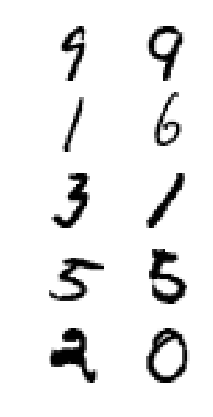

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6923601
0 테스트 정확도: 0.5031
1 훈련 손실: 0.6937517
2 훈련 손실: 0.6889615
3 훈련 손실: 0.6279487
4 훈련 손실: 0.52220035
5 훈련 손실: 0.53943956
5 테스트 정확도: 0.7317
6 훈련 손실: 0.540305
7 훈련 손실: 0.4539397
8 훈련 손실: 0.4506486
9 훈련 손실: 0.46825838
10 훈련 손실: 0.35033748
10 테스트 정확도: 0.8226
11 훈련 손실: 0.41334054
12 훈련 손실: 0.36943886
13 훈련 손실: 0.3761535
14 훈련 손실: 0.3200155
15 훈련 손실: 0.32761735
15 테스트 정확도: 0.8599
16 훈련 손실: 0.31543648
17 훈련 손실: 0.34082982
18 훈련 손실: 0.28993767
19 훈련 손실: 0.3072752
20 훈련 손실: 0.3542515
20 테스트 정확도: 0.8762
21 훈련 손실: 0.2317312
22 훈련 손실: 0.29069823
23 훈련 손실: 0.2473632
24 훈련 손실: 0.2669435
25 훈련 손실: 0.2391796
25 테스트 정확도: 0.8854
26 훈련 손실: 0.25618118
27 훈련 손실: 0.30616865
28 훈련 손실: 0.26199123
29 훈련 손실: 0.2588208
30 훈련 손실: 0.26606965
30 테스트 정확도: 0.8996
31 훈련 손실: 0.26256463
32 훈련 손실: 0.23858151
33 훈련 손실: 0.21879897
34 훈련 손실: 0.2566312
35 훈련 손실: 0.22745407
35 테스트 정확도: 0.9138
36 훈련 손실: 0.19570504
37 훈련 손실: 0.14133596
38 훈련 손실: 0.15163466
39 훈련 손실: 0.18004763
40 훈련 손실: 0.16298905
40 테스트 정확도: 0.930

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9308
10 테스트 정확도: 0.9596
20 테스트 정확도: 0.963
30 테스트 정확도: 0.9637
40 테스트 정확도: 0.9635
50 테스트 정확도: 0.9634
60 테스트 정확도: 0.9634
70 테스트 정확도: 0.9634
80 테스트 정확도: 0.9633
90 테스트 정확도: 0.9632


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8623
10 테스트 정확도: 0.9184
20 테스트 정확도: 0.9385
30 테스트 정확도: 0.9398
40 테스트 정확도: 0.9402
50 테스트 정확도: 0.9402
60 테스트 정확도: 0.9401
70 테스트 정확도: 0.94
80 테스트 정확도: 0.9401
90 테스트 정확도: 0.9401
100 테스트 정확도: 0.94
110 테스트 정확도: 0.9399
120 테스트 정확도: 0.9397
130 테스트 정확도: 0.9395
140 테스트 정확도: 0.9396


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!